# Homework 10 - CIFAR10 Image Classification with PyTorch

Group: Gassan Soukaev and Edgar Pino

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [61]:
import torch
torch.rand(5, 3)

tensor([[7.2985e-01, 4.4105e-01, 4.1390e-01],
        [3.9111e-02, 9.8556e-01, 4.5012e-01],
        [8.2994e-01, 5.1045e-04, 8.1189e-01],
        [5.0642e-01, 8.5588e-01, 3.4847e-01],
        [7.7694e-01, 3.7301e-01, 5.9464e-01]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [ ]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchsummary import summary


import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [63]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [ ]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [65]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [66]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]

In [ ]:
training_epochs = 5

In [ ]:
images_batch, labels_batch = iter(train_loader).next()

In [70]:
images_batch.shape

torch.Size([8, 3, 32, 32])

In [71]:
labels_batch.shape

torch.Size([8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


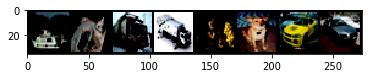

In [72]:
import torchvision 
img = torchvision.utils.make_grid(images_batch)
plt.imshow(np.transpose(img, (1,2,0)))

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [73]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004269, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.951116, Train Accuracy: 0.327250
  Epoch 0 @ step 2000: Train Loss: 1.802797, Train Accuracy: 0.358875
  Epoch 0 @ step 3000: Train Loss: 1.803065, Train Accuracy: 0.355875
  Epoch 0 @ step 4000: Train Loss: 1.773402, Train Accuracy: 0.366500
  Epoch 0 @ step 5000: Train Loss: 1.788621, Train Accuracy: 0.358250
  Epoch 0 @ step 6000: Train Loss: 1.750423, Train Accuracy: 0.367250
Epoch 0 Test Loss: 1.771595, Test Accuracy: 0.361800, time: 17.5s
  Epoch 1 @ step 7000: Train Loss: 1.743127, Train Accuracy: 0.379000
  Epoch 1 @ step 8000: Train Loss: 1.726337, Train Accuracy: 0.381625
  Epoch 1 @ step 9000: Train Loss: 1.759894, Train Accuracy: 0.377375
  Epoch 1 @ step 10000: Train Loss: 1.758370, Train Accuracy: 0.371375
  Epoch 1 @ step 11000: Train Loss: 1.739414, Train Accuracy: 0.375500
  Epoch 1 @ step 12000: Train Loss: 1.722919, Train Accuracy: 0.383500
Epoch 1 Test Loss: 1.694

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

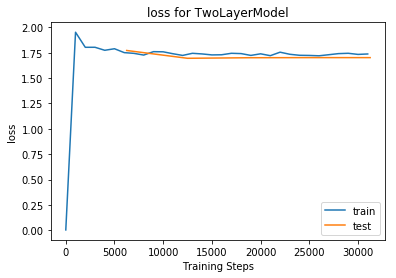

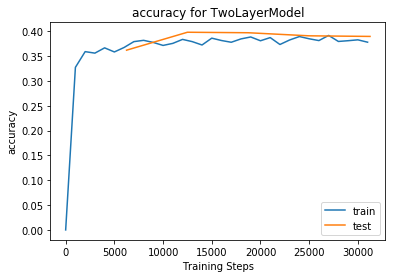

In [74]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [75]:
layer1_in_channels = 3
layer1_output_channels = 16

layer2_in_channels = layer1_output_channels
layer2_output_channels = 16

layer3_out = 64
kernel_size = 5 
nun_labels = 10

padding_size=1
stride_size=1

class ConvModel(nn.Module):
  def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(layer1_in_channels, layer1_output_channels, kernel_size, stride=stride_size, padding=padding_size),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(layer2_in_channels, layer2_output_channels, kernel_size, stride=stride_size, padding=padding_size),
            nn.ReLU(),
            Flatten())
                      
        
        self.layer3 = nn.Sequential(
            nn.Linear(2704, layer3_out),
            nn.ReLU())
        
        self.fc = nn.Linear(layer3_out, nun_labels)
        
        
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      return self.fc(out)

        
      

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004320, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.980928, Train Accuracy: 0.262625
  Epoch 0 @ step 2000: Train Loss: 1.650445, Train Accuracy: 0.392000
  Epoch 0 @ step 3000: Train Loss: 1.573110, Train Accuracy: 0.428625
  Epoch 0 @ step 4000: Train Loss: 1.519284, Train Accuracy: 0.447375
  Epoch 0 @ step 5000: Train Loss: 1.494058, Train Accuracy: 0.455500
  Epoch 0 @ step 6000: Train Loss: 1.456495, Train Accuracy: 0.470625
Epoch 0 Test Loss: 1.448827, Test Accuracy: 0.459000, time: 26.9s
  Epoch 1 @ step 7000: Train Loss: 1.425526, Train Accuracy: 0.480000
  Epoch 1 @ step 8000: Train Loss: 1.401772, Train Accuracy: 0.493625
  Epoch 1 @ step 9000: Train Loss: 1.390358, Train Accuracy: 0.500625
  Epoch 1 @ step 10000: Train Loss: 1.379170, Train Accuracy: 0.501000
  Epoch 1 @ step 11000: Train Loss: 1.372801, Train Accuracy: 0.508000
  Epoch 1 @ step 12000: Train Loss: 1.344001, Train Accuracy: 0.519125
Epoch 1 Test Loss: 1.311

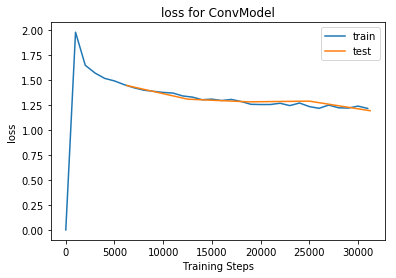

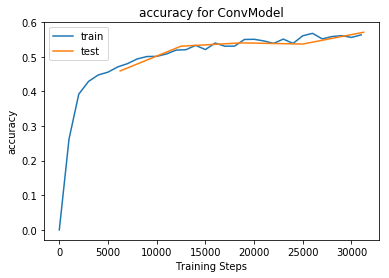

In [76]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [77]:
layer1_in_channels = 3
layer1_output_channels = 64

layer2_in_channels = layer1_output_channels
layer2_output_channels = 128

layer3_in_channels = layer2_output_channels
layer3_output_channels = 256

layer4_in_channels = layer3_output_channels
layer4_output_channels = 512

kernel_size = 3
nun_labels = 10
padding=3

class AwesomeModel(nn.Module):
  def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(layer1_in_channels, layer1_output_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(layer1_output_channels, layer1_output_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(layer2_in_channels, layer2_output_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(layer2_output_channels, layer2_output_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(layer2_output_channels, layer2_output_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(layer3_in_channels, layer3_output_channels, kernel_size=3),
            nn.BatchNorm2d(layer3_output_channels),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.dropout = nn.Dropout2d(p=0.2)
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(layer4_in_channels, layer4_output_channels, kernel_size, padding=2),
            nn.BatchNorm2d(layer4_output_channels),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(layer4_output_channels * kernel_size * kernel_size, nun_labels)
        
  def forward(self, x):
      out = self.layer1(x)
      
      out = self.layer2(out)
      
      out = self.layer3(out)
      
      out = self.dropout(out)
  
      out = self.layer4(out)
  
      out = out.reshape(out.size(0), -1)
      return self.fc(out)


        
      

model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

summary(model, (3,32,32))
metrics = train(model, train_loader, test_loader, loss, optimizer, 10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 36, 36]           1,792
              ReLU-2           [-1, 64, 36, 36]               0
            Conv2d-3           [-1, 64, 40, 40]          36,928
              ReLU-4           [-1, 64, 40, 40]               0
         MaxPool2d-5           [-1, 64, 20, 20]               0
            Conv2d-6          [-1, 128, 20, 20]          73,856
              ReLU-7          [-1, 128, 20, 20]               0
            Conv2d-8          [-1, 128, 20, 20]         147,584
              ReLU-9          [-1, 128, 20, 20]               0
           Conv2d-10          [-1, 128, 20, 20]         147,584
             ReLU-11          [-1, 128, 20, 20]               0
        MaxPool2d-12          [-1, 128, 10, 10]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-1, 25

**What changes did you make to improve your model?**

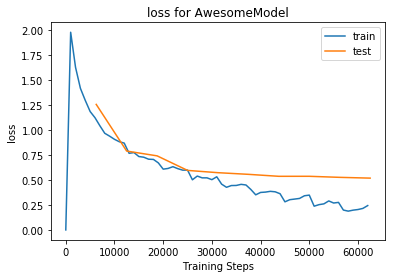

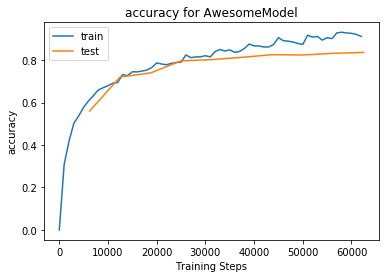

In [78]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [79]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-30 21:30:42--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-30 21:30:43--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip.1’

test_file.zip.1     100%[===================>]   3.66M   852KB/s    in 4.4s    

2019-04-30 21:30:49 (852 KB/s) - ‘test_file.zip.1’ saved [3841776/3841776]

Archive:  test_file.zip
replace test_file.pt? [y]es, [n]o, [A]ll, [N]one, [

Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [ ]:
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'

f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)

model.eval()
with torch.no_grad():
  for ele in test_loader:
      x = ele[0]
      image = x.reshape(-1,3,32,32)
      image = image.to(device)
      preds = model(image)
      
      pred_labels = torch.argmax(preds, dim=1)
      for pred_label in pred_labels:
        f_pred.write(str(pred_label.item()))
        f_pred.write('\n')

f_pred.close()


# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points): 0.389500

Test loss (5 Points): 1.701191

Training time (5 Points): 88.6s

Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

![accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYsAAAEWCAYAAACXGLsWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl4VdXV+PHvSsgIBEIIU8IQEBQQ%0ABQmoda6ioK1obdVaW2tteduqtW9bW62trdj+XjtZ21drxZa2ahXHKq9FQVuHqqAERCYZwpyEISSB%0AhCQ34/r9cXaSk8tNcoEcMq3P89wnZ7x33SFnnb33OXuLqmKMMca0JqajAzDGGNP5WbIwxhjTJksW%0Axhhj2mTJwhhjTJssWRhjjGmTJQtjjDFtsmRheiwRGSwib4tImYj8pqPj6elE5D4R+VOU2y4TkeuD%0Ajsk0sWRherI5wH4gRVW/eyxPJCI/FJFD7hESkTrf/Lr2CRdEZI+InN1ez3eUMcwUERWRp8KWn+6W%0Av9pRsZngWLIwnYp4jtfvciSwXo/izlQR6eWfV9X/p6p9VLUP8HVgacO8qk5sp3g7nO997wY+KSIp%0AvtU3AJuOf1TmeLBkYQ4jIneIyBZXPbNeRK4MW/81EfnYt/40t3y4iLwgIoUiUiQiD7rlPxWRJ3z7%0Aj3JnoL3c/Jsi8nMReReoAEaLyI2+19gqIv8VFsNsEVklIqUu1pki8jkRWRG23XdE5KUI7/GveAe3%0A77uz/4tEJEFEHhCRAvd4QEQS3Pbni0ieiPxARPYAfznCz/QXIvIrN50kIlUicq+bT3GlkT5u/ir3%0AuR4QkddFZGwUz58uIq+4z75YRF4SkaFu3RfdZ+vf/oci8rQvngdEZJcrufyv733PFJFcEfmxiOwF%0AHnZPUQG8AnzObRcPfAYIL22cJyIrReSgqzqa5lt3goi8677jV4DUsH3PEZH33eewUkTOivLjNkFQ%0AVXvYo9kD7wAwDO9k4hqgHBjqW5cPTAMEOAHvDD0W+Aj4LdAbSATOdvv8FHjC9/yjAAV6ufk3gZ3A%0ARKAXEAdcBoxxr3Ee3sHpNLf9dOAgMMPFmAGcBCQAxcB432t9CFzVwvv8K/Az3/xcYBkwCEgH3gPu%0AdevOB2qBX7jXSWrl8/sy8E7YskuB5W76k8AW4C3fuvfd9CSgzL1ePPBjYL3vs9rT8LmGPf9gYDaQ%0ABPQDXgIWuHW9gVIgy7f9x8Blbvph4Dmgv9t3MfATt26me99zXTxJblmuex8N7+Ez7jVvAV51ywa5%0A173afa9fBgrda4j7bv7HPe+F7jv+k+83UgRc5L7jS92+qW79MuD6jv5f6UmPDg/AHp3/AawCZrvp%0AxcBtEbY50/0z94qw7qe0nSzmthHDiw2vCzwC/LaF7R4Gfu6mJwIlQEIL2/6V5sliC3Cpb/4SYLub%0APh+oBhKj+Ly+zOHJIgWoAvq6z+N7eFU5iXgJ6Jduu58Dj/n2i3Wf6xluPmKyiBDDGcBu3/xfgB+7%0A6WxgnzuA93LvK8O37QXAx256Jt7JQpxvfUOyEGC7+z5fBK6iebL4GvB2WFwfAtcC44CQ//MEXqAp%0AWfwEeDRs37eAa9y0JYvj/LBqKHMYEfmSq+I5ICIHgJOBgW71cLyDarjhwA5VrT3Kl90VFsMsV21R%0A7GK4NIoYAP4GXCciAnwReEZVq6KMYRiwwze/wy1rUKiqoSifqxlVLQXWAOcA5wJvAMuB0/FKTm9F%0AikFV6/BKchmtPb+I9BWR+SKyU0RKgSU0fV7gfS5fcNPXA0+572oYXklune/7fhGvVNBgj6rWRHhP%0ACjwJfBsvOf1f2CbhnyduPsOtC/88/duOBK5viMnFlU3z78McR5YsTDMiMhJ4FO8MMU1V+wNr8c4i%0AwTuoj4mw6y5gRHjDr1MOJPvmh0TYprGR2dWXPw/8GhjsYlgURQyo6jK8M+VzgOuAxyNt14ICvINU%0AgxFu2WExHqW38KrOxuOV1t7Cq26bDLwTKQYRicU7uOa38dx3AJnANFVNAS6m6fNqeO1EETkD+DxN%0An8tuvGqmMara3z36qWqab9/W3vdjwLeAf6hqddi68M8TvM80373uQBFJDFvXYBdeKaO/79FbVX/b%0ASiwmQJYsTLjeeAeHQgARuRGvZNHgT8D3RGSqeE5wCeYDvAPAfSLSW0QSfQ2Sq4BzRWSEiPQD7mwj%0Ahni8doFCoFZEZuEd/Br8GbhRRC4UkRgRyRCRk3zrHwMeBGpU9R2i9xTwI9dYPBC4G3iijX2OxFvA%0ATcBKV2J4E+/KqXWqetBt8zRwpYicKyJxeEmgCMjxPU+8+3wbHrF41VsVwAEX+4/8L+xKAY8D84Ai%0AVc1xy2uA+cDvRGSg+06Hi8iMaN6Qqm7Aq6K7J8LqhcAUEfmsiPQSkS/hJYRX8K6a2gj8WETiReQC%0AvOqtBn8DPue+41jXCH+hiEQ60TDHgSUL04yqrgd+AywF9uI1uL7rW/8sXr36k3gNsS8CA9zB79N4%0ADd47gTy8xnFU9TW8g+BqYAXwchsxlOGdrT6D1+ZwHd6Bp2H9B8CNeI3pB/EOwv4z2MfxEtyRHuh/%0AhndQXo1XZbTSLWsv/8FLxm+7+VVAvW8eVV2Nl1AewUuWF+K1F/mr9/4FVPoed+KVwgbiJZZ38Epi%0A4R7D+z7DS1vfxisF5OB9nq/ifY9RUdW3VXVPhOV7gcuBu1xctwCfUtWDLnldjdc+Ugx8H9/3papb%0A8dpA7sG7F2YHcBt2zOow4n1nxnQfIpKE14B7mqpu7uh4OgsR6Yt3AnCSqu7s6HhM12JZ2nRH38C7%0ATNUSRXO3Am9aojBHI1JjpDFdlohsx2vYvaKDQ+lU3I2EFXjVQsYcMauGMsYY0yarhjLGGNOmblMN%0ANXDgQB01alRHh2GMMV3KihUr9qtqelvbdZtkMWrUKHJyctre0BhjTCMRCb/LPiKrhjLGGNMmSxbG%0AGGPaZMnCGGNMmyxZGGOMaVOgycKNsrXRjbR1RyvbXSXeyGnZvmV3uv02isglQcZpjDGmdYFdDeV6%0AwnwIr0vmPGC5iCx0HdX5t+uL10HY+75lE/AGSJmI13/96yIyznVWZ4wx5jgLsmQxHchV1a2un/sF%0AeMM+hrsXb6Qw/yAos/GGhKxS1W14o3JNDzBWY4wxrQjyPosMmo9+loc3KlgjETkNGK6q/xSR28P2%0AXRa272EjhYnIHGAOwIgRI8JXG2NM91JfB+X7oXwfHNoLh9zfxH6Q/ZVAX7rDbsoTkRjgfrzxio+K%0Aqs7DG8yF7Oxs6+TKGNP1qEJliXfgL9/XlAAak4FvWcV+0PrDnyNzWpdOFvl4YyU3yKT50JB98Qao%0AedMbLpkhwEIRuTyKfY0xpnOrOtR0wG8rCdQfNsQ5xMRBn8HQZxD0y4SM07zphmUNf3sPgoQ+gb+d%0AIJPFcmCsiGThHeivxRvxDAA3jGTjgPIi8ibwPVXNEZFK4EkRuR+vgXss3rCdxhjTcWqrmh/kW0sC%0ANeWH7y8xkDyw6UCffpI78EdIAon9QeTw5+gggSULVa0VkVuAxUAsMF9V14nIXCBHVRe2su86EXkG%0AWI83mPzNdiWUMT1Hfb2ytyzEzqIKdhZ7j1BNHV87dzSD+ia284u5dgB/G0CzJOD7GzoQ+TmSUr2D%0AfO90yJjqO/D7E8FgSE6DmNj2jf846TbjWWRnZ6t1JNh5qCpbCg+xeN1edhSVM/PkIZw7Np1esR10%0AH2hNJRzYCX2HQmLKEe26YU8pdfXKxGH9Agque9q2v5z8kkoUpV6hXhXc33r1fiP1CnX1yp7SEDuL%0AyhsTw66SSqprm+rmYwRiREjtHc+Dn5/C6aPTWn9xfztAW0mgoihyO0B8n6YDfe/0pgN+48E/vWld%0Ar4R2/vSOHxFZoarZbW5nycK0l/p65cNdB1iyfg+vrdvL1v1eMbxvQi/KqmoZkpLIZ6dmcnX2cEak%0AJQcXiCqUbIO8HMhb7j32rIH6Wm998kAYMNo9spqmU7MgeUBj0b+iupbfLNnEX97dhojwnRnj+MZ5%0AY4iJOfqqAVUl/0AlGf2TkHaoYnht/V7ySiq4ZOIQhvVPOubnO1bb95fz8uoCXl69mw17yo5o3z4J%0AvRgxINl7pCUzfEAyI938sP5JbN1/iG88sZKdxRXcfvFY5kzpTcyBHVCy3fu+S7Z7j4N5XiKI1A4Q%0AG9/8gN+YBHxn/33S270doDRUwxsb9pFXUsnAPvEM6ptIet8EBvVNYEDv+I47icKShTlOqmrreG9L%0AEUvW7eW19XvZf6iKXjHCmWPSuHjiEGaMH8yA3vH8e8Nenl6+i7c2FVKv8IkxaVwzbTiXTBxCYtwx%0AFsuryiB/pUsMLkFU7PfWxfX2GgaHT4eBJ0LZbije6h7boDQf8P0PJPSDAVnsixvGqwVJrKlMY+xJ%0Ap7KDwfx9XRXnjE3n/qsnk973yM8kdxSVc/dL63hrUyE3njWKH1824ZgSz8NvbuEXr25onJ86MpVP%0AnTKUSycNZXDKkVfV1NbVs7esirTe8Uf0newsquCfa3bz8uoC1hWUNsZy2aShTByWQmyMIAIiQowI%0AgldK8JZ504NTEklNjmueQGsqoaR5Mqjdv5XCXRtJrSogUfzJQLxG4NRR0G94hDYAlwQS+7OntIq/%0Av7+DAxU1DOufxLD+iQzt5/0dnJJIXDsduEvKq3nt4728smY37+YWUV0XofSC9xmk9Y4n3ZdAhvVP%0AakqcA5IZ1DfhmH4rrbFkYZopr6pl4UcFHArV8pnTMkjrc/TFZlXlg23FPL5sB29s2Ed5dR2942M5%0A/6RBXDxhMOefOIh+SXER9919sJLncvJ4OmcXeSWV9EuK48opGVydPZwJw6KoHqqvh6LNsOuDpuSw%0Abz2NB/yBJ0LmNCoGTSEx63RiBk9ovY64JgQHdjQmj9DezWzbvIbEsp2MiCkklqZ/8NrYJLbUplMQ%0AM4SxJ51C5piJXmlkwGjvQNXC61TV1vHo21v533/nEhcbwxmj03j9471cfuowfv25U4nvdWQHJ1Xl%0A10s28tAbW/j0qcO47cITeHXtnsazeRGYNmoAnzplKLNOHhoxsVVW17FhTynrCrzH+oKDbNhTRpWr%0A+hnYJ56M/klkpCZ5f/snkZGa3LisLFTDojW7eXn1blbnHQRg8vD+jckqqlKOqlcC8JcKGh7F2+DQ%0Anubbx/WGAVlo6kjWVabx7NZYDiVlMmf2hZx44oQ2q4I27S1j3ttbeWlVPnX1St/EOA5WNi99xAik%0Au4P1MJdAhjW+/yQy+yeTktSrxVJhYVkVi9ft4dW1e1i6tYi6eiWjfxIzTx7CpZOGMGFoP4rKq9hX%0AVkVhWdPfwrJQ4/y+0ir2lYWo95/D9IphuC95NDxOHd7/qE5c/CxZGMCrN3586Q6eXbGLspBXDZPQ%0AK4Yrp2Rw41lZnDikb9TPVVNXz6I1u/nzO9tYnXeQ/slxzDp5KBdPHMwnxqSR0Cv6s9H6emXp1iIW%0ALN/F4rV7qK6rZ3rWAO65fCLjh/qSRkUx5K9oqk7KWwFV3sGJxH7e9eWZ0yAzGzKmUlzfm5+9vJ4X%0APsxncEoCF40fzEUTBnPm6LRWz5ZVlRdW5vOzf67nUFUt3zz/BL557ggSygu8A5dLJod2b2L/rg0M%0ArdtDgv/MNiYOUkc2r9IaMJpVFan84PUDbNxfzWWThnL3pycwqG8Cj7y9lfte2cDZJwzkj1+cSp+E%0A6K41qa9X7vm/dfxt6Q4+P304P7tiErG+M87cfWX8c/UeXl5dwOZ9h4gROD0rjVmThhCqqWO9Sw5b%0ACg81HoxSEnsxcVg/Jg5LISu9N8WHqsk/UOk9Sry/VbWRz4onZfRrTBDDB0SoWmxIxuGJoGG6ttK3%0AsUDKMK90kJrl/rrHgCyvcdh3kF65s4Rb/r6S/YequfvTE/jC6SMOO4irKu9vK2be21v594Z9JMXF%0Acs204dx0dhbDByRTXlXL7oOVFBwIsftgJfkHQuw+UEnBwUp2HwhRcLCSUE3z994noRcZrkTiJdNk%0AesUIr328l+Xbi1GFrIG9mXnyEGadPIRJGf2OuMqxurae/AOVjW04Te05lewsKqe82rve53fXTmb2%0A5MPuVz4ilix6sLp65c2N+/jb0h28vamQuFhh1slDueETI+mXFMf8d7fzwso8QjX1nDN2IF85K4vz%0AxqW3WMw9WFnDgg928tf3trP7YIjR6b256ewsPjMlk6T4Y7+yo6S8mhc+zOfhf21gSPU2vjmmmBn9%0AdhFXkANFud5GEgODJnpJYfh0L0EMGAMx3lm5qvLSqgLmvrye0soarj9jJHtLQ7y1qZCK6jqS42M5%0Ab1w6F40fzAUnDWJA7/jG199ZVMFdL67hP5v3M3VkKv/zmUmMG9xyEq2oruWel9bw9oo1XDy0gv+e%0A2ov+lbu8M+SG6q3qQ03fBzFU9x5G0uATmiWSJXt689+vHWD00HT+cuM0BrZR2qutq+f7z6/mhZX5%0AfO2cLH546fhWD0Kb9pbx8kde+0FD+9GQlEQmDkth4rAUJrgEkZnaevuJqrK/IYGUVJJ/oAJBuHji%0AYEYOSIbywsiJoGQ7lBU0f7K45JaTQb/hEHdk1WfF5dV8++lVvL2pkCsmD+PnV06id0Iv6uqVxev2%0A8MhbW/go7yADesfz5U+M4otnjCTV9923RVUpLq9uljjzSryHt6yCUncSNm5wH2aePJRLJw3hxMF9%0A26VNqrWYdhZXMGJA8jHVEoAlix6ppLyaZ3J28fiyHeSVVDI4JYEvnD6Sa6cPP+xyw5Lyap78YCeP%0ALd3O3tIqRqf35sazsrjqtAyS472z3J1FFcx/dxvP5OyiorqOM0en8bVzszh/3KD2qT8t2+srMeSg%0ABSuRmgoAiulHzdBsBk04G8mcBsOmtNjguKu4grteXMvbmwqZMqI/933mlMYSU6imjqVbi3h9/V5e%0A/3gve0uriBHIHjWAGeMHU1Nfz+//tZleMTH8YOaJfOH0kVG/t5dW5fPDF9YQ1yuGX332VGZMGEx9%0AvfLM8p088sr7pNcW8OWT6pkxuJy40h1NbSWVJc2eZ6+msjt2GCecOIk+Q8c2b3xP9K7Aqqqt47an%0AVvHquj18Z8Y4bv3kCVEfjFSV7UUVpCT2OroDS22VdyVZpGRQsv3w+wn6Do2cDFJHeQ3K7XwQra9X%0AHnwjl9++vokx6X24OjuTv7+/kx1FFYxMS+Zr54zms1Mzj71trAVloRoqquuOqp2oM7Bk0YMUHKjk%0Agdc38dKqAqpq6zk9awBfOnMUF08c3GZjXXjVUr+kOK6ZNpydRRUsWb+HGBEuP3UYXzk7i5MzjuHS%0A0doq74qkxuSw3DsAgVeFM/SUxiqlNTKO779+gI/3lHHeuHTmzp7IyLTehz9lXT1/fW87v1myiRiB%0A7888ievPGNmsWsZPVVmTf5DX1+9lyfq9jVfrzJgwmLmzJzK035FfTbRtfzm3PLmSdQWlfOH0EWzc%0AU0bOjhKmZw3g51eczNhIJZTKkqaqrZJtFO3awI7NaxnOXtJpnkhITqMuNYtlJSksL+3PlFOnct4Z%0A071kElYtc9RUvctHIyaDbVBaQLOLAHolNU8E/mTQfwTEdcxVWe9s3s9tCz6kqLyaU4f35+vnjubi%0AiUNa/D0YjyWLHuJfH+/lu89+RKimjs+clsmXzhzJSUOO7D4C8A6kK3aU8Od3trF43R76JsbxhdNH%0A8KUzRzGk3xGeMal6ly/6r07a/RHUVXnrUzKbVycNOeWw6ofaunr+tnQH9y/ZSG29cvMFJ/Bf541u%0AbBdZV3CQO55fw5r8g1w0fhBzZ598xJeO7iquoLi8mlMyj7xO2a+qto7/WbSBv763ndTkOO66bAJX%0AnZZxRM+Zu6+ML/35A2pCh3j002lMTi6Gkm1UF+aycf1HpFblkyFFSLMrt1LcgTrCZcB9hjRW0QFQ%0AW91UOojUoOyrNgO8/cMTQcOjz+BOdWexX2FZFfkHKjn1GL/TnsSSRTdXXVvPrxZv4NH/bGPC0BQe%0AvG4Ko9Pb57rw4vJqkuJio2+PqK6A3auaX6HUcCVLrySvCikzu6khOmVY1LHsORji3n+u55+rd5M1%0AsDc//tR43t9WzJ/+s43U5HjuuXwil04a0ikODGvyDjJ8QBL9k6OvE/fbfbCSG+Z/wPb9Ffz2msmc%0AMXoAX5r/AZv2lvHANVO4bMIAdynptuaX/xZv9RqRG+4jgaaz/6RUOLjLS97+RBOb0HIy6D8S4gO8%0AD8Z0KpYsurFdxRXc+tSHrNp1gC+eMZK7LhsfWH3sYVS9g5O/OmnPWmjojWXA6OZXKA0+GWIjX0Z7%0AJN7eVMjdL61le5HXpnFN9nB+eOl4+iUf+3N3JgcravjqY8vJ2VHCkJREisur+eMXp3LBiYNa37Gu%0A1ksK/kb24m1QWexVDYVXG4WXPEyPZcmim1q8bg+3P/sRqnDfVadw2SlDg33B0EF3w5vvbujKYm9d%0AfF/vhrfMaV6VUsZU6D2w9ec7llBq6ljwwU5OGprCGW1199CFhWrq+NZTH7J0SxF/uiG77a4tjDkG%0Aliy6GX+9+KSMfjx43ZSIjb7HpL4e9m9sXp1UuIHG6ov0k3ylhmmQfmKX7RSts1NVqmrrj1+J0fRY%0A0SaLDhv8yERvR1E5tzz5IWvyD3LjWaO4Y9ZJR3QDXIvKiyDfV2LIXwlVXncNJKV6CeHkz3jVScNO%0Ag6T+x/6aJioiYonCdCqWLDpAbV09a/IPUlxe7esjRxp71hSa5ncUVXDvy+sRgUe+OJVLJg459gAK%0APoTnboLiLd68xMLgiTDpc02lhrQxnfaKF2PM8WfJ4jior1c27i3jvS1FvJe7n/e3FXOoqrbtHZ3J%0Aw/vz4HVTyExtpytU+g6FQePhtC9C5nQYNhni27lKyxjTrViyCMjOogre3bKfd3P3s3RLEUXl1YDX%0AZ8zlk4dx1piBZKQmNfbpDw19/Hv9/avr7z82RjhtZGq79YQJQN8hcO3f2+/5jDHdXqDJQkRmAr/D%0AGynvT6p6X9j6rwM3A3XAIWCOqq4XkVHAx8BGt+kyVf16kLG2l398mMdvlmwir8TrIG1Q3wTOHZfO%0AJ8ak8YkTBpLRCcYcMMaYIxVYshCRWOAhYAaQBywXkYWqut632ZOq+ke3/eXA/cBMt26Lqk4OKr4g%0AvL+1iNufXc3EYSnMOXc0nxgzkDHpvTvFDWPGGHMsgixZTAdyVXUrgIgsAGbjjasNgKqW+rbvTbNb%0ATLuWggOV3PzkSkYMSObxr55OSmL3ulnMGNOzBXkLZwawyzef55Y1IyI3i8gW4JfAt3yrskTkQxF5%0AS0TOifQCIjJHRHJEJKewsLA9Yz8ioZo6vvHECkI19cz70lRLFMaYbqfD7/dX1YdUdQzwA+BHbvFu%0AYISqTgG+AzwpIof1jqeq81Q1W1Wz09PTj1/QzWPgRy+u5aO8g9x/9amcMCj6wYSMMaarCDJZ5APD%0AffOZbllLFgBXAKhqlaoWuekVwBZgXEBxHpPHlu7guRV5fOvCsVzcHvdAGGNMJxRkslgOjBWRLBGJ%0AB64FFvo3EJGxvtnLgM1uebprIEdERgNjga0BxnpU3t9axL0vr+ei8YP49oVj297BGGO6qMAauFW1%0AVkRuARbjXTo7X1XXichcIEdVFwK3iMhFQA1QAtzgdj8XmCsiNUA98HVVLQ4q1qNRcKCSb/59JSPS%0Akrn/msntM3KcMcZ0UtaR4FEI1dRx9SNL2VpYzos3n8UJg9pnHAljjDnerCPBgKgqd/1jLavzDvLo%0Al7ItURhjeoQOvxqqq/nbe9t5fmUet104lhkTBnd0OMYYc1xYsjgCy7YWce8/P+ai8YO5zRq0jTE9%0AiCWLKO0rC3Hz31cyMi2Z315zqjVoG2N6FEsWUXpn836Kyqu5/+rJ9LU7tI0xPYwliyiVVtYAMGJA%0AO40pYYwxXYgliyiVhbzBivom2gVkxpiex5JFlMqqakmKi23fQYiMMaaLsCNflEora6xUYYzpsSxZ%0ARKksVGvJwhjTY1myiFJpqMaugjLG9FiWLKJUFqolJcmShTGmZ7JkESWvZGHVUMaYnsmSRZTKQrWk%0AWLIwxvRQliyiVGZtFsaYHsySRRRq6uoJ1dTTN8FKFsaYninQZCEiM0Vko4jkisgdEdZ/XUTWiMgq%0AEXlHRCb41t3p9tsoIpcEGWdbGu7etgZuY0xPFViycGNoPwTMAiYAn/cnA+dJVZ2kqpOBXwL3u30n%0A4I3ZPRGYCfyhYUzujtDQL5Q1cBtjeqogSxbTgVxV3aqq1cACYLZ/A1Ut9c32BhrGeJ0NLFDVKlXd%0ABuS65+sQTf1CWcnCGNMzBXmqnAHs8s3nAaeHbyQiNwPfAeKBT/r2XRa2b0aEfecAcwBGjBjRLkFH%0AUhaykoUxpmfr8AZuVX1IVccAPwB+dIT7zlPVbFXNTk9PDyZAoLShzcJKFsaYHirIZJEPDPfNZ7pl%0ALVkAXHGU+waq1EoWxpgeLshksRwYKyJZIhKP12C90L+BiPgHsr4M2OymFwLXikiCiGQBY4EPAoy1%0AVWVWsjDG9HCBnSqraq2I3AIsBmKB+aq6TkTmAjmquhC4RUQuAmqAEuAGt+86EXkGWA/UAjeral1Q%0Asbaloc2ij5UsjDE9VKBHP1VdBCwKW3a3b/q2Vvb9OfDz4KKLXlmolt7xscTGSEeHYowxHaLDG7i7%0AgrJQjd2QZ4zp0SxZRKG00gY+Msb0bJYsolBWZZ0IGmN6NksWUbAhVY0xPZ0liyh4Y1lYycIY03NZ%0AsohCaaWNkmeM6dksWUTBq4aykoUxpueyZNGGUE0d1XX1VrIwxvRoliza0NTVhyULY0zPZcmiDQ2d%0ACNpNecaYnsySRRuaBj6ykoUxpueyZNGGpoGPrGRhjOm5LFm0wUoWxhhjyaJNDSULuynPGNOTWbJo%0AQ2mllSyMMcaSRRvKQjWIQO94SxbGmJ4r0GQhIjNFZKOI5IrIHRHWf0dE1ovIahH5l4iM9K2rE5FV%0A7rEwfN/jpTRUS5+EXsTYwEfGmB4ssNNlEYkFHgJmAHnAchFZqKrrfZt9CGSraoWIfAP4JXCNW1ep%0AqpODii9a1omgMcYEW7KYDuSq6lZVrQYWALP9G6jqG6pa4WaXAZkBxnNUSkPWiaAxxgSZLDKAXb75%0APLesJTcBr/jmE0UkR0SWicj8sdhXAAAacUlEQVQVkXYQkTlum5zCwsJjjziCslCNlSyMMT1epzhl%0AFpHrgWzgPN/ikaqaLyKjgX+LyBpV3eLfT1XnAfMAsrOzNYjYykK1DElJDOKpjTGmywiyZJEPDPfN%0AZ7plzYjIRcBdwOWqWtWwXFXz3d+twJvAlABjbZGNkmeMMcEmi+XAWBHJEpF44Fqg2VVNIjIFeAQv%0AUezzLU8VkQQ3PRA4C/A3jB83paEa60TQGNPjBXbKrKq1InILsBiIBear6joRmQvkqOpC4FdAH+BZ%0AEQHYqaqXA+OBR0SkHi+h3Rd2FdVxoapWsjDGGKJMFiLyAvBn4BVVrY/2yVV1EbAobNndvumLWtjv%0APWBStK8TlMqaOurq1ToRNMb0eNFWQ/0BuA7YLCL3iciJAcbUaVgngsYY44kqWajq66r6BeA0YDvw%0Auoi8JyI3iki3Pe22TgSNMcYTdQO3iKQBXwa+infn9e/wksdrgUTWCRy0TgSNMQaIvs3iH8CJwOPA%0Ap1V1t1v1tIjkBBVcR7OBj4wxxhPtKfPvVfWNSCtUNbsd4+lUGtosUqxkYYzp4aKthpogIv0bZtx9%0AEN8MKKZOo6mB20oWxpieLdpk8TVVPdAwo6olwNeCCanzKG1o4E6ykoUxpmeLNlnEirtrDhq7H48P%0AJqTOoyxUQ2yMkBQX29GhGGNMh4r2lPlVvMbsR9z8f7ll3VrD3du+PGmMMT1StMniB3gJ4htu/jXg%0AT4FE1IlYVx/GGOOJ6kjouvh42D16DBvLwhhjPNHeZzEW+B9gAtA4uIOqjg4ork6htNJKFsYYA9E3%0AcP8Fr1RRC1wAPAY8EVRQnYU3pKqVLIwxJtpkkaSq/wJEVXeo6k+By4ILq3OwNgtjjPFEeySsEpEY%0AvF5nb8Eb8a5PcGF1DtZmYYwxnmhLFrcBycC3gKnA9cANbe0kIjNFZKOI5IrIHRHWf0dE1ovIahH5%0Al4iM9K27QUQ2u0ebr9Xe6uuVsqpa6+rDGGOIomThbsC7RlW/BxwCbozmid1+DwEzgDxguYgsDBvx%0A7kMgW1UrROQbwC+Ba0RkAPATIBtQYIXbt+QI3tsxKa+uRdW6+jDGGIiiZKGqdcDZR/Hc04FcVd2q%0AqtXAAmB22HO/oaoVbnYZkOmmLwFeU9VilyBeA2YeRQxHzQY+MsaYJtEeCT8UkYXAs0B5w0JVfaGV%0AfTKAXb75POD0Vra/CXillX0zooy1XVgngsYY0yTaZJEIFAGf9C1ToLVkETURuR6vyum8I9xvDjAH%0AYMSIEe0RSiPrRNAYY5pEewd3VO0UYfKB4b75TLesGRG5CLgLOE9Vq3z7nh+275sR4poHzAPIzs7W%0Ao4ixRTbwkTHGNIn2Du6/4JUkmlHVr7Sy23JgrIhk4R38rwWuC3veKcAjwExV3edbtRj4fyKS6uYv%0ABu6MJtb2Ym0WxhjTJNoj4cu+6UTgSqCgtR1Utdbdk7EYiAXmq+o6EZkL5KjqQuBXePdrPOt6dt2p%0AqperarGI3IuXcADmqmpx1O+qHZRasjDGmEbRVkM9758XkaeAd6LYbxGwKGzZ3b7pi1rZdz4wP5r4%0AgtBQDWU35RljTPQ35YUbCwxqz0A6m9LKWuJjY0jodbQfkTHGdB/RtlmU0bzNYg/eGBfdVlmoxgY+%0AMsYYJ9pqqL5BB9LZWCeCxhjTJKo6FhG5UkT6+eb7i8gVwYXV8cqse3JjjGkUbYX8T1T1YMOMqh7A%0A67up2yoN1doNecYY40SbLCJt162PpGWhGvomWMnCGGMg+mSRIyL3i8gY97gfWBFkYB3N2iyMMaZJ%0AtMniVqAaeBqv99gQcHNQQXUGXrKwkoUxxkD0V0OVA4cNXtRd1dUrh6qszcIYYxpEezXUayLS3zef%0AKiKLgwurYx2y7smNMaaZaKuhBroroABwAxJ12zu4Sxt7nLWShTHGQPTJol5EGgeMEJFRROiFtrto%0A6HHWxt82xhhPtEfDu4B3ROQtQIBzcIMOdUc2loUxxjQXbQP3qyKSjZcgPgReBCqDDKwjlTaWLCxZ%0AGGMMRN+R4FeB2/BGrFsFnAEspfkwq91GmbVZGGNMM9G2WdwGTAN2qOoFwBTgQOu7dF02Sp4xxjQX%0AbbIIqWoIQEQSVHUDcGJbO4nITBHZKCK5InLYfRoicq6IrBSRWhH5bNi6OhFZ5R4Lo4yzXVibhTHG%0ANBftqXOeu8/iReA1ESkBdrS2g4jEAg8BM4A8YLmILFTV9b7NdgJfBr4X4SkqVXVylPG1q9JQLYlx%0AMcTbwEfGGANE38B9pZv8qYi8AfQDXm1jt+lArqpuBRCRBcBsoDFZqOp2t67+yMIOlnVPbowxzR3x%0AqbOqvqWqC1W1uo1NM4Bdvvk8tyxaiSKSIyLLWho7Q0TmuG1yCgsLj+CpW1dqnQgaY0wznbmeZaSq%0AZgPXAQ+IyJjwDVR1nqpmq2p2enp6u72wdSJojDHNBZks8oHhvvlMtywqqprv/m4F3sS7Auu4KAvV%0A2N3bxhjjE2SyWA6MFZEsEYkHrgWiuqrJdVSY4KYHAmfha+sIWmlljd2QZ4wxPoElC1WtBW4BFgMf%0AA8+o6joRmSsilwOIyDQRyQM+BzwiIuvc7uPxBlz6CHgDuC/sKqpA2cBHxhjTXKBHRFVdBCwKW3a3%0Ab3o5XvVU+H7vAZOCjK01liyMMaa5ztzA3SFq6uqprKmzBm5jjPGxZBHGuic3xpjDWbIIY119GGPM%0A4SxZhLFOBI0x5nCWLMKUWsnCGGMOY8kijJUsjDHmcJYswpRWeiWLfklWsjDGmAaWLMJYycIYYw5n%0AySJMQ7Lok2DJwhhjGliyCFMWqiE5PpZesfbRGGNMAzsihikNWSeCxhgTzpJFGOsXyhhjDmfJIowl%0AC2OMOZwlizA2/rYxxhzOkkWY0lAtKXaPhTHGNGPJIoxXsrBqKGOM8Qs0WYjITBHZKCK5InJHhPXn%0AishKEakVkc+GrbtBRDa7xw1BxulXam0WxhhzmMCShYjEAg8Bs4AJwOdFZELYZjuBLwNPhu07APgJ%0AcDowHfiJiKQGFWuDqto6qmvr7dJZY4wJE2TJYjqQq6pbVbUaWADM9m+gqttVdTVQH7bvJcBrqlqs%0AqiXAa8DMAGMFrKsPY4xpSZDJIgPY5ZvPc8vabV8RmSMiOSKSU1hYeNSBNmjoRNBKFsYY01yXbuBW%0A1Xmqmq2q2enp6cf8fFayMMaYyIJMFvnAcN98plsW9L5HrSlZWMnCGGP8gkwWy4GxIpIlIvHAtcDC%0AKPddDFwsIqmuYftityxQTeNvW8nCGGP8AksWqloL3IJ3kP8YeEZV14nIXBG5HEBEpolIHvA54BER%0AWef2LQbuxUs4y4G5blmgGoZUtZvyjDGmuUBPoVV1EbAobNndvunleFVMkfadD8wPMr5w1mZhjDGR%0AdekG7vZWGqpFBPrEW7Iwxhg/SxY+ZaEa+sT3IiZGOjoUY4zpVCxZ+Fj35MYYE5klC5/Syhpr3DbG%0AmAgsWfhYycIYYyKzZOFTVmUDHxljTCSWLHysZGGMMZFZsvAprayxTgSNMSYCSxaOqlrJwhhjWmDJ%0AwgnV1FNbr9ZmYYwxEViycKwTQWOMaZklC6fUkoUxxrTIkoVT6joRtJvyjDHmcJYsnIYeZ1OsZGGM%0AMYexZOE0tVlYycIYY8JZsnBsLAtjjGlZoEdGEZkJ/A6IBf6kqveFrU8AHgOmAkXANaq6XURG4Y2u%0At9FtukxVvx5krKWVbpQ8K1kY06PU1NSQl5dHKBTq6FAClZiYSGZmJnFxR3eMCyxZiEgs8BAwA8gD%0AlovIQlVd79vsJqBEVU8QkWuBXwDXuHVbVHVyUPGFKwvVEhsjJMfHHq+XNMZ0Anl5efTt25dRo0Yh%0A0j3HslFVioqKyMvLIysr66ieI8hqqOlArqpuVdVqYAEwO2yb2cDf3PRzwIXSQd9WWaiGPgm9uu2P%0AxRgTWSgUIi0trVv/74sIaWlpx1R6CjJZZAC7fPN5blnEbVS1FjgIpLl1WSLyoYi8JSLnRHoBEZkj%0AIjkiklNYWHhMwVpXH8b0XN05UTQ41vfYWRu4dwMjVHUK8B3gSRFJCd9IVeeparaqZqenpx/TC5aG%0ArHtyY4xpSZDJIh8Y7pvPdMsibiMivYB+QJGqVqlqEYCqrgC2AOMCjJXSUK3dY2GMOe4OHDjAH/7w%0AhyPe79JLL+XAgQMBRBRZkMliOTBWRLJEJB64FlgYts1C4AY3/Vng36qqIpLuGsgRkdHAWGBrgLG6%0AaigrWRhjjq+WkkVtbW2r+y1atIj+/fsHFdZhAjuVVtVaEbkFWIx36ex8VV0nInOBHFVdCPwZeFxE%0AcoFivIQCcC4wV0RqgHrg66paHFSs4DVwpyT2DfIljDGd3D3/t471BaXt+pwThqXwk09PbHH9HXfc%0AwZYtW5g8eTJxcXEkJiaSmprKhg0b2LRpE1dccQW7du0iFApx2223MWfOHABGjRpFTk4Ohw4dYtas%0AWZx99tm89957ZGRk8NJLL5GUlNSu7yPQehdVXQQsClt2t286BHwuwn7PA88HGVs4a+A2xnSE++67%0Aj7Vr17Jq1SrefPNNLrvsMtauXdt4iev8+fMZMGAAlZWVTJs2jauuuoq0tLRmz7F582aeeuopHn30%0AUa6++mqef/55rr/++naN046ONAx8VGOdCBrTw7VWAjhepk+f3uxeiN///vf84x//AGDXrl1s3rz5%0AsGSRlZXF5MnebWlTp05l+/bt7R6XJQugvLqOerWuPowxHa93796N02+++Savv/46S5cuJTk5mfPP%0APz/ivRIJCQmN07GxsVRWVrZ7XJ310tnjyjoRNMZ0lL59+1JWVhZx3cGDB0lNTSU5OZkNGzawbNmy%0A4xxdEzuVxjoRNMZ0nLS0NM466yxOPvlkkpKSGDx4cOO6mTNn8sc//pHx48dz4okncsYZZ3RYnHZ0%0AxDoRNMZ0rCeffDLi8oSEBF555ZWI6xraJQYOHMjatWsbl3/ve99r9/jAqqEAK1kYY0xbLFngH3/b%0AShbGGBOJJQtsSFVjjGmLJQusZGGMMW2xZIFXsoiLFRLj7OMwxphI7OiId59F38S4HtGnvTHGHA1L%0AFli/UMaYjnO0XZQDPPDAA1RUVLRzRJFZssCShTGm43SVZGFHSLyb8uyGPGMMr9wBe9a073MOmQSz%0A7mtxtb+L8hkzZjBo0CCeeeYZqqqquPLKK7nnnnsoLy/n6quvJi8vj7q6On784x+zd+9eCgoKuOCC%0ACxg4cCBvvPFG+8YdxpIFXsli1MDkjg7DGNMD+bsoX7JkCc899xwffPABqsrll1/O22+/TWFhIcOG%0ADeOf//wn4PUZ1a9fP+6//37eeOMNBg4cGHiclixoauA2xvRwrZQAjoclS5awZMkSpkyZAsChQ4fY%0AvHkz55xzDt/97nf5wQ9+wKc+9SnOOeec4x5boG0WIjJTRDaKSK6I3BFhfYKIPO3Wvy8io3zr7nTL%0AN4rIJUHGaW0WxpjOQFW58847WbVqFatWrSI3N5ebbrqJcePGsXLlSiZNmsSPfvQj5s6de9xjCyxZ%0AuDG0HwJmAROAz4vIhLDNbgJKVPUE4LfAL9y+E/CGWJ0IzAT+0DAmd3urq1fKqmz8bWNMx/B3UX7J%0AJZcwf/58Dh06BEB+fj779u2joKCA5ORkrr/+em6//XZWrlx52L5BC/J0ejqQq6pbAURkATAbWO/b%0AZjbwUzf9HPCgeDc7zAYWqGoVsM2N0T0dWNreQR6qsq4+jDEdx99F+axZs7juuus488wzAejTpw9P%0APPEEubm53H777cTExBAXF8fDDz8MwJw5c5g5cybDhg3r0g3cGcAu33wecHpL26hqrYgcBNLc8mVh%0A+2aEv4CIzAHmAIwYMeKoglRVPnXKUMYN7ntU+xtjzLEK76L8tttuazY/ZswYLrnk8Nr4W2+9lVtv%0AvTXQ2Bp06dNpVZ0HzAPIzs7Wo3mO/snxPHjdae0alzHGdDdBNnDnA8N985luWcRtRKQX0A8oinJf%0AY4wxx0mQyWI5MFZEskQkHq/BemHYNguBG9z0Z4F/q6q65de6q6WygLHABwHGaozpwbzDTvd2rO8x%0AsGoo1wZxC7AYiAXmq+o6EZkL5KjqQuDPwOOuAbsYL6HgtnsGrzG8FrhZVeuCitUY03MlJiZSVFRE%0AWlpat+1MVFUpKioiMTHxqJ9DuktGzc7O1pycnI4OwxjTxdTU1JCXl0coFOroUAKVmJhIZmYmcXHN%0AbxMQkRWqmt3W/l26gdsYY45VXFwcWVlZHR1Gp2e9zhpjjGmTJQtjjDFtsmRhjDGmTd2mgVtECoEd%0Ax/AUA4H97RROR+jq8YO9h86gq8cP9h6O1EhVTW9ro26TLI6ViOREc0VAZ9XV4wd7D51BV48f7D0E%0AxaqhjDHGtMmShTHGmDZZsmgyr6MDOEZdPX6w99AZdPX4wd5DIKzNwhhjTJusZGGMMaZNliyMMca0%0AqccnCxGZKSIbRSRXRO7o6HjCich2EVkjIqtEJMctGyAir4nIZvc31S0XEfm9ey+rReQ03/Pc4Lbf%0ALCI3tPR67RTzfBHZJyJrfcvaLWYRmeo+k1y3b7t2FdpC/D8VkXz3PawSkUt96+50sWwUkUt8yyP+%0Atly3/e+75U+7LvzblYgMF5E3RGS9iKwTkdvc8i7xPbQSf5f5HkQkUUQ+EJGP3Hu4p7XXFW9Ihqfd%0A8vdFZNTRvrdAqGqPfeB1nb4FGA3EAx8BEzo6rrAYtwMDw5b9ErjDTd8B/MJNXwq8AghwBvC+Wz4A%0A2Or+prrp1ABjPhc4DVgbRMx4Y5uc4fZ5BZh1HOL/KfC9CNtOcL+bBCDL/Z5iW/ttAc8A17rpPwLf%0ACOA7GAqc5qb7AptcrF3ie2gl/i7zPbjPpY+bjgPed59XxNcFvgn80U1fCzx9tO8tiEdPL1lMB3JV%0AdauqVgMLgNkdHFM0ZgN/c9N/A67wLX9MPcuA/iIyFLgEeE1Vi1W1BHgNmBlUcKr6Nt74JO0es1uX%0AoqrL1PtPesz3XEHG35LZwAJVrVLVbUAu3u8q4m/LnX1/EnjO7e//LNqNqu5W1ZVuugz4GG8c+y7x%0APbQSf0s63ffgPstDbjbOPbSV1/V/N88BF7o4j+i9ted78OvpySID2OWbz6P1H2RHUGCJiKwQkTlu%0A2WBV3e2m9wCD3XRL76czvM/2ijnDTYcvPx5ucVU08xuqbzjy+NOAA6paG7Y8MK46YwremW2X+x7C%0A4ocu9D2ISKyIrAL24SXaLa28bmOsbv1BF2en+L/u6cmiKzhbVU8DZgE3i8i5/pXurK5LXf/cFWMG%0AHgbGAJOB3cBvOjac6IhIH+B54NuqWupf1xW+hwjxd6nvQVXrVHUykIlXEjipg0M6aj09WeQDw33z%0AmW5Zp6Gq+e7vPuAfeD+4va4aAPd3n9u8pffTGd5ne8Wc76bDlwdKVfe6f/x64FG874E24oy0vAiv%0AiqdX2PJ2JyJxeAfav6vqC25xl/keIsXfFb8HF/cB4A3gzFZetzFWt76fi7Nz/F8H1RjSFR54IwVu%0AxWs0amggmtjRcfni6w309U2/h9fW8CuaN1L+0k1fRvNGyg/c8gHANrwGylQ3PSDg2EfRvIG43WLm%0A8IbVS49D/EN90/+NV4cMMJHmjY9b8RoeW/xtAc/SvIHzmwHEL3jtCA+ELe8S30Mr8XeZ7wFIB/q7%0A6STgP8CnWnpd4GaaN3A/c7TvLYhHYAeLrvLAuwpkE15d4l0dHU9YbKPdD+AjYF1DfHj1mP8CNgOv%0A+/55BXjIvZc1QLbvub6C1zCWC9wYcNxP4VUR1ODVo97UnjED2cBat8+DuJ4IAo7/cRffamBh2EHr%0ALhfLRnxXBLX023Lf6wfufT0LJATwHZyNV8W0GljlHpd2le+hlfi7zPcAnAJ86GJdC9zd2usCiW4+%0A160ffbTvLYiHdfdhjDGmTT29zcIYY0wULFkYY4xpkyULY4wxbbJkYYwxpk2WLIwxxrTJkoXplkQk%0Azdcz6Z6wnkqj6l1URP4iIie2sc3NIvKFdop5tovvI9fb6lfd8s+ISJe989d0D3bprOn2ROSnwCFV%0A/XXYcsH7H6jvkMCax5KAd8NbtqoWuPmRqrpJRJ4AnlPVFzs2StOTWcnC9CgicoI7a/873o2OQ0Vk%0AnojkuDEH7vZt+46ITBaRXiJyQETuc2f9S0VkkNvmZyLybd/297kxDDaKyCfc8t4i8rx73efca00O%0AC60f3o1xxQDq9TC6SUTOwbvx6reu1DFKRMaKyGLXueTbIjLOvc4TIvKwW75JRGa55ZNEZLnbf7WI%0AjA70QzbdkiUL0xOdBPxWVSeo1/fWHaqaDZwKzBCRCRH26Qe8paqnAkvx7mqORFR1OnA70JB4bgX2%0AqOoE4F68HlSbUa/vr8XADhF5UkQ+LyIxqvofYBHw36o6WVW3A/PwuoiYCtyJd/d0g+HANODTwDxX%0AQvkm8Gv1OrSbBhRE8yEZ49er7U2M6Xa2qGqOb/7zInIT3v/DMLzBZtaH7VOpqq+46RXAOS089wu+%0AbUa56bOBXwCo6kcisi7Sjqr6ZRE5BbgIr9+mC4Gv+rcRkf54/TE9L00D0/n/j59x1WobRWQXMBav%0AT7EfichI4AVVzW0hdmNaZMnC9ETlDRMiMha4DZiuqgdc+0BihH2qfdN1tPy/UxXFNi1S1dXAahF5%0AEm/An6+GbSLAfldKiPgUhz+lPi4iS/E6C3xVRL6i3gBPxkTNqqFMT5cClAGlvpHh2tu7wNXgtR/g%0AlVyaEZGUsLFKJgM73HQZ3tCiqDda3W4RudLtFyMip/r2+5x4xuFVSW0WkdGqmquqvwNexuvgzpgj%0AYiUL09OtxKty2oB3cH43gNf4X+AxEVnvXms93ihofgLcKSKPApXAIZraRZ4CHhGR7+INwXkt8LC7%0AyiseeAKvZ2LwxjPIAfoAc1S1WkSuE5HP4/WiW4A3jrUxR8QunTUmYG4gm16qGnLVXkuAsdo0tGZ7%0AvY5dYmsCYyULY4LXB/iXSxoC/Fd7JwpjgmYlC2OMMW2yBm5jjDFtsmRhjDGmTZYsjDHGtMmShTHG%0AmDZZsjDGGNOm/w9H0KtEzRJrBwAAAABJRU5ErkJggg==)

- Plot a graph of loss on validation set vs training steps (5 Points)

![loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3XmcnFWd7/HPr3rv9JLubGQlCYQl%0AggQMiwIKKhAcNTo6LIqi4s0dR7g4V3kNXHFD576YcUa9jgvimKu4sIviCAJeQFTWJgQIazohkIWQ%0ApdNbdXd1V9fv/vGc6lQqVd2VpKuX9Pf9evWrnzrPUr+nqvv51TnnqXPM3RERERlKbLQDEBGR8UEJ%0AQ0RECqKEISIiBVHCEBGRgihhiIhIQZQwRESkIEoYMqzMbIOZvXuEnqvKzH5nZm1mdutIPKfkZ2Z/%0Ab2Z/LHDbm8zs6mLHJMNLCUPGsw8DM4Ap7v53B3IgM/uomXWGn24zS2U87hyecMHMHjWzi4brePsZ%0Aw1Fm5mb2SFb5LDNLmtmLoxWbjG1KGDKeHQq87O7Jfd3RzEozH7v7L929xt1rgHOBLenHoeygkHHe%0A/cA0M1uUsfoiYN3IRyXjhRKGFI2ZVZjZd8xsS/j5jplVhHVTzey/zKzVzFrM7M9mFgvr/snMNptZ%0Ah5m9ZGbvynHsrwFfBs4PtYBLzCxmZleb2atmts3MbjCz+rD9/PCp+hIzew24fx/P5TOZzV5mttHM%0Afp7xeJuZHRWW32Fmq0JT2aNmdmIBxy81s9vN7I3wmjxgZkeGdaeH57OM7T9iZo+F5RIz+5KZrTez%0AHWb2SzObHNYdFWoN/83MNgJ3ZTztL4CPZzz+GHBDVlzHhvem1cyeMbNzM9ZNN7O7zKw91FYOzdr3%0AGDO738x2mdkLZvaBoV4HGduUMKSYvgicAiwBjgNOAtLt1p8HNgHTiJqV/hfg4SJ5KXCiu9cC5wAb%0Asg/s7l8B/jdwc6gF/AT4RPg5E1gI1ADfy9r1HcDR4bj74k9hX8xsIZAETguPFwMpd3/RzKYDvwOu%0ABaYA1wF3pRPXEH4LHAYcArwI/CyU/wXoBc7I2Dbz4v4F4OwQzxygD/h2xrYlwMnAkcDyjPIbgI9a%0A5AQgBTydXmlmlcDvgd8QvU9XALea2YKwyfVAC9H79xngUxn71gH3AT8BphIlppVmdngBr4OMUUoY%0AUkwfBa5x923uvh34GtGFDqKL2kzgUHfvc/c/ezSwWT9QASw2szJ33+DuhTaTfBT4lruvd/dO4Crg%0Agqzmp6+6e9zdu/flRNz9eRhIDm8nSgodZjafKJE8FDZdDqx291vcPenuPyVKjOdmHzPr+El3v8Hd%0AO929h+i1OsnMKsPrcgNRkxFmNiM8581h978HrnT3LRn7np9ZIwG+7O5dmeft7uuBLeF8Pk5W7QI4%0AHXCi17TP3e8hSgLnh2TyfuBqd+9299XALzP2/SCwJjT19bv7E+E1+9Bgr4OMbUoYUkyzgFczHr8a%0AygC+CTQD94amlCsB3L0Z+BzwVWBbuJtmFoXJ9XylRJ+A0zbu60lkeIjoU/7biWocDxJduN8RHueK%0AIR3H7MEOHJqk/j28Fu1ENQwjqqVAdDH/23ChvhC4z913hKQwl6gW02pmrcBTRP/b6X1T7r4lz1Pf%0AQFQz+Dv2vOCnz+U133OE0vS5HBLi25i1Lu1Q4O3pmEJcHyL6kCDjlBKGFNMW9mzXnhfKcPcOd/+8%0Auy8k+qT6P9N9Fe7+K3c/LezrwL8cwPMlgTcyyg5keOY/ESWM04mSR7qZKjNhZMeQjmPzEMf+JHAW%0AUXNaPXBUKDcAd38FeAZ4H1Et7eeh3MOx3+nukzN+Kt19RzjGYOd8C1GyeMbdt2at2xJiz3UuW8Nx%0A52atS9sI3JsVU427f27QV0HGNCUMKaYbgavNbJqZTSXqpP4FgJm918wOD5+Q24iaolJmdqSZvTN0%0AjvcA3URt64U+3z+a2QIzq2F3H8c+30WVx5+AZUBvaGL7E9Gn5jLgubDNncDxZvbhUGv4ONGF9O6M%0A45SZWWXGTylQS3S+O4FJwDdyPP8NwJeI+md+l1F+HXCtmc2Fgc7o9xVyQu7eSpQEP5Nj9Z+BmJl9%0ALpzLWUR9JbeEpq/fAV+z6PswbyZqEkz7TXgdzjezMjMrN7NTzOyIQuKSsUkJQ4rpG0AT0SfjZ4FV%0A7L4QLgL+CHQCjwA/cPcHiPovrgV2EH2KnU7UF1GIlUSfvB8CXiG6AF82HCcSPEvU9/IQQPgEvxFI%0A97/g7m8Q1Zi+SHTxvxR4r7u3ZcXZnfFzHVHn8Haic36WqKM7263A4UQX7ERG+b8SvZb3m1kH8DBw%0AQqEn5e6Pu/uGHOU9wHuJvu+yE/gWcH7o+wD470TNfW8APwL+b8a+u4huLPgk8DpRbeUbRMlVxinT%0ABEoi44NFtx2/Blzg7rkSikhRqYYhMn5cCLQrWchoKR16ExEZbWb2KDAf+MgohyITmJqkRESkIGqS%0AEhGRghxUTVJTp071+fPnj3YYIiLjxpNPPrnD3acVsu1BlTDmz59PU1PTaIchIjJumFn2yAR5Fa1J%0AyszmhhE3nzez58zs8hzbmJl918yaw0iYJ2Ssu9jM1oafi4sVp4iIFKaYNYwk8Hl3X2VmtcCTZnZf%0AehC34FyiL3AtIhpN84fAyWbWCHwFWEo0/MCTZnZn+DKQiIiMgqLVMNz9dXdfFZY7gBfYewC25cAN%0AHnkUmGxmM4m+IXqfu7eEJHEf0ZAMIiIySkbkLqkwBPTxwGNZq2az52iXm0JZvvJcx15hZk1m1rR9%0A+/bhCllERLIUPWGEQeBuBz7n7u3DfXx3v97dl7r70mnTCuroFxGR/VDUhGFmZUTJ4pfu/uscm2xm%0Az+GR54SyfOUiIjJKinmXlBGNwPmCu38rz2Z3Ah8Pd0udArS5++vAPcDZZtZgZg1EQyrfU6xYRURk%0AaMW8S+pUoolenjWz1aHsfxEmWXH364gmpH8P0cxrXURDIePuLWb2deCJsN817t5SxFiHlOxPcXPT%0ARpYvmU1NxUH19RURkYIU7coXRtS0IbZx4LN51q0kmjdgTHh6UxtfvGMNT7zSwncuOH60wxERGXEa%0AS6pAHT19APxm9RZ+85S6U0Rk4lHCKFA80Q/A7MlVXP2bNWxs6RrliERERpYSRoHivdG00P9+3nEY%0AcPlNT5HsL3SqaRGR8U8Jo0DxRJQwjpxRyzc+eAyrXmvlP+5vHuWoRERGjhJGgdIJY1JFKcuXzOZv%0Aj5/Nf9y/lqYNo3rzlojIiFHCKFC8t5+yEqO8NHrJvrb8TcxpqObym1bTHjrERUQOZkoYBYonkkzK%0A+P5FbWUZ37lgCVvbe/jSb9aMYmQiIiNDCaNA8UQ/k8r3/NrKCfMauPxdi/jt6i3c8dSmUYpMRGRk%0AKGEUKKphlOxV/tkzD+fE+Q186TfP8dpO3WorIgcvJYwCxXv3bJJKK4kZ3z5/CWbwuZt1q62IHLyU%0AMAoUTyTzjiE1p6Gaf/7gsax6rZXv6lZbETlIKWEUKJ7op7p87yaptPcfN4u/PWE237t/LU/oVlsR%0AOQhp2NUC5WuSynTN8mNo2rCLFTc0cfbiQzh5YSMnL5zC7MlVIxSliEjxKGEUKJ5I7nWXVLaailKu%0A//hb+Ld7XuYPz23l5qZoltnZk6s4eWEjpyyYwskLG5nXWE00XYiIyPihhFGgeKJ/yBoGwFGH1PGf%0AFy8llXJe3NrBY6/s5LH1LTz40nZ+vSoa5faQukpOWtDIgqmTMIOYGQaYMZBIzMAwYgaHTpnE8fMm%0AM6OuspinKCIyKCWMAvQmU/T2p6jJcVttPrGYsXhWHYtn1fHJUxfg7jRv6+TRV1p4/JUWHl2/kzuf%0A3rJPccyqr+T4eQ0smTuZ4+dN5pjZ9VSWFR6TiMiBKFrCMLOVwHuBbe5+TI71VwAfzYjjaGBamG1v%0AA9AB9ANJd19arDgL0RVGqq0eoklqMGbGohm1LJpRy8dOORSAVMpxwD39GxzHPdrHHZKpFC+/0cnq%0Aja089douVm9s5ffPvg5Aacw4amYtx89t4Ph5kzlxfiNzGqqGbu5K9cO256GqEaoaoLx6v89LRCaO%0AYtYwfgp8D7gh10p3/ybwTQAzex/wj1nTsJ7p7juKGF/BOsPAg8M9NWsslr6wD3aBL+EthzbwlkMb%0AgAUAbO9IsHpjK6s37uKp11q546nN/PzRVwGYWR81d504v5GTFzRy+PSavRNI9y647rTdj0srdyeP%0A6vB7YDm7vHH3cknZsL0WcgD6k5Boh5626GdguR36uqCiLrx3k6PflZOjZb1/so+KOUXrQ2Y2v8DN%0ALwRuLFYsB6qrN5o8qXofmqSKaVptBWctnsFZi2cA0J9y1m7r4IlXWnjslRYeWbeT366OmrsaJ5Wz%0A9NAGTlrQyMkLpnD0zFpKy6rhvBuixNHVAt0tYXkXdO/Cd7w8UG6pZN44UuU1WHUjlp1IspczE07l%0AZIiN/N3cLfFe1m3vZN22TtZt76R5WyfrtsfZ2ZnguLmTOfXwqbztsCkcO7ue0pJ9j29XvJcXtrZz%0ASF0lC6fVFL6je3RR72nPutjnuPjnetzTBn3xfY4XgPKaPRNIdkIZWM5KNhV1o/IeFqI/5eyMJ5hW%0AUzFiN5bEE0nWbe9k0fRaqga59f5gMOp9GGZWDSwDLs0oduBeM3PgR+5+/SD7rwBWAMybN68oMXZm%0ADG0+FpXEjKMOqeOoQ+r42Fvn4+68urOLxzdE/SWPv9LCvc+/kbVXKTAt/OTjTKKHBuuknk4arJMG%0AOqi3OA10MDkZZ0ZvnAV9vRzS08LkXa9S0rMLuluJ3sJcLFx8dieSVFUD7dTQkqohXlJHPFZLZ6yO%0ANquljRp2UUNbsoLuvhTdff24Q1mJUVoSo6wkRlmJUVYSo7TEKC+JURqLETPY3No9kBx2de0eUbii%0ANMbCaTW8eU49DdXlNL26i2/e8xIAtRWlnLywkbcdNpW3HT6FI2fU7nHhcXe2tPXw3OY2ntvSzgub%0Ad/HqlteJd+yini7qLM4xU4zT5pRxwowYtWQmg7bcF/9BkjJAykpJltfSX14XXawr67HJCymtnkxJ%0AVT2pinravYpd/dVs66tga6Kczd3lbOwqZWMHdLa3YD1tzCjrYnGDs6iuj0Ore5lZ3sNkixPraYWe%0AVtixNnrvundBfyJ/QBaDyvr8CWWwZFNWBWb0p5yOnj5au/po6+5j/tRJ1Fftf42nrbuPW57YyM8e%0A2cCmXd3MrK/k5AXRbe2nLJzC/CnDd2die08fTRtaeGx99AHt2c1t9Kec8pIYx8+LPnycevhUjpuz%0Afx8+9kUq5RktFcVn7vn+sYfh4FEN479y9WFkbHM+cJG7vy+jbLa7bzaz6cB9wGXu/tBQz7d06VJv%0Aamo68MCz/GXtDi76yWPc+vdv5cT5jcN+/JGwta2Hxze0sG5bZ0Hbx8woiUFJLEZJLHpcGjNKYkYs%0AZpSY0e/Ok6/u4qGXt7OjsxczOHZ2PWcsmsI7F1RybGMqSiBdoQbT3UIqvpP2XdvoaNlGb8cO6G6l%0Aoq+VOjqps+688fRRQju1dMRq6bBaWqmh1WtpZRItHiWbnalJ7OyPHrd6DbHqRuZOb+Sw6TUcNm0S%0Ah02v4fBpNcyeXBX9k7lDXzck2mlt2c6aVzay9tXNvLZlK4nOXdQRZ3p5gsPr+mks6aGvqxV62qhO%0Axam1LuroosZ6hnwt+0qqKameTKyyPrrQVkYX/fTFP1VRx9ZEOS/sMlZtc5q29rMjWUm7V9NBNT2U%0Ak6/ZMn0NzP43rq8qY2Z9JbMmVzGzvpJD6irZ0ZlgzZZ2nt/STndfVGuuLItx9Mw6jplVzzGzow8d%0A5aUx+hPdpEIN1BJt0L2LWE8bsZ5dxHrbKE20UtrbTllvK2W97ZT3tVGe7KCir50Y+YfHSVBGO5PY%0AlZpEG5No9RramUQ7NTRMmc7CubM5Yv48KmunZCWb+pxNaK/siPPTv77CrU9uoqu3n5MXNPLOo6bz%0AzOY2Hlvfwo7OKPFNr63g5IVTOHlBI6csbOSwaTmaavPYFe/l8ZAgHt+wk+e3tJMKH1qOmzOZkxc2%0AcuQhdTy3uY2/NO/g+dfbcY+asE9e0DiQQI6YsfdzujsdiSRtXVHybO3uHUii7T19tHcnw+8+2nuS%0A4ffu8i+cfQQr3n5YQeeRj5k9WWg/8VhIGHcAt7r7r/Ks/yrQ6e7/NtTzFSth/GHNVv7+F0/y+/9x%0AGm+aVT/sxx/vUinnuS3tPPjSNh58eTtPvbaLlMPk6jJOXzSNE+ZNZsOOOM9ubuOF1zsGLlZVZSUs%0AnlXHsbPrOWZ2PQunlFPvnVT3t1OVbKOyr43yvjZi3bsGEs7u5JORiJL5Ew2lVbv7YirroDe+Z7NO%0AavC5TPopoYNq2rya3tJarLKOskkNTKpvpL5hKmXVk/e4+KeTwYbOUu56Oc6ta9p5ZVeC8tIY7z56%0AOsuXzOaMI6exrT3BX5t38JfmHTy8bict8V4ADp9ew2nhArNk7mSSqRTxRD/xRJJ4IklnIkm8N0ln%0ARlnMjFmTK5lZXzXwe7DacH/KWb+9kzVb2lizuZ01obaUrkkfCCNFDT00xuI0xrqYVtbNrIoeppd2%0AM620i8ZYF5Otkzri1KQ6qEqFJNPTSkVqiME7y2uhajJeNZk2n0RzRxnNHaW0U8PsmTNZcsQCZs+c%0AGb0XJeV4SRmb25M883o3q7fEWbWpky0d/fRRSt2kKg5prKOXUvpSMZIYqRSk3OlPOSl3Uh7dIbm5%0ANfr7qiiNahAnh+9THT+3IWcTVEu8l0fW7eSv63bw1+YdvBoGJZ1WW8FRh9TSmU4Q3VFi6E/lvwaX%0AlRj1VWXUVZZRW1VGXWUpdZVl1FVFv884cjpvPWzK/r9hjKOEYWb1wCvAXHePh7JJQMzdO8LyfcA1%0A7v6HoZ6vWAnj9ic38flbn+ZPV5zBoVMmDfvxDzatXb08tHYHD760baD2Mam8hDfNqudNs6MEcezs%0AehZOq6FkOKrTfd05+mP27puhpy1qEsnzSX/gJ/PiX1aNAylnv2J1d57a2Mpvn9rMfz3zOjvjvZSX%0AxuhNRp/Cp9dWDCSIUw+fyiH1o/Ndm1TKea2li5fe6MDdKY1FTXxlJTFKY+nmPxtoAsy3vjQWPd6f%0AZpJUXy9Pr3uVPz/9MqtefhW6W5he2s1JM2McPxXmVCXY8vrrbH1jK6W9rTTGujikrJvqVAfW33tA%0A599PjH4rpZ8yklYaLVsp/VZGSVk5lZWVVFVWEispj2o6A7/Dcqxsz8clZaGsnLZe2LCrl+aWXt6I%0Apygvr6CsooKK8kqqKiuoqqyisrKK6qpKJlVXMamqiknVVdRUV1FeXoGVlOd+vljJ7irmARgTCcPM%0AbgTOAKYCbwBfAcoA3P26sM0ngGXufkHGfguBO8LDUuBX7v7PhTxnsRLGzx/ZwJd++xxNV7+bqTUV%0Aw378g1kq5bzR0cOM2soRbWsdi5L9Kf7SvIMHXtzG/KmTOO3wqbnvYhP6U85j63fyu2e2cPearbRm%0A9EEdPbOOT506n/cdNyv6HlK6abEn9L8kOqC/F/r7wk9vVJNML+csz1iXyrFdQeXJvcuG6J86MLY7%0AkdQeApc9uX9H2YeEUcy7pC4sYJufEt1+m1m2HjiuOFHtn85E1IQy1NAgsrdYzJhZr7G0AEpLYpxx%0A5HTOOHL6aIcy5pXEjLcdPpW3HT6Va5Yfw1+ad/DY+hbeccQ0TlnYuGeSNYu+S1ReDXWzRi/oXFKp%0AKGn09+5OIOnl/lzl+5LkMsrLRuZ/TFfAAnT1JolZ1EEoIiOrrCTGmUdO58zxmGhjMYiVQ2n5aEcy%0ALHQFLEBnGHhQTQciMpEpYRQgmp5VlTERmdiUMAoQ7+3POZ+3iMhEooRRANUwRESUMApSyORJIiIH%0AOyWMAkSTJ6lJSkQmNiWMAhQyn7eIyMFOCaMAhU7PKiJyMFPCKEDUh6EmKRGZ2JQwhtCfcrr7VMMQ%0AEVHCGEJ6Pu/hnp5VRGS8UcIYQjwMPFit22pFZIJTwhhCvDc9Pav6MERkYlPCGEI8PZ+3ahgiMsEp%0AYQwhPW2lOr1FZKJTwhhCV+jDUKe3iEx0RUsYZrbSzLaZ2Zo8688wszYzWx1+vpyxbpmZvWRmzWZ2%0AZbFiLES6D6NafRgiMsEVs4bxU2DZENv82d2XhJ9rAMysBPg+cC6wGLjQzBYXMc5BpZukVMMQkYmu%0AaAnD3R8CWvZj15OAZndf7+69wE3A8mENbh90DdxWqxqGiExso92H8VYze9rM7jazN4Wy2cDGjG02%0AhbKczGyFmTWZWdP27duHPcBO3SUlIgKMbsJYBRzq7scB/wH8Zn8O4u7Xu/tSd186bdq0YQ0Qom96%0AV5eXEItpPm8RmdhGLWG4e7u7d4blu4AyM5sKbAbmZmw6J5SNis5Ev77lLSLCKCYMMzvEzCwsnxRi%0A2Qk8ASwyswVmVg5cANw5WnHGE0lqdIeUiAhF++hsZjcCZwBTzWwT8BWgDMDdrwM+DHzGzJJAN3CB%0AuzuQNLNLgXuAEmCluz9XrDiH0qXJk0REgCImDHe/cIj13wO+l2fdXcBdxYhrX3VqPm8REWD075Ia%0A87p6NZ+3iAgoYQypM5GkWk1SIiJKGEOJJ5LUqElKREQJYyhdCU3PKiICShiDcnfivUn1YYiIoIQx%0AqO6+flKuuTBEREAJY1Dp+bwnaeBBEREljMHENdueiMgAJYxBpCdPUsIQEVHCGNTuJiklDBERJYxB%0A7G6SUh+GiIgSxiDSTVKanlVERAljUOkahoYGERFRwhhUug9DQ4OIiChhDGp3DUN9GCIiShiD6OxN%0AUl4ao6xEL5OISNGuhGa20sy2mdmaPOs/ambPmNmzZvawmR2XsW5DKF9tZk3FinEoXYl+dXiLiATF%0A/Oj8U2DZIOtfAd7h7scCXweuz1p/prsvcfelRYpvSPFEkmoNCyIiAhR3itaHzGz+IOsfznj4KDCn%0AWLHsr85EUjUMEZFgrDTOXwLcnfHYgXvN7EkzWzHYjma2wsyazKxp+/btwxpUV2+/ahgiIsGof3w2%0AszOJEsZpGcWnuftmM5sO3GdmL7r7Q7n2d/frCc1ZS5cu9eGMrTORpLZy1F8iEZExYVRrGGb2ZuA/%0AgeXuvjNd7u6bw+9twB3ASaMRX1evmqRERNJGLWGY2Tzg18DH3P3ljPJJZlabXgbOBnLeaVVs8UQ/%0A1frSnogIUMQmKTO7ETgDmGpmm4CvAGUA7n4d8GVgCvADMwNIhjuiZgB3hLJS4Ffu/odixTmYqNNb%0AfRgiIlDcu6QuHGL9p4FP5yhfDxy39x4jr6s3qbkwRESCsXKX1JiTSPbT1+9KGCIigRJGHl2az1tE%0AZA9KGHl0amhzEZE9KGHkocmTRET2pISRx8B83koYIiKAEkZeA/N5qw9DRARQwshrIGGohiEiAihh%0A5BXvTd8lpYQhIgJKGHntrmGoSUpEBJQw8krfJaUmKRGRiBJGHvFEkpKYUVGql0hEBJQw8oon+plU%0AXkIYBFFEZMJTwsgjrulZRUT2oISRR7w3qWFBREQyKGHkEU/0q8NbRCSDEkYe8URS3/IWEclQUMIw%0As8vNrM4iPzGzVWZ2dgH7rTSzbWaWc4rVcLzvmlmzmT1jZidkrLvYzNaGn4sLP6Xh0ZnQ5EkiIpkK%0ArWF8yt3biebXbgA+BlxbwH4/BZYNsv5cYFH4WQH8EMDMGommdD0ZOAn4ipk1FBjrsOjq7Vent4hI%0AhkITRvre0vcAP3f35zLK8nL3h4CWQTZZDtzgkUeByWY2EzgHuM/dW9x9F3AfgyeeYRdPJKlWk5SI%0AyIBCE8aTZnYvUcK4x8xqgdQwPP9sYGPG402hLF/5iIn36rZaEZFMhV4RLwGWAOvdvSs0GX2yeGEV%0AzsxWEDVnMW/evGE5ZrI/RU9fimoNPCgiMqDQGsZbgZfcvdXMLgKuBtqG4fk3A3MzHs8JZfnK9+Lu%0A17v7UndfOm3atGEIKWOkWg08KCIyoNCE8UOgy8yOAz4PrANuGIbnvxP4eLhb6hSgzd1fB+4Bzjaz%0AhtDZfXYoGxFdmp5VRGQvhV4Rk+7uZrYc+J67/8TMLhlqJzO7ETgDmGpmm4jufCoDcPfrgLuI+kWa%0AgS5CM5e7t5jZ14EnwqGucffBOs+HVXpoc33TW0Rkt0KviB1mdhXR7bSnm1mMcOEfjLtfOMR6Bz6b%0AZ91KYGWB8Q2rzjCfd42apEREBhTaJHU+kCD6PsZWoj6FbxYtqlHWNTCft2oYIiJpBSWMkCR+CdSb%0A2XuBHncfjj6MMalT83mLiOyl0KFBzgMeB/4OOA94zMw+XMzARlPXwF1SShgiImmFXhG/CJzo7tsA%0AzGwa8EfgtmIFNpoGahj6preIyIBC+zBi6WQR7NyHfceduJqkRET2UugV8Q9mdg9wY3h8PtEtsQel%0AeG8/ZlBVphqGiEhaQQnD3a8wsw8Bp4ai6939juKFNbriiSTVZSXEYprPW0QkreA2F3e/Hbi9iLGM%0AGV29mgtDRCTboFdFM+sAPNcqou/d1RUlqlHWqelZRUT2MuhV0d1rRyqQsSSeSGrgQRGRLAftnU4H%0AIprPWzUMEZFMShg5xNWHISKyFyWMHOLqwxAR2YsSRg7xRFIj1YqIZFHCyCGeSGp6VhGRLEoYWVIp%0Ap6tPTVIiItmUMLJ09/XjroEHRUSyFTVhmNkyM3vJzJrN7Moc679tZqvDz8tm1pqxrj9j3Z3FjDOT%0ABh4UEcmtaFdFMysBvg+cBWwCnjCzO939+fQ27v6PGdtfBhyfcYhud19SrPjyifemp2dVwhARyVTM%0AGsZJQLO7r3f3XuAmYPkg21/I7tFwR026hlGtJikRkT0UM2HMBjZmPN4UyvZiZocCC4D7M4orzazJ%0AzB41sw/kexIzWxG2a9q+ffsBB51OGKphiIjsaax0el8A3Obu/Rllh7r7UuAjwHfM7LBcO7r79e6+%0A1N2XTps27YADifeGGoYShojIHoqZMDYDczMezwlluVxAVnOUu28Ov9cDD7Jn/0bRdCbSfRhqkhIR%0AyVTMhPEEsMjMFphZOVFS2OtuJzM7CmgAHskoazCzirA8lWjipuez9y2GLt0lJSKSU9Guiu6eNLNL%0AgXuAEmCluz9nZtcATe6eTh6VtpnKAAATZUlEQVQXADe5e+a8G0cDPzKzFFFSuzbz7qpi6hzo9FbC%0AEBHJVNSrorvfRdbc3+7+5azHX82x38PAscWMLZ94aJLSF/dERPY0Vjq9x4yu3iSVZTFKS/TSiIhk%0A0lUxS6cmTxIRyUkJI0tXrwYeFBHJRQkjS2ciqW95i4jkoISRJZo8STUMEZFsShhZ4mqSEhHJSQkj%0ASzyRZJK+5S0ishcljCxduktKRCQnJYwsnYmkmqRERHJQwsjg7qEPQ01SIiLZlDAyJJIp+lOuGoaI%0ASA5KGBkG5vNWH4aIyF6UMDIMDDyoGoaIyF6UMDKkZ9vT5EkiIntTwsgQ11wYIiJ5KWFkiPeqSUpE%0AJJ+iJgwzW2ZmL5lZs5ldmWP9J8xsu5mtDj+fzlh3sZmtDT8XFzPOtIFObzVJiYjspWgfpc2sBPg+%0AcBawCXjCzO7MMdXqze5+ada+jcBXgKWAA0+GfXcVK17YPT2r7pISEdlbMWsYJwHN7r7e3XuBm4Dl%0ABe57DnCfu7eEJHEfsKxIcQ7oSqQ7vZUwRESyFTNhzAY2ZjzeFMqyfcjMnjGz28xs7j7ui5mtMLMm%0AM2vavn37AQWc7sOoVpOUiMheRrvT+3fAfHd/M1Et4mf7egB3v97dl7r70mnTph1QMPFEkrISo6JU%0ACUNEJFsxE8ZmYG7G4zmhbIC773T3RHj4n8BbCt23GOKJpG6pFRHJo5gJ4wlgkZktMLNy4ALgzswN%0AzGxmxsP3Ay+E5XuAs82swcwagLNDWVF1JvrVfyEikkfRro7unjSzS4ku9CXASnd/zsyuAZrc/U7g%0Af5jZ+4Ek0AJ8IuzbYmZfJ0o6ANe4e0uxYk3r6tXkSSIi+RT147S73wXclVX25Yzlq4Cr8uy7ElhZ%0AzPiydapJSkQkr9Hu9B5T4omkmqRERPJQwsjQpcmTRETyUsLI0Kn5vEVE8lLCyBDVMJQwRERyUcLI%0A0JlI6lveIiJ5KGEEff0pepMpatQkJSKSkxJG0KXpWUVEBqWEEXT2ai4MEZHBKGEEXQOTJ6mGISKS%0AixJGoMmTREQGp4QRxNWHISIyKCWMIK4+DBGRQSlhBHE1SYmIDEoJI4ir01tEZFBKGEF6Pm+NVisi%0AkpsSRhBPJIkZVJbpJRERyUVXxyCe6GdSeSlmNtqhiIiMSUVtfzGzZcD/IZqi9T/d/dqs9f8T+DTR%0AFK3bgU+5+6thXT/wbNj0NXd/fzFjjWvgQZEJqa+vj02bNtHT0zPaoRRVZWUlc+bMoaysbL+PUbSE%0AYWYlwPeBs4BNwBNmdqe7P5+x2VPAUnfvMrPPAP8KnB/Wdbv7kmLFl62zN6kOb5EJaNOmTdTW1jJ/%0A/vyDtoXB3dm5cyebNm1iwYIF+32cYjZJnQQ0u/t6d+8FbgKWZ27g7g+4e1d4+Cgwp4jxDKpL07OK%0ATEg9PT1MmTLloE0WAGbGlClTDrgWVcyEMRvYmPF4UyjL5xLg7ozHlWbWZGaPmtkH8u1kZivCdk3b%0At2/f72DjiX6qy9UkJTIRHczJIm04znFMfKQ2s4uApcA7MooPdffNZrYQuN/MnnX3ddn7uvv1wPUA%0AS5cu9f2NId6bZGZ95f7uLiJy0CtmDWMzMDfj8ZxQtgczezfwReD97p5Il7v75vB7PfAgcHwRY406%0AvfUtbxEZYa2trfzgBz/Y5/3e85730NraWoSI8itmwngCWGRmC8ysHLgAuDNzAzM7HvgRUbLYllHe%0AYGYVYXkqcCqQ2Vk+7DoTms9bREZevoSRTCYH3e+uu+5i8uTJxQorp6JdId09aWaXAvcQ3Va70t2f%0AM7NrgCZ3vxP4JlAD3Bra19K3zx4N/MjMUkRJ7dqsu6uGXVdvkhrdVisyoX3td8/x/Jb2YT3m4ll1%0AfOV9b8q7/sorr2TdunUsWbKEsrIyKisraWho4MUXX+Tll1/mAx/4ABs3bqSnp4fLL7+cFStWADB/%0A/nyampro7Ozk3HPP5bTTTuPhhx9m9uzZ/Pa3v6WqqmpYzwOK3Ifh7ncBd2WVfTlj+d159nsYOLaY%0AsWVKpZyu3n41SYnIiLv22mtZs2YNq1ev5sEHH+Rv/uZvWLNmzcDtrytXrqSxsZHu7m5OPPFEPvSh%0ADzFlypQ9jrF27VpuvPFGfvzjH3Peeedx++23c9FFFw17rLpCsntoc91WKzKxDVYTGCknnXTSHt+V%0A+O53v8sdd9wBwMaNG1m7du1eCWPBggUsWRJ9be0tb3kLGzZsKEpsukICXb2aPElExoZJkyYNLD/4%0A4IP88Y9/5JFHHqG6upozzjgj53cpKioqBpZLSkro7u4uSmwaS4qM6VnVhyEiI6y2tpaOjo6c69ra%0A2mhoaKC6upoXX3yRRx99dISj25M+UgNd6elZ1YchIiNsypQpnHrqqRxzzDFUVVUxY8aMgXXLli3j%0Auuuu4+ijj+bII4/klFNOGcVIlTCA3TUMDT4oIqPhV7/6Vc7yiooK7r777pzr0v0UU6dOZc2aNQPl%0AX/jCF4Y9vjQ1SbF7tj11eouI5KeEwe67pNTpLSKSnxIG0cCDoD4MEZHBKGEQfcsbdJeUiMhglDDI%0A6PRWDUNEJC8lDKJO76qyEkpiB/+Y+CIi+0sJA4j3aqRaERkd+zu8OcB3vvMdurq6ht5wmChhENUw%0A1H8hIqNhPCUMfawmuktKd0iJCHdfCVufHd5jHnIsnHtt3tWZw5ufddZZTJ8+nVtuuYVEIsEHP/hB%0Avva1rxGPxznvvPPYtGkT/f39fOlLX+KNN95gy5YtnHnmmUydOpUHHnhgeOPOQVdJohqGvrQnIqMh%0Ac3jze++9l9tuu43HH38cd+f9738/Dz30ENu3b2fWrFn8/ve/B6Ixpurr6/nWt77FAw88wNSpU0ck%0AVl0lib641zipfLTDEJHRNkhNYCTce++93HvvvRx/fDQjdWdnJ2vXruX000/n85//PP/0T//Ee9/7%0AXk4//fRRia+ofRhmtszMXjKzZjO7Msf6CjO7Oax/zMzmZ6y7KpS/ZGbnFDPOqA9DuVNERpe7c9VV%0AV7F69WpWr15Nc3Mzl1xyCUcccQSrVq3i2GOP5eqrr+aaa64ZlfiKljDMrAT4PnAusBi40MwWZ212%0ACbDL3Q8Hvg38S9h3MdEc4G8ClgE/CMcriqgPQ53eIjLyMoc3P+ecc1i5ciWdnZ0AbN68mW3btrFl%0Ayxaqq6u56KKLuOKKK1i1atVe+46EYn6sPglodvf1AGZ2E7AcyJybeznw1bB8G/A9iyb3Xg7c5O4J%0A4BUzaw7He6QYgaqGISKjJXN483PPPZePfOQjvPWtbwWgpqaGX/ziFzQ3N3PFFVcQi8UoKyvjhz/8%0AIQArVqxg2bJlzJo1a9x3es8GNmY83gScnG8bd0+aWRswJZQ/mrXv7FxPYmYrgBUA8+bN269A33X0%0AdN48p36/9hUROVDZw5tffvnlezw+7LDDOOecvVvmL7vsMi677LKixpZp3H+sdvfrgesBli5d6vtz%0AjO9ccPywxiQicjAqZqf3ZmBuxuM5oSznNmZWCtQDOwvcV0RERlAxE8YTwCIzW2Bm5USd2HdmbXMn%0AcHFY/jBwv7t7KL8g3EW1AFgEPF7EWEVkAosuOwe34TjHojVJhT6JS4F7gBJgpbs/Z2bXAE3ufifw%0AE+DnoVO7hSipELa7haiDPAl81t37ixWriExclZWV7Ny5kylTphDdc3PwcXd27txJZWXlAR3HDqbM%0AunTpUm9qahrtMERkHOnr62PTpk309PSMdihFVVlZyZw5cygrK9uj3MyedPelhRxj3Hd6i4gciLKy%0AMhYsWDDaYYwLGq1WREQKooQhIiIFUcIQEZGCHFSd3ma2HXh1P3efCuwYxnBG2niPH3QOY8V4P4fx%0AHj+M7Dkc6u7TCtnwoEoYB8LMmgq9U2AsGu/xg85hrBjv5zDe44exew5qkhIRkYIoYYiISEGUMHa7%0AfrQDOEDjPX7QOYwV4/0cxnv8MEbPQX0YIiJSENUwRESkIEoYIiJSkAmfMMxsmZm9ZGbNZnblaMeT%0Azcw2mNmzZrbazJpCWaOZ3Wdma8PvhlBuZvbdcC7PmNkJGce5OGy/1swuzvd8wxTzSjPbZmZrMsqG%0ALWYze0t4TZrDvsM6xGie+L9qZpvD+7DazN6Tse6qEMtLZnZORnnOv60w5P9jofzmMPz/sDKzuWb2%0AgJk9b2bPmdnloXxcvA+DxD9u3gczqzSzx83s6XAOXxvseS2azuHmUP6Ymc3f33MrGnefsD9Ew66v%0AAxYC5cDTwOLRjisrxg3A1KyyfwWuDMtXAv8Slt8D3A0YcArwWChvBNaH3w1huaGIMb8dOAFYU4yY%0AieZGOSXsczdw7gjE/1XgCzm2XRz+biqABeHvqWSwvy3gFuCCsHwd8JkivAczgRPCci3wcoh1XLwP%0Ag8Q/bt6H8LrUhOUy4LHweuV8XuAfgOvC8gXAzft7bsX6meg1jJOAZndf7+69wE3A8lGOqRDLgZ+F%0A5Z8BH8gov8EjjwKTzWwmcA5wn7u3uPsu4D5gWbGCc/eHiOY3GfaYw7o6d3/Uo/+mGzKOVcz481kO%0A3OTuCXd/BWgm+rvK+bcVPoW/E7gt7J/5Wgwbd3/d3VeF5Q7gBWA24+R9GCT+fMbc+xBey87wsCz8%0A+CDPm/ne3Aa8K8S5T+c2nOeQbaInjNnAxozHmxj8j3I0OHCvmT1pZitC2Qx3fz0sbwVmhOV85zMW%0AznO4Yp4dlrPLR8KloblmZboph32PfwrQ6u7JrPKiCU0bxxN9wh1370NW/DCO3gczKzGz1cA2omS7%0AbpDnHYg1rG8LcY6Z/+uJnjDGg9Pc/QTgXOCzZvb2zJXh0924ujd6PMYM/BA4DFgCvA78++iGUxgz%0AqwFuBz7n7u2Z68bD+5Aj/nH1Prh7v7svAeYQ1QiOGuWQDshETxibgbkZj+eEsjHD3TeH39uAO4j+%0A6N4ITQKE39vC5vnOZyyc53DFvDksZ5cXlbu/Ef75U8CPid4HhogzV/lOouae0qzyYWdmZUQX21+6%0A+69D8bh5H3LFPx7fhxB3K/AA8NZBnncg1rC+PsQ5Zv6vJ3rCeAJYFO5aKCfqaLpzlGMaYGaTzKw2%0AvQycDawhijF9t8rFwG/D8p3Ax8MdL6cAbaH54R7gbDNrCFX4s0PZSBqWmMO6djM7JbTvfjzjWEWT%0AvsgGHyR6H9LxXxDucFkALCLqDM75txU+1T8AfDjsn/laDGe8BvwEeMHdv5Wxaly8D/niH0/vg5lN%0AM7PJYbkKOIuoLybf82a+Nx8G7g9x7tO5Dec57KWYPerj4Yfo7pCXidoWvzja8WTFtpDozoengefS%0A8RG1a/4/YC3wR6AxlBvw/XAuzwJLM471KaLOsmbgk0WO+0ai5oI+onbVS4YzZmAp0YViHfA9wogF%0ARY7/5yG+Z4j+KWdmbP/FEMtLZNwplO9vK7yvj4fzuhWoKMJ7cBpRc9MzwOrw857x8j4MEv+4eR+A%0ANwNPhVjXAF8e7HmByvC4OaxfuL/nVqwfDQ0iIiIFmehNUiIiUiAlDBERKYgShoiIFEQJQ0RECqKE%0AISIiBVHCkIOSmU2x3SOabrU9RzgtaFRSM/u/ZnbkENt81sw+OkwxLw/xPW3RKK2fDuV/a2bj+hvC%0AcnDQbbVy0DOzrwKd7v5vWeVG9D+QGpXA9oylAniF6PsPW8LjQ939ZTP7BXCbu/9mdKOUiU41DJlQ%0AzOzw8On9l0RfhpxpZtebWZNFcxZ8OWPbv5jZEjMrNbNWM7s2fPp/xMymh22+YWafy9j+WovmQHjJ%0AzN4WyieZ2e3heW8Lz7UkK7R6oi/PtQB4NDLpy2Z2OtGXs74dah/zzWyRmd1j0YCUD5nZEeF5fmFm%0APwzlL5vZuaH8WDN7Iuz/jJktLOqLLActJQyZiI4Cvu3uiz0aq+tKd18KHAecZWaLc+xTD/zJ3Y8D%0AHiH69nMu5u4nAVcA6eRzGbDV3RcDXycaeXUPHo0Vdg/wqpn9yswuNLOYu/8ZuAv4R3df4u4bgOuB%0Af3D3twBXEX3LOm0ucCLwPuD6UFP5B+DfPBoE70RgSyEvkki20qE3ETnorHP3pozHF5rZJUT/D7OI%0AJqx5Pmufbne/Oyw/CZye59i/zthmflg+DfgXAHd/2syey7Wju3/CzN4MvJtocqN3AZ/O3CaMTXQK%0AcLvtnuAu8//4ltDE9pKZbSQad+hh4GozOxT4tbs354ldZFBKGDIRxdMLZrYIuBw4yd1bQ39BZY59%0AejOW+8n/v5MoYJu83P0Z4Bkz+xXRQHWfztrEgB2htpDzEHsf0n9uZo8AfwP8wcw+5dEkUSL7RE1S%0AMtHVAR1EI6+mZ5gbbn8FzoOoP4GoBrMHM6uzPec6WQK8GpY7iKYpxaNZ7143sw+G/WJmdlzGfn8X%0ARpw9gqh5aq2ZLXT3Znf/P8B/EQ2KJ7LPVMOQiW4VUfPTi0QX6L8W4Tn+A7jBzJ4Pz/U80WxqmQy4%0Aysx+DHQDnezuJ7kR+JGZfZ5oOs8LgB+Gu7/KgV8QjWgM0XwITUANsMLde83sI2Z2IdHou1uI5sUW%0A2We6rVakyCyaDKfU3XtCE9i9wCLfPU3ncD2Pbr+VolINQ6T4aoD/FxKHAf99uJOFyEhQDUNERAqi%0ATm8RESmIEoaIiBRECUNERAqihCEiIgVRwhARkYL8f1gaYaA05oXCAAAAAElFTkSuQmCC)

## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer: (8,16, 30, 30)

Output dimension after 1st max pooling: (8, 16, 15, 15)

Output dimension after 2nd conv layer: (8,16, 13, 13)

Output dimension after flatten layer: (8, 2704)

Output dimension after 1st fully connected layer: (8,64)

Output dimension after 2nd fully connected layer: (8,10)


Test (on validation set) Accuracy (5 Points): 0.570700

Test loss (5 Points): 1.196074

Training time (5 Points): 133.8s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)
![accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8XXWd//HXJ/va7N1LU6AspUCh%0ApbIqq7SAIKMgIDPKiOUnMjIz/vyJM4qKM7/BDZefiAKDC8gmi1atbA67VCjQQluW7iRt02Zp0tw0%0Ayc3y+f1xTtKbNElvS25vkvt+Ph73kbOfz8lNzud8v99zvsfcHREREYC0ZAcgIiIjh5KCiIj0UlIQ%0AEZFeSgoiItJLSUFERHopKYiISC8lBZEBmNkEM3vOzJrN7PvJjmekMbPTzaw6zmW/YWb3JDomGR5K%0ACiIDWwTUAePc/YvDsUEzm2Rm/21mW8Nk87aZfdPM8odj+0Ps181su5llxEzLDKfpQSXpQ0lBRg0L%0AHKi/2enAat+PpztjT74x00qBl4Bc4CR3LwTOAYqBQ95nrPHYASyMGV8YThPpQ0lB9omZ3WBm68Ir%0A3dVmdnG/+Z81s7di5h8fTp9mZo+YWa2Z1ZvZT8LpfaoWzKwyvLLNCMefMbP/NLMXgV3AwWZ2Vcw+%0A1pvZNf1iuMjMlpvZzjDWBWZ2iZm92m+5fzWz3w9wjL8EPgX8HzOLmNnZZpZtZj80sy3h54dmlh0u%0Af7qZVZvZl82sBvjFAL+6fwWagSvdfSOAu1e5+/Xu/ka4nZPN7BUzawp/nhwT0zNm9i0zezE87ifM%0ArDyc92czu67fMawws7+LmXQ38A8x4/8A/LrfOpPNbLGZNZjZWjP7bMy8XDP7pZntMLPVwAkDrPtw%0A+P1uMLMvDPA7kNHA3fXRJ+4PcAkwmeCC4hNACzApZt5mghOGAYcSXHGnAyuAHwD5QA5warjON4B7%0AYrZfCTiQEY4/A7wHHAVkAJnA+QRX1wZ8iCBZHB8uPx9oIrgKTwOmAEcA2UADcGTMvl4HPjbIcf4S%0A+I+Y8ZuApcB4oAL4K/CtcN7pQCfw7XA/uQNsbynwzSF+r6UEV+5/Hx7n5eF4WczvYR1wGEFp4xng%0A5nDePwAvxmxrFtAIZIfjDswGthGUTErC4dnBKaB3veeAn4bfzxygFjgznHcz8HwY5zRgJVAdzksD%0AXgVuBLKAg4H1wLkDfcf6jOyPSgqyT9z9t+6+xd273f0BYA3BiRjgauA77v6KB9a6+6Zw/mTgS+7e%0A4u5t7v7CPuz2l+6+yt073b3D3f/k7uvCfTwLPAGcFi77GeAud38yjHGzu7/t7u3AA8CVAGZ2FEEC%0A+mOcMXwSuMndt7t7LfBNghN4j27g6+7e7u6tA6xfBmwdYvvnA2vc/e7wOO8D3gY+ErPML9z93XD7%0ADxKcuAEeBeaY2fSYWB8Jj7lHG/AHgkT+CWBxOA0ISnLAKcCXw+9nOXAnu0sXlwL/6e4N7l4F/Dhm%0A2ycAFe5+k7tH3X09cAdw2RDHKyOUkoLsEzP7h7BqptHMGgmuNsvD2dMIrmb7mwZscvfO/dxtVb8Y%0AFprZ0rCaoxE4L44YAH4FXGFmRnBCf7DfiXMok4FNMeObwmk9at29jcHVA5P2Yfs9+5gSM14TM7wL%0AKABw92bgT+w+CV8O/GaAffya4CS/R9VRuP+GcFsD7X8yfb+H2FinA5N7/ibC7+TfgAkDxCAjnJKC%0AxC28Er0DuI6gWqOYoBrBwkWqGLjRtAo4aKAGWILqp7yY8YkDLNPb2BvW4z8MfA+YEMawJI4YcPel%0AQJSgVHEFQT17vLYQnPx6HBRO2yPGQTwFXDxEQ3n/7ffsY3Oc8d0HXG5mJxFU/zw9wDLPEySmCUD/%0AktoWoNTMCgfZ/1aChBs7r0cVsMHdi2M+he5+XpyxywiipCD7Ip/g5FcLYGZXEZQUetwJ/G8zmxve%0AKXRomEheJjip3Gxm+WaWY2anhOssBz5oZgeZWRHwlb3EkEVQb18LdJrZQuDDMfP/G7jKzM4yszQz%0Am2JmR8TM/zXwE6BjH6uw7gO+amYVYQPvjcC+3Ht/CzAO+FVPNU8Y2y1mdgxBYjvMzK4wswwz+wRB%0A20C81VtLCJLKTcAD7t7dfwF3d4LqqAvD4dh5VQTtJP8Vfj/HEFTF9Rzjg8BXzKzEzKYC/xSz+stA%0Ac9jQnmtm6WY228z6NEbL6KCkIHFz99XA9wlurdwGHA28GDP/t8B/AvcS3GnzO6DU3bsITkaHEjQa%0AVxPUa+PuTxLU9b9B0Fg55EkwrN74AsFJagfBFf/imPkvA1cRNGo3Ac/S9wr8boJEtq8PU/0HsCyM%0A803gtXBaXNy9ATgZ6AD+ZmbNwF/CGNe6ez1wAfBFgqqm/wNc4O51cW6/HXgEOJvg9z/YcqvcfdUg%0Asy8naGfZQtBO8XV3fyqc902CKqMNBG04vaWs8Pu9gKCNYwPB8x13AkXxxC4ji/W7YBAZ08wsF9hO%0AcLfSmmTHIzLSqKQgqeZzwCtKCCIDG6jhT2RMMrONBA3SH01yKCIjlqqPRESkl6qPRESk16irPiov%0AL/fKyspkhyEiMqq8+uqrde5esbflRl1SqKysZNmyZckOQ0RkVDGz/k/MD0jVRyIi0ktJQUREeikp%0AiIhIr1HXpjCQjo4OqquraWsbqpPK0S8nJ4epU6eSmZmZ7FBEZIwaE0mhurqawsJCKisrCXpFHnvc%0Anfr6eqqrq5kxY0aywxGRMWpMVB+1tbVRVlY2ZhMCgJlRVlY25ktDIpJcYyIpAGM6IfRIhWMUkeQa%0AM0lBRGS0WLWlibtf2khDSzTZoexBSWEYNDY28tOf/nSf1zvvvPNobGxMQEQiMtLUR9q564UNLPzR%0A85z/4xf42u9Xcc4tz/LHN7YwkvqgU1IYBoMlhc7OoV9JvGTJEoqLixMVlogkWUdXN0+u3sY1dy/j%0AxP/6Czf9cTWZ6ca3LjqKhz93ElNLcrnu3te55u5X2bZzZLQXjom7j5LthhtuYN26dcyZM4fMzExy%0AcnIoKSnh7bff5t133+WjH/0oVVVVtLW1cf3117No0SJgd5cdkUiEhQsXcuqpp/LXv/6VKVOm8Pvf%0A/57c3NwkH5nI2NbU2sFr7+1gZ2sH58yaQF7W8JwS36lp5rfLqvjd8s3URaKUF2Tx6ZMr+fjcaRw+%0AcfdrsB/+3Mnc9eIGvv/Eu5x9y7N87fxZXDJv6p7th+7Q1gTpmZCVPywxDmbMJYVv/mEVq7fsHNZt%0Azpo8jq9/5KhB5998882sXLmS5cuX88wzz3D++eezcuXK3ltH77rrLkpLS2ltbeWEE07gYx/7GGVl%0AZX22sWbNGu677z7uuOMOLr30Uh5++GGuvPLKYT0OkVS3ubGVZRsbeGVjA8s27uCdbc301NwU5WZy%0A+fyD+NTJ05lUtO8XZI27ovxhxRZ++2o1b1Q3kZFmnHnEeC6ZN43TD68gM71fxYw7GdGdLDqyi48U%0AZXL//7zKqt/9ieznopw1zSjobIDINojUQst26IrCR34Ecz/9/n8RQxhzSWEkmD9/fp9nCX784x/z%0A6KOPAlBVVcWaNWv2SAozZsxgzpw5AMydO5eNGzcesHhFxqK2ji7W1UZ4bdMOXtm4g2UbG9jSFFTR%0A5Gelc/z0EhbOnsQJlSWkpRm/fHEjtz+3jjufX895R0/iM6fO4NhpQ1fvdnU7z62p5aFXq3ly1Tai%0AXV3MHZ/G987I5ZyDjKKu96D5VXhmG0S2Q0vtnid6YBLwLwCZ0LkzjYZVRbSPG0/p+GlYxZFQUAH5%0A42HqCYn9pTEGk8JQV/QHSn7+7uLdM888w1NPPcVLL71EXl4ep59++oDPGmRnZ/cOp6en09raekBi%0AlVGusQo2vQhtO4NqheyC4GdW7M9wODMXknBbc3NbB29UN7G+rgUDMtKMtDQj3YyMdCPNjPS08GNG%0AdmYaBdkZFOZkUJCdSUFOBnmZ6aSl7Rl7W0cXVQ272FDXwsb6FjbU7WJjOLy1aff/2YRx2cyrLGXR%0A9BLmVZZyxMRCMvpduZ94cBlVDbv45V838sArVSxesYV500v4zCmVfPjQXNJbwhN5ZDu126pZs24d%0AtTVV5Hc0cG36Tv5vXoTCrh2k7YzCSwSfHpYO+RXByb1gAsSe6AsmxAyPZ1s0l397dBXPvlvLvLwS%0Avr3gGA6pKEjMlzOAMZcUkqGwsJDm5uYB5zU1NVFSUkJeXh5vv/02S5cuPcDRyZjSWAUbXwg/z0Nj%0AXL0hBywtJlnk75k0esYHTCz5fZfLLgx+ZuT0STTd3c76ugivbWrk9aodvLapkXe3766i2V9mkJ+V%0AQUF2BgU5GeRnpVMXibKlqbXPtkvyMqksz+fEg8uoLMtnRkU+x00rZmpJbt96endobQyv3rf3XsVP%0Ai2zja13b+cqh29hRu5nu7dsofriRdOt700gFUOJpRDJKSCsdT0HZdNIKJw56oie3FNLiu69nSj78%0A8qoTeOS1zdz0x9V85P+9wAtfPpPS/Kz390uMk5LCMCgrK+OUU05h9uzZ5ObmMmHChN55CxYs4Gc/%0A+xlHHnkkhx9+OCeeeGISI5VRp/E92PjinkkgtxQqT4GTPg/TT4HCiezc2cjytdVkd+8i39rJ9TZy%0AaSWnu5Xs7l1kdbeS0bkL62iB9ghEW4JPZBtEY8ajEfDuuMJzS6MrI49Wy6O5O5sdnZk0d2dT6jl8%0AMD2Xc/OLGDejmLKSUkpLSyEzn67MPDoz8ujKyKczI4/O9GA8mp5PZ3ourd2ZtES7aG7vJNLWSaS9%0Ag0hbJ83tnbS0dxJp76S5rZMZ5flML5vKjPJ8KsvzmVGaR1HarpgT/fqguub12Kqb7bvndw3wjEB4%0ARZ9RUEFFxUS6K49mY1sBz281XqvPpJZi8komcdqcWSycP4vxRXnD+GXHhGHGx+ZO5bTDynlpXf0B%0ASwgwCt/RPG/ePO//kp233nqLI488MkkRHVipdKwpqfG9fiWB94LpPUmg8jSoPDWofoi58vzLW9v4%0At0ffZNvO9iE3bwa5memML8zmqClFzJ5cxNFTipg9ZRzFeeGJxx06WncniN5k0cyOxh1s3FLL5u21%0AbK+vZ1dzE3m0kW9tTMjpYmJOJ2WZHRSmt5Pd3Yr1Jp8IEOe5xtJ3l0oGLbXkQ3vzPpzoy4Mr9p4r%0A99jh/LBKZy9X9G9t3UlnlzN7yrhR2buAmb3q7vP2tpxKCiLJtLckcNJ1AyaB3tV3RbnpD6t55PXN%0AHD6hkB98Yg7jcjJp7eiipb2T1mgXLdEuWqOdtES72BUNpm9pbGVFVSN/emNr77amluSGCSJIFLMm%0Aj6Mums0rG9NYtrGDZRvT2NyYB0wnP+tgjp9ewry5pRxeWcKx04opyB7idNIn0TT3LZW09yulRCN7%0AJqT2COzcErNcC2Tl7T65Vxze9+Qe54l+Xxw5adz73sZooKQgciANmQROhZP+KUwCR+z1RPb4qhq+%0A+ruV7GiJ8oWzZnLdGYeSlbFvJ78dLVFWbdnJm5ubWLmliZWbm/jzypo9lhtfmM0JlaVcfdoMThik%0AoXZIZsFJPCuPoEZeRiolBZFE2rEpuDtoGJJAj4aWKN9YvIrFK7Ywa9I4fnnVCRw1uWi/wivJz+LU%0AmeWcOrO8d1pTawertjSxestOSvOzOKGydM+GWhmzlBRECN5X8UZ1E4U5GUwvyyd9gNsf47JjE90b%0Anqfl3WfJrv4rWZHqYHpeWdAgvB9JINaSN7dy4+9X0tTawb+ecxifO/2QPR+Kep+KcjM5+ZByTj6k%0AfO8Ly5ijpCApravbWfLmVm59ei1v1wS3FWdnpHFIRQGHTyzksAmFHDahgMMmFDKlOLfPvfKdXd1s%0A2fgOTW89TUbVi4yvf4Wyzm2kAVEv5PnuI1nafRZLu2exufsgSjflUFaXTfnbLZTlr6S0IIuy/CyK%0AcjPJz84gPzuDgux08sJbL/Oy0snPziA7I436lig3/n4lS96s4egpRdxz9Qc4YmJq1HHLgaWkICkp%0A2tnNo69Xc9sz69hYv4tDKvK5+e+OJiM9jXe3NfNOTTNL19fz6Oube9fJz0rn5PJdnJr+FpMbl3Fk%0A9A0OsjoA6r2QFemz2Vx6Ca2TT6Z4+mxK8nOY3RJlYks79ZEoDS1R6iLtbGls483NTdRHonR27/2O%0AnIw0wwwM40vnHs41Hzx43+rzRfaBksIwaGxs5N577+Xaa6/d53V/+MMfsmjRIvLyEnO/s/S1K9rJ%0A/S9Xccfz69na1MbRU4r42ZXH8+FZEwd8YnZnzToaVv6F7g3PU1r7MsUNQSNsc1oR1aVzeW3KSeQd%0AdjpTD5vDmTn7di+5u7OztZOdbR20RIN78Fvag7uDWsK7hCLtneyKdtLR5VwydyozJxTufcMi74OS%0AwjDo6Tp7f5PClVdeqaSQYE2tHdz90kbuejF4sckHZpTy7Y8dw2kzy3c3oLoHD4f13h30AuOaqhgH%0AQZvAoaf2PidQWHEER77Phlczoygvk6K8zPd7eCLDRklhGMR2nX3OOecwfvx4HnzwQdrb27n44ov5%0A5je/SUtLC5deeinV1dV0dXXxta99jW3btrFlyxbOOOMMysvLefrpp5N9KGNGT3cLK6qaeO29Hfx+%0A+RYi7Z2cecR4rj39EOZVlg6YBGiqCjaQVxY0CJ9y/e6GYd19Iylg7CWFP98ANW8O7zYnHg0Lbx50%0AdmzX2U888QQPPfQQL7/8Mu7OhRdeyHPPPUdtbS2TJ0/mT3/6ExD0iVRUVMQtt9zC008/TXm57vTY%0AX+5O9Y5WVlQ38mZ1EyuqG1m5eSeR9qC/mrysdM48Yjyf+9DBHJXXCBuXwOv9k0B5TBI4LXgYSklA%0AUtDYSwpJ9sQTT/DEE09w3HHHARCJRFizZg2nnXYaX/ziF/nyl7/MBRdcwGmnnZbkSEeX9s4utu9s%0Ap2ZnG1ub2qhpaqWmqZ11tRHe3NzU+67brPQ0jpw8jr87fgrHTClibtFOpje/Rtqm38GDSgIie5PQ%0ApGBmC4AfAenAne5+c7/5nwa+C/Tc4vETd7/zfe10iCv6A8Hd+cpXvsI111yzx7zXXnuNJUuW8NWv%0AfpWzzjqLG2+8MQkRjkwdXd29XSD3dINc0xQkgG0726iL7NmnTV5WOgeV5nH2keM5ZmoxcybmcHhW%0ALZnblgelgOeVBET2VcKSgpmlA7cC5wDVwCtmttjdV/db9AF3vy5RcRwIsV1nn3vuuXzta1/jk5/8%0AJAUFBWzevJnMzEw6OzspLS3lyiuvpLi4mDvvvLPPuqlSfbS9uY012yK9J/+ez3sNu+iKuT2zOC+T%0ASUW5TCrK4ZipxUwqymHiuBwmjstmWsYOxndUk7dzPVa/FurWwNK14dPC4TaUBET2SyJLCvOBte6+%0AHsDM7gcuAvonhVEvtuvshQsXcsUVV3DSSScBUFBQwD333MPatWv50pe+RFpaGpmZmdx2220ALFq0%0AiAULFjB58uQx29Bc1bCLx1bWsGTlVl5/r7F3em5mOjPK85k1eRwXHDOJGeX5vZ/itDaoXxt86tYE%0AP9esgfp10LFr98Yz86H8UJg6D469HMpnwoTZSgIi+ylhXWeb2ceBBe5+dTj+98AHYksFYfXRfwG1%0AwLvAv7h71QDbWgQsAjjooIPmbtrU98UiqdSd9Gg51o11LSxZuZXHVtbwRnUTAEdPKWLB7Ikcd1Ax%0AB5cXMKEgHWt8b/dJv34N1IU/I9t2b8zSoHg6lB0anPTLDt09XDhJJ3+ROIyWrrP/ANzn7u1mdg3w%0AK+DM/gu5++3A7RC8T+HAhijxWrs9wp/f3MqSlTW8tXUnAHOmFnHT2eM5d2KECdH1UPc4vByWABo2%0AQHfH7g3klgYn+kPPCa7+yw6FsplQOgMysgfZq4gMp0Qmhc3AtJjxqexuUAbA3etjRu8EvpPAeCRB%0AXt20g+/+8XV2VL/DwbaVvy/ZwbzKBirZQlbjOnihaffC6VlQekhQvXPE+cFJv+fqP680eQchIkBi%0Ak8IrwEwzm0GQDC4DrohdwMwmuXvPWz4uBN7a3525+5jv2jfpb8nr7oadm4Pqnfp1RLa8RdW7bzCh%0AZQP3Wj1p2WF8LUD6FCg7BKZ+PDzpzwzGiw+CtPSkHoaIDC5hScHdO83sOuBxgltS73L3VWZ2E7DM%0A3RcDXzCzC4FOoAH49P7sKycnh/r6esrKysZsYnB36uvrycnJSfzO2prCBt6eev6wgbd+LXS29i5m%0AnkMXk2mumEvnkceRNeGw4Iq/9JDgNYoiMuqMiXc0d3R0UF1dTVtbW5KiOjBycnKYOnUqmZnD0FdO%0AV0fwApjek37MnT4t23cvZ+lQMh3KZuJlh7J8Vzm3r05jWaScE4+ZxQ3nHcmU4tz3H4+IJNRoaWge%0AFpmZmcyYMSPZYYw87sGLzQe6u2fHRuju3L1sXnlQzXPYh2Pq+WdCSSVkZPHqpgZu+sNqVlQ3cezU%0AIn7297OYO11tACJjzZhICjKIP1wPr/1q93hGTlC1M34WzLoorOc/NLjTJ7ekz6rtnV1s3tHKpnWN%0APPLaZv6wYgsTxmVzy6XH8tE5UwbsZlpERj8lhbFs1oUw4aiggbdsJhRN6/MKyKZdHWysb+G9d3fx%0AXkM979XvYlNDC1UNrWxpaqWnZjE7I40vnDWT//Whg8nL0p+MyFim//Cx7NCzg08Md+eFtXXc9cIG%0Ann6nts+8isJsDirN4wMzSplWmsf0sjwOKs1j5vhC9fkvkiKUFFJEa7SLR1/fzC9e3MCa7RHKC7K4%0A7oxDOWZqEQeFJ3+VAkREZ4ExbmtTK79+aRP3vfwejbs6OGryOL5/ybFccOwksjP0vICI9KWkMEqs%0A2dbMnc9vYHNjK+PHZTO+MIfxhdlMGJcTjgfTcrOCE/3r7+3grhc3suTNrbg7H541katOqWT+jNIx%0A+yyHiLx/Sgoj3KubdnDbM+t46q1t5Gamc9jEQjasb2F7cxsdXXs+Y1KYk8G4nEw2N7ZSmJ3BVSdX%0A8qmTK5lWqndAi8jeKSmMQO7OM+/Uctuz63h5QwPFeZn889kz+dRJlZTkZ/Uus2NXB9ub29i+s51t%0AO9vY3txObXM7tZF2PnvaDD4+bxoF2fqKRSR+OmOMIJ1d3fzpza3c9sw63q5pZnJRDjdeMIvL5k/b%0AoxHYzCjNz6I0P4sjJiYpYBEZc5QURoC2ji5+u6yKnz+3nuodrcwcX8D3LjmWC4+dTFZG2t43ICIy%0ATJQUkmx5VSNffHA562pbOO6gYr7+kaM464jxemJYRJJCSSFJ2ju7+PFf1nDbM+uYMC6HX1x1Aqcf%0AVqE7g0QkqZQUkmDl5ia++OAK3tnWzKXzpvLVC2YxLkdPDItI8ikpHEAdXd385H/WcuvTaynNz+Ku%0AT8/jzCMmJDssEZFeSgoHyNs1O/nigytYtWUnFx83ha9/ZBbFeVnJDktEpA8lhQTr7Orm58+t54dP%0AvUtRbiY/u3IuC2brHlIRGZmUFBKopqmNa+55lRVVjZx/9CRuuugoygqykx2WiMiglBQSZGtTK5ff%0AvpTa5nZ+csVxXHDM5GSHJCKyV0oKCbC5MUgIDS1Rfv2ZDzB3esneVxIRGQGUFIZZ9Y5dXH7HUhpb%0AOrj7M/M57iAlBBEZPZQUhlFVQ5AQdrZ2cM/VH+DYacXJDklEZJ8oKQyT9+qDhBBp7+Q3V5/I0VOL%0Akh2SiMg+U1IYBpvqW7j89qXs6ujiN1d/gNlTlBBEZHRSUnifNta1cNntS2nv7OLeq09k1uRxyQ5J%0ARGS/KSm8D+trI1x+x1I6upx7P3siR05SQhCR0S2hnfWb2QIze8fM1prZDUMs9zEzczObl8h4htPa%0A7REuu30pnV3OfUoIIjJGJCwpmFk6cCuwEJgFXG5mswZYrhC4HvhbomIZbh1d3fzDf/+NbnfuW3Qi%0Ah08sTHZIIiLDIpElhfnAWndf7+5R4H7gogGW+xbwbaAtgbEMq5c3NLClqY3/+OhsDpughCAiY0ci%0Ak8IUoCpmvDqc1svMjgemufufhtqQmS0ys2Vmtqy2tnb4I91Hj62sITcznQ8dNj7ZoYiIDKukvQDY%0AzNKAW4Av7m1Zd7/d3ee5+7yKiorEBzeE7m7n8VU1nH54BblZ6UmNRURkuCUyKWwGpsWMTw2n9SgE%0AZgPPmNlG4ERg8UhvbH69qpHtze3q/lpExqREJoVXgJlmNsPMsoDLgMU9M929yd3L3b3S3SuBpcCF%0A7r4sgTG9b4+vqiEz3TjjCFUdicjYk7Ck4O6dwHXA48BbwIPuvsrMbjKzCxO130Rydx5bWcMph5br%0AncoiMiYl9OE1d18CLOk37cZBlj09kbEMh7e2NvNewy6uPf2QZIciIpIQSWtoHo0eX1VDmsHZsyYk%0AOxQRkYRQUtgHj6+qYV5lKeV6paaIjFFKCnHaUNfC2zXNLDhKdx2JyNilpBCnx1fVAHCubkUVkTFM%0ASSFOj62s4ZipRUwpzk12KCIiCaOkEIetTa0sr2rkXFUdicgYp6QQhydWbQPQU8wiMuYpKcThsZU1%0AzBxfwCEVBckORUQkoZQU9qKhJcrfNtSrlCAiKUFJYS+eWr2NbkftCSKSEpQU9uKxVTVMLcnlqMl6%0A3aaIjH1KCkOItHfywpo6Fhw1ETNLdjgiIgmnpDCEp9/eTrSrWw+siUjKUFIYwmOraigvyOb4g0qS%0AHYqIyAGhpDCIto4unn57Ox8+agLpaao6EpHUEFdSMLNHzOz88L3KKeGFNXXsinapAzwRSSnxnuR/%0AClwBrDGzm83s8ATGNCI8tqqGcTkZnHhwWbJDERE5YOJKCu7+lLt/Ejge2Ag8ZWZ/NbOrzGzMvZey%0Ao6ubp97axtlHTiArI2UKRyIi8bcpmFkZ8GngauB14EcESeLJhESWRC9vaKBxV4fuOhKRlBPXO5rN%0A7FHgcOBu4CPuvjWc9YCZLUtUcMny2MoacjPT+eDMimSHIiJyQMWVFIAfu/vTA81w93nDGE/SdXc7%0Aj6+q4fTDK8jNSk92OCIiB1S81UezzKy4Z8TMSszs2gTFlFTLqxvZ3tyuDvBEJCXFmxQ+6+6NPSPu%0AvgP4bGJCSq7HV9aQmW6cccT4ZIciInLAxZsU0i2m8x8zSweyEhNScr1e1cgxU4sZlzPmbqoSEdmr%0AeJPCYwSNymeZ2VnAfeG0MaeBAHeaAAATUklEQVQ+0s6EcdnJDkNEJCnibWj+MnAN8Llw/EngzoRE%0AlGR1kSgn5yspiEhqivfhtW53v83dPx5+fu7uXXtbz8wWmNk7ZrbWzG4YYP7/MrM3zWy5mb1gZrP2%0A5yCGS7Szm6bWDsoLlBREJDXF2/fRTDN7yMxWm9n6ns9e1kkHbgUWArOAywc46d/r7ke7+xzgO8At%0A+3EMw6ahJQpAWcGYbC4REdmreNsUfgHcBnQCZwC/Bu7ZyzrzgbXuvt7do8D9wEWxC7j7zpjRfMDj%0AjCch6iLtACopiEjKijcp5Lr7XwBz903u/g3g/L2sMwWoihmvDqf1YWafN7N1BCWFLwy0ITNbZGbL%0AzGxZbW1tnCHvu91JQSUFEUlN8SaF9rDb7DVmdp2ZXQwUDEcA7n6rux9C0Jj91UGWud3d57n7vIqK%0AxHU9UR8Jqo9UUhCRVBVvUrgeyCO4kp8LXAl8ai/rbAamxYxPDacN5n7go3HGkxC9JYVCJQURSU17%0ATQphg/En3D3i7tXufpW7f8zdl+5l1VeAmWY2w8yygMuAxf22PTNm9HxgzT7GP6zqW6JkZ6SRrz6P%0ARCRF7fU5BXfvMrNT93XD7t5pZtcBjwPpwF3uvsrMbgKWufti4DozOxvoAHaw99JHQtU1t1NekE3M%0Aw9siIikl3ofXXjezxcBvgZaeie7+yFArufsSYEm/aTfGDF8ff6iJV9cSVSOziKS0eJNCDlAPnBkz%0AzYEhk8JoU9fczqSinGSHISKSNHElBXe/KtGBjAT1Le3MnjIu2WGIiCRNvG9e+wUDPFjm7v847BEl%0ASXe3Ux+J6nZUEUlp8VYf/TFmOAe4GNgy/OEkz862Djq7nTIlBRFJYfFWHz0cO25m9wEvJCSiJNHT%0AzCIi8T+81t9MYEy9mqxOTzOLiMTdptBM3zaFGoJuKcYMdYYnIhJ/9VFhogNJtp5+j9Rttoiksnjf%0Ap3CxmRXFjBebWVL7KRpudZF20gxK8pQURCR1xdum8HV3b+oZcfdG4OuJCSk56iJRSvOzSE9TFxci%0AkrriTQoDLRfv7ayjQl2kXe0JIpLy4k0Ky8zsFjM7JPzcAryayMAOtLpIu9oTRCTlxZsU/gmIAg8Q%0AvPegDfh8ooJKBj3NLCIS/91HLcANCY4lqeoi7ZTlKymISGqL9+6jJ82sOGa8xMweT1xYB9auaCe7%0Aol2UF6r6SERSW7zVR+XhHUcAuPsOxtATzb3vZlZJQURSXLxJodvMDuoZMbNKBug1dbTa/W5mlRRE%0AJLXFe1vpvwMvmNmzgAGnAYsSFtUB1tPvkdoURCTVxdvQ/JiZzSNIBK8DvwNaExnYgVTfW1JQUhCR%0A1BZvh3hXA9cDU4HlwInAS/R9Peeo1VN9VJav6iMRSW3xtilcD5wAbHL3M4DjgMahVxk96iJRCrMz%0AyMlMT3YoIiJJFW9SaHP3NgAzy3b3t4HDExfWgVUXaVfVkYgI8Tc0V4fPKfwOeNLMdgCbEhfWgVUf%0AiarqSESE+BuaLw4Hv2FmTwNFwGMJi+oAq4u0c0hFQbLDEBFJun3u6dTdn01EIMlU3xJl/gyVFERE%0A9vcdzWNGZ1c3O3apMzwREUhwUjCzBWb2jpmtNbM9OtQzs381s9Vm9oaZ/cXMpicynoE07IriDuXq%0ANltEJHFJwczSgVuBhcAs4HIzm9VvsdeBee5+DPAQ8J1ExTOYuuaw3yOVFEREElpSmA+sdff17h4l%0AeA/DRbELuPvT7r4rHF1K8HDcAVXfEj64pqQgIpLQpDAFqIoZrw6nDeYzwJ8HmmFmi8xsmZktq62t%0AHcYQYzrDU/WRiMjIaGg2syuBecB3B5rv7re7+zx3n1dRUTGs++7pNlslBRGR/bgldR9sBqbFjE8N%0Ap/VhZmcT9ML6IXdvT2A8A6qNtJOVnsa4nET+KkRERodElhReAWaa2QwzywIuAxbHLmBmxwE/By50%0A9+0JjGVQ9ZEoZQVZmFkydi8iMqIkLCm4eydwHfA48BbwoLuvMrObzOzCcLHvAgXAb81suZktHmRz%0ACVMXadedRyIioYTWmbj7EmBJv2k3xgyfncj9x6OnpCAiIiOkoTmZVFIQEdktpZOCu6ukICISI6WT%0Aws62TqJd3VSopCAiAqR4Uuh5N7NKCiIigZROCnUR9XskIhIrpZNCb0khX0lBRARSPCn09ntUqOoj%0AERFI+aQQxQxK85QUREQg5ZNCOyV5WWSkp/SvQUSkV0qfDesjUcryVUoQEemR0klBTzOLiPSV0kmh%0AviVKeaGSgohIj5ROCnXN7ao+EhGJkbJJoa2ji+b2TipUUhAR6ZWySaG+JXwNp0oKIiK9Ujcp9Dy4%0ApoZmEZFeKZsU6tQZnojIHlI4KagzPBGR/lI4Kaj6SESkv9RNCs1R8rPSyc1KT3YoIiIjRsomhfqW%0AdspUShAR6SNlk0LQxYUamUVEYqVsUqiPRFVSEBHpJ2WTgjrDExHZU0omha5up6ElquojEZF+UjIp%0A7NgVpdt1O6qISH8JTQpmtsDM3jGztWZ2wwDzP2hmr5lZp5l9PJGxxKoPH1zT08wiIn0lLCmYWTpw%0AK7AQmAVcbmaz+i32HvBp4N5ExTEQPbgmIjKwjARuez6w1t3XA5jZ/cBFwOqeBdx9YzivO4Fx7GF3%0AUlBJQUQkViKrj6YAVTHj1eG0fWZmi8xsmZktq62tfd+Bqd8jEZGBjYqGZne/3d3nufu8ioqK9729%0A+kg7GWnGuJzMYYhORGTsSGRS2AxMixmfGk5LurpIO2UFWaSlWbJDEREZURKZFF4BZprZDDPLAi4D%0AFidwf3Grj0Qpy1fVkYhIfwlLCu7eCVwHPA68BTzo7qvM7CYzuxDAzE4ws2rgEuDnZrYqUfHEqou0%0AU653M4uI7CGRdx/h7kuAJf2m3Rgz/ApBtdIBVReJckhFwYHerYjIiDcqGpqHk7urpCAiMoiUSwot%0A0S7aO7v1jIKIyABSLinUNQcPrqmhWURkTymXFOpbwqeZVX0kIrKHlEsKtc1hZ3j5qj4SEekv5ZJC%0AT0mhQiUFEZE9pFxSqAtLCqUqKYiI7CHlkkJ9SzvFeZlkpqfcoYuI7FXKnRnrIu1qTxARGUQKJoWo%0AuswWERlECiaFdiUFEZFBpFxSqI9E9TSziMggUiopRDu7aWrtoEwlBRGRAaVUUmho0Ws4RUSGklJJ%0AoS4S9nuk6iMRkQGlZFJQSUFEZGAplhR6qo9UUhARGUhKJYV6lRRERIaUUkmhLtJOTmYaeVnpyQ5F%0ARGRESqmkUB8+zWxmyQ5FRGRESqmkUBtp1zMKIiJDSKmkUB+JUqFGZhGRQaVUUgh6SFVJQURkMCmT%0AFLq7nYaWKOWFKimIiAwmZZJCU2sHnd2ukoKIyBBSJin0Ps2sdzOLiAwqoUnBzBaY2TtmttbMbhhg%0AfraZPRDO/5uZVSYqlt6nmfXWNRGRQSUsKZhZOnArsBCYBVxuZrP6LfYZYIe7Hwr8APh2ouJRSUFE%0AZO8SWVKYD6x19/XuHgXuBy7qt8xFwK/C4YeAsyxBT5apiwsRkb1LZFKYAlTFjFeH0wZcxt07gSag%0ArP+GzGyRmS0zs2W1tbX7Fczk4lw+PGsCxbmZ+7W+iEgqyEh2APFw99uB2wHmzZvn+7ONDx81kQ8f%0ANXFY4xIRGWsSWVLYDEyLGZ8aThtwGTPLAIqA+gTGJCIiQ0hkUngFmGlmM8wsC7gMWNxvmcXAp8Lh%0AjwP/4+77VRIQEZH3L2HVR+7eaWbXAY8D6cBd7r7KzG4Clrn7YuC/gbvNbC3QQJA4REQkSRLapuDu%0AS4Al/abdGDPcBlySyBhERCR+KfNEs4iI7J2SgoiI9FJSEBGRXkoKIiLSy0bbHaBmVgts2s/Vy4G6%0AYQwnGXQMyTfa4wcdw0hwoOOf7u4Ve1to1CWF98PMlrn7vGTH8X7oGJJvtMcPOoaRYKTGr+ojERHp%0ApaQgIiK9Ui0p3J7sAIaBjiH5Rnv8oGMYCUZk/CnVpiAiIkNLtZKCiIgMQUlBRER6pUxSMLMFZvaO%0Ama01sxuSHU8sM9toZm+a2XIzWxZOKzWzJ81sTfizJJxuZvbj8DjeMLPjY7bzqXD5NWb2qcH2N0wx%0A32Vm281sZcy0YYvZzOaGv5O14brD/prWQY7hG2a2OfwulpvZeTHzvhLG846ZnRszfcC/rbDb+L+F%0A0x8Iu5AfzvinmdnTZrbazFaZ2fXh9FHzPQxxDKPpe8gxs5fNbEV4DN8car9mlh2Orw3nV+7vsSWE%0Au4/5D0HX3euAg4EsYAUwK9lxxcS3ESjvN+07wA3h8A3At8Ph84A/AwacCPwtnF4KrA9/loTDJQmM%0A+YPA8cDKRMQMvBwua+G6Cw/QMXwD+N8DLDsr/LvJBmaEf0/pQ/1tAQ8Cl4XDPwM+N8zxTwKOD4cL%0AgXfDOEfN9zDEMYym78GAgnA4E/hb+DsbcL/AtcDPwuHLgAf299gS8UmVksJ8YK27r3f3KHA/cFGS%0AY9qbi4BfhcO/Aj4aM/3XHlgKFJvZJOBc4El3b3D3HcCTwIJEBefuzxG8A2PYYw7njXP3pR78t/w6%0AZluJPobBXATc7+7t7r4BWEvwdzXg31Z4RX0m8FC4fuzvY7ji3+rur4XDzcBbBO89HzXfwxDHMJiR%0A+D24u0fC0czw40PsN/b7eQg4K4xzn45tOI8hVqokhSlAVcx4NUP/4R1oDjxhZq+a2aJw2gR33xoO%0A1wATwuHBjmUkHONwxTwlHO4//UC5Lqxeuaun6oV9P4YyoNHdO/tNT4iwCuI4gqvUUfk99DsGGEXf%0Ag5mlm9lyYDtBUl03xH57Yw3nN4Vxjoj/7VRJCiPdqe5+PLAQ+LyZfTB2ZniVNqruHR6NMYduAw4B%0A5gBbge8nN5y9M7MC4GHgn919Z+y80fI9DHAMo+p7cPcud59D8C76+cARSQ5pv6VKUtgMTIsZnxpO%0AGxHcfXP4czvwKMEf1baw+E74c3u4+GDHMhKOcbhi3hwO95+ecO6+LfwH7wbuIPgu2EusA02vJ6ie%0Ayeg3fViZWSbByfQ37v5IOHlUfQ8DHcNo+x56uHsj8DRw0hD77Y01nF8Uxjky/rcT1Vgxkj4Erx1d%0AT9B409NQc1Sy4wpjywcKY4b/StAW8F36NhZ+Jxw+n76NhS+H00uBDQQNhSXhcGmCY6+kbyPtsMXM%0Ang2c5x2gY5gUM/wvBHW8AEfRtxFwPUED4KB/W8Bv6dvQeO0wx24E9fw/7Dd91HwPQxzDaPoeKoDi%0AcDgXeB64YLD9Ap+nb0Pzg/t7bAn5n0jUhkfah+DOi3cJ6vr+PdnxxMR1cPglrwBW9cRGUMf4F2AN%0A8FTMP6kBt4bH8SYwL2Zb/0jQOLUWuCrBcd9HUKzvIKjj/MxwxgzMA1aG6/yE8On7A3AMd4cxvgEs%0A7ndy+vcwnneIuQtnsL+t8Lt9OTy23wLZwxz/qQRVQ28Ay8PPeaPpexjiGEbT93AM8HoY60rgxqH2%0AC+SE42vD+Qfv77El4qNuLkREpFeqtCmIiEgclBRERKSXkoKIiPRSUhARkV5KCiIi0ktJQUYtMyuL%0A6UWzpl+vmnH1hGlmvzCzw/eyzOfN7JPDFPNFYXwrwp5Brw6n/52ZjdqnYGXs0C2pMiaY2TeAiLt/%0Ar990I/g7705KYH1jySZ4MGyeu28Jx6e7+7tmdg/wkLv/LrlRSqpTSUHGHDM7NLwK/w3BA4GTzOx2%0AM1sW9nd/Y8yyL5jZHDPLMLNGM7s5vIp/yczGh8v8h5n9c8zyN4f9579jZieH0/PN7OFwvw+F+5rT%0AL7QiggfIGgA86A3zXTM7jeDhpB+EpYhKM5tpZo+HnSQ+Z2aHhfu5x8xuC6e/a2YLw+lHm9kr4fpv%0AmNnBCf0ly5ilpCBj1RHAD9x9lgd9S93g7vOAY4FzzGzWAOsUAc+6+7HASwRP+Q7E3H0+8CWgJ8H8%0AE1Dj7rOAbxH09tmHB31bPQ5sMrN7zexyM0tz9+eBJcC/uPscd99I8FL3a919LvAVgqeJe0wDTgA+%0AAtweljiuBb7nQadsJwBb4vklifSXsfdFREalde6+LGb8cjP7DMHf/GSCF5qs7rdOq7v/ORx+FTht%0AkG0/ErNMZTh8KvBtAHdfYWarBlrR3T9tZscAZxP0S3QWcHXsMmZWTNDf0MO2+0Vnsf+rD4bVYe+Y%0AWRUwk6DPrK+a2XTgEXdfO0jsIkNSUpCxqqVnwMxmAtcD8929May/zxlgnWjMcBeD/3+0x7HMoNz9%0ADeANM7uX4KUyV/dbxIC68Kp/wE3suUm/28xeIuj07jEz+0cPXiIksk9UfSSpYBzQDOyMedPYcHsR%0AuBSC+n2CkkgfZjau37sy5gCbwuFmgtdR4sHbz7aa2cXhemlmdmzMepdY4DCCqqQ1Znawu6919x8B%0AfyTopE1kn6mkIKngNYKqorcJTsIvJmAf/w/4tZmtDve1muCNWrEM+IqZ3QG0AhF2t1vcB/zczL5I%0A8NrGy4DbwruqsoB7CHrShaAv/WVAAbDI3aNmdoWZXU7Q4+sWgncci+wz3ZIqMgzCl6VkuHtbWF31%0ABDDTd7+Ocbj2o1tXJaFUUhAZHgXAX8LkYMA1w50QRA4ElRRERKSXGppFRKSXkoKIiPRSUhARkV5K%0ACiIi0ktJQUREev1/NnFAZPCe4DUAAAAASUVORK5CYII=)

- Plot a graph of loss on validation set vs training steps (5 Points)
![loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8nXWZ9/HPlX1fmq1L0oW20IWl%0AQEBQUBaBggo6IoKDKw6jM/I4Mw6P8IyD2zzzMOOMOg5uVTuOoiyCzuBYpKhoAdlKWbrQHWiT0iRN%0At+RkT67nj/tOcpKcc3La5jRLv+/X67xyn3u9zjntfZ3fcn4/c3dERERGkzbeAYiIyOSghCEiIklR%0AwhARkaQoYYiISFKUMEREJClKGCIikhQlDJkQzOw1M3v7cbpWrpn90swOmdnPjsc1JxMzm2tmbmYZ%0ASez7ETN74njEJeNPCUNORNcCVUCZu79vLE5oZkVm9nUz22VmrWa2I3xePhbnT3Dd18ysa/h1zOyF%0A8KY/N5XXlxOLEoaciOYAW92950gPjPWt28yygN8CS4HlQBFwPtAMnHtsoSblVeCGqHhOA/KOw3Xl%0ABKOEIROOmWWH3873hI+vm1l2uK3czP7HzA6a2X4ze9zM0sJtnzWzejNrMbMtZnZpjHN/EbgDeH9Y%0AErjJzNLM7HNm9rqZNZrZj8ysONy/v3rmJjPbBfwuRsgfAmYD73H3Te7e5+6N7v5ld18Vnmexmf0+%0AjHujmV0dFdMPzeybZvarMPZnzGx+uO3bZvYvw17Df5vZ30St+nEYQ78PAz8adkxx+Lqawtf5uaj3%0ALd3M/sXM9pnZTuAdMY79gZm9Eb6//2Bm6XE/QJmylDBkIvo74DxgGXAGwbf0z4XbPgPUARUE1Ur/%0AB3AzOwX4FHCOuxcCVwCvDT+xu38e+EfgPncvcPcfAB8JHxcDJwEFwF3DDn0bsDg873BvB37t7q2x%0AXoyZZQK/BFYDlcAtwE/CmPtdD3wRKAW2A/83XH8PQXKz8FylwOXAvVHHPg0UhUkpPTzX3cPC+Heg%0AOHx9byNIMB8Nt/0Z8E7gTKCWoMou2g+BHmBBuM/lwMdjvVaZ2pQwZCL6U+BL4bf0JoIb6QfDbd3A%0ADGCOu3e7++MeDIjWC2QDS8ws091fc/cdR3C9r7r7zvCmfztw/bDqpy+4e8Td22McXwa8keD85xEk%0AoTvdvcvdfwf8D1HVSMAv3P3ZsJrsJwTJEuBxwIELw+fXAk+5+55h1+gvZVwGvALU92+ISiK3u3uL%0Au78G/CuD7+l1wNfdfbe77wf+X9SxVcBVwF+Fr78R+Fp4PjnBKGHIRDQTeD3q+evhOoCvEHwDX21m%0AO83sNgB33w78FfAFoNHM7jWzmSQn1vUyCEow/XYnOL6ZIIklOv9ud+8bdo1ZUc/3Ri23ESQYwmR4%0AL4PJ5QMECWW4H4fbPsKw6iigHMhk5Gvsv/5Mhr6+6P3mhMe+EVanHQS+S1BSkhOMEoZMRHsIblT9%0AZofrCL8hf8bdTwKuBv6mv63C3X/q7heExzrwT8dwvR6gIWpdomGdfwNcYWb5Cc5f099mEHWN+jj7%0AD3cPcK2ZzQHeBDw4fAd3f52g8fsq4OfDNu8jKJkNf439138DqBm2rd9uoBMod/eS8FHk7kuTjF2m%0AECUMmYjuAT5nZhVhd9E7COvkzeydZrYgrNM/RFAV1Wdmp5jZJWHjeAfQDvTFOX+s6/21mc0zswIG%0A2ziS7UX1Y4Ib64NmtihsRC8zs/9jZlcBzxCUGv63mWWa2UXAuxjaDhGXu79AcNP/PvCIux+Ms+tN%0AwCXuHhl2fC9wP/B/zawwTDx/w2A7x/3A/zKz6rCN5LaoY98gaHv517DrcJqZzTeztyUTu0wtShgy%0AEf0DsBZ4GVgPrAvXASwk+EbfCjwFfMvdHyNov7iT4Ma6l6DK5PYkr7eS4Ka/huBbegdBw3RS3L2T%0AoOF7M/AocBh4lqAq6Bl37yJIEFeG8X0L+JC7b072GsBPw2v8NEEcO9x9bZzNtwARYCfwRHieleG2%0A7wGPAC8RvNfDSygfArKATcAB4AESV8HJFGWaQElERJKhEoaIiCRFCUNERJKihCEiIklRwhARkaSM%0AOnzxZFJeXu5z584d7zBERCaN559/fp+7VySz75RKGHPnzmXt2ni9CkVEZDgze330vQKqkhIRkaQo%0AYYiISFKUMEREJClTqg1DRORIdXd3U1dXR0dHx3iHklI5OTlUV1eTmZl51OdQwhCRE1pdXR2FhYXM%0AnTuXcJ6qKcfdaW5upq6ujnnz5h31eVQlJSIntI6ODsrKyqZssgAwM8rKyo65FKWEISInvKmcLPqN%0AxWtUwkhSb59zz7O76OjuHe9QRETGhRJGkl7cfZDbf76enzyza7xDEZEp5ODBg3zrW9864uOuuuoq%0ADh6MN5dWaihhJKmloxuAn63djeYQEZGxEi9h9PQknvBx1apVlJSUpCqsmJQwkhTpDKqiNu9t4eW6%0AQ+McjYhMFbfddhs7duxg2bJlnHPOOVx44YVcffXVLFmyBIB3v/vdnH322SxdupQVK1YMHDd37lz2%0A7dvHa6+9xuLFi/mzP/szli5dyuWXX057e3tKYlW32iRFugaz/X1rd3NGzfHN7CKSel/85UY27Tk8%0ApudcMrOIz79radztd955Jxs2bODFF1/k97//Pe94xzvYsGHDQPfXlStXMm3aNNrb2znnnHN473vf%0AS1lZ2ZBzbNu2jXvuuYfvfe97XHfddTz44IPceOONY/o6QCWMpEU6g4Rx8SkV/PLFPbR3qfFbRMbe%0AueeeO+S3Et/4xjc444wzOO+889i9ezfbtm0bccy8efNYtmwZAGeffTavvfZaSmJTCSNJ/Qnjo2+Z%0Ax2Nbmnh4wxv8yVnV4xyViIylRCWB4yU/P39g+fe//z2/+c1veOqpp8jLy+Oiiy6K+VuK7OzsgeX0%0A9PSUVUmphJGkSFcvmenGhQvLmVOWx/1rd493SCIyBRQWFtLS0hJz26FDhygtLSUvL4/Nmzfz9NNP%0AH+fohlIJI0mRzh7yszMwM66rreErj2zh9eYIc8ryRz9YRCSOsrIy3vKWt3DqqaeSm5tLVVXVwLbl%0Ay5fzne98h8WLF3PKKadw3nnnjWOkShhJi3T2kp8VvF3vPauaf129hfvX7ubWKxaNc2QiMtn99Kc/%0Ajbk+Ozubhx9+OOa2/naK8vJyNmzYMLD+b//2b8c8vn4pq5Iys5Vm1mhmG+Jsv9XMXgwfG8ys18ym%0AhdteM7P14bYJMYVeUMJIB2B6cQ5vO7mCB56vo7dPv8kQkRNDKtswfggsj7fR3b/i7svcfRlwO/AH%0Ad98ftcvF4fbaFMaYtEhXD3lZgwWy959TQ8PhTtZsbRrHqEREjp+UJQx3XwPsH3XHwA3APamKZSxE%0AOnsoyB5MGJcsqqIsP0uN3yJywhj3XlJmlkdQEnkwarUDq83seTO7eZTjbzaztWa2tqkpdd/2I529%0AA1VSAFkZabznzFn85pUGmls7U3ZdEZGJYtwTBvAu4Mlh1VEXuPtZwJXAX5rZW+Md7O4r3L3W3Wsr%0AKipSFmSkq2eg0bvfdefU0N3r/OKF+pRdV0RkopgICeN6hlVHuXt9+LcR+AVw7jjENUR/t9poJ1cV%0AsqymhPs1IKGInADGNWGYWTHwNuC/o9blm1lh/zJwORCzp9XxFFRJjeyF/P5zatja0MqLu4/vMMMi%0AMjUc7fDmAF//+tdpa2sb44jiS2W32nuAp4BTzKzOzG4ys0+Y2SeidnsPsNrdI1HrqoAnzOwl4Fng%0AV+7+61TFmYyunj66evvIz0ofse2dp88gNzOd+9fWjUNkIjLZTaaEkbIf7rn7DUns80OC7rfR63YC%0AZ6QmqqPTFo5UG6uEUZiTyVWnzeCXL+3h79+5eEjXWxGR0UQPb37ZZZdRWVnJ/fffT2dnJ+95z3v4%0A4he/SCQS4brrrqOuro7e3l7+/u//noaGBvbs2cPFF19MeXk5jz32WMpj1d0tCa2d/QljZAkDgmqp%0AB9fV8fD6vbz3bA1IKDJpPXwb7F0/tuecfhpceWfczdHDm69evZoHHniAZ599Fnfn6quvZs2aNTQ1%0ANTFz5kx+9atfAcEYU8XFxXz1q1/lscceo7y8fGxjjmMiNHpPeG3hUOaxShgA58wtZV55PvfpNxki%0AcgxWr17N6tWrOfPMMznrrLPYvHkz27Zt47TTTuPRRx/ls5/9LI8//jjFxcXjEp9KGEkYLGHEfrvM%0AjPfVVvPPv97Cq/sizCvXgIQik1KCksDx4O7cfvvt/Pmf//mIbevWrWPVqlV87nOf49JLL+WOO+44%0A7vGphJGEtnB61uG/w4h27VnVpKcZP1MpQ0SOQPTw5ldccQUrV66ktbUVgPr6ehobG9mzZw95eXnc%0AeOON3Hrrraxbt27EsceDShhJGK0NA6CyKIeLwgEJ/+ayk8lIVy4WkdFFD29+5ZVX8oEPfIDzzz8f%0AgIKCAu6++262b9/OrbfeSlpaGpmZmXz7298G4Oabb2b58uXMnDlTjd4TRf9sewVxqqT6XXdODb/d%0A3MiabU1csqgq4b4iIv2GD2/+6U9/esjz+fPnc8UVV4w47pZbbuGWW25JaWzR9DU4Cf3dakfrMnvJ%0AokrKC7K47zlVS4nI1KOEkYTWsA1jtBJGZnoa7z27mtWbGvjuH3ZouBARmVKUMJLQ1tVDmkFO5uhv%0A16cvXchVp87g/z28mU/d88JA6UREJq4T4cvdWLxGJYwktHYGI9Wa2aj75mVlcNcHzuS2Kxfx8Po3%0AeM83/8hr+yKjHici4yMnJ4fm5uYpnTTcnebmZnJyco7pPGr0TkKskWoTMTM+8bb5LJ1ZxC33vMDV%0Adz3Bv91wJhefUpnCKEXkaFRXV1NXV0cq59OZCHJycqiuPraRKJQwkhDp6iUvQZfaeC5cWMEvP3UB%0AN//4eT72w+f4zGUn8xcXLSAtbfSSiogcH5mZmcybN2+8w5gUVCWVhOHTsx6Jmml5/PyTb+aaM2by%0AL6u38om7n6elo3uMIxQRST0ljCREOnvIizG0ebJys9L52vuX8ffvXMJvNzfy7m8+yY6m1jGMUEQk%0A9ZQwkhDp7D3qEkY/M+OmC+Zx901v4mBbN9fc9SR3P/06DYc7xihKEZHUUsJIQqTryBq9Ezl/fhm/%0AvOUC5lcW8Ln/2sCb/vG3LP/6Gv5x1Ss8sW0fHd29Y3IdEZGxpkbvJEQ6e8d0YqSZJbn84pNv5pW9%0Ah1mzdR9rtjbxH0++yoo1O8nJTOO8k8p468IK3npyBfMr8pPqzisikmopSxhmthJ4J9Do7qfG2H4R%0AwVzer4arfu7uXwq3LQf+DUgHvu/u4zrmcNDoffRtGLGkpRlLZxazdGYxn7xoPpHOHp7e2cyarU2s%0A2baPL23ZBMCsklz+5KxZfPjNcykvyB7TGEREjkQqSxg/BO4CfpRgn8fd/Z3RK8wsHfgmcBlQBzxn%0AZg+5+6ZUBZpIb5/T3t07ZlVS8eRnZ3Dp4iouXRwMWrh7fxt/2NrEb19p4K7HtrNizU7eV1vNn114%0AEnPKNN+GiBx/qZzTe42ZzT2KQ88Ftodze2Nm9wLXAOOSMAbm8z7Oc3XXTMvjxvPmcON5c9je2Mr3%0AH9/J/c/V8dNndnHlaTP4xFvnc1r1+My6JSInpvFu9D7fzF4ys4fNbGm4bhYQPdxrXbhuXEQ6E0/P%0AejwsqCzgzveezuOfvZib3zqfNVuaeNddT/Cn33+aNVubpvSQBiIycYxnwlgHzHH3M4B/B/7raE5i%0AZjeb2VozW5uKn/ZHukafPOl4qSrK4bYrF/Hk7Zdw+5WL2NbQyodWPss7vvEE//VC/cBETyIiqTBu%0AX5vd/XDU8ioz+5aZlQP1QE3UrtXhunjnWQGsAKitrR3zr9r9kycd7yqpRIpyMvnzt83nI2+Zy3+/%0AsIfvrtnBX933Ihlpxhk1JbxlQTkXLChnWU0JWRnjXYgUkali3O6CZjYdaHB3N7NzCUo7zcBBYKGZ%0AzSNIFNcDHxivOAenZ504CaNfdkY6151Tw7VnV/PMq/t5YnsTT2xv5q7fbeMbv91GXlY6586bxgUL%0AynnLgnJOqSrUOFYictRS2a32HuAioNzM6oDPA5kA7v4d4Frgk2bWA7QD13tQGd9jZp8CHiHoVrvS%0A3TemKs7RtA20YYx/lVQ8aWnG+fPLOH9+GbdeAYfau3l6ZzNPbt/HE9v38Q+/egWA8oIszjupjDfN%0AK+XCokbmzJ6L5ZdD2sR9bSIycaSyl9QNo2y/i6Dbbaxtq4BVqYjrSA22YUy8EkY8xbmZXLF0Olcs%0AnQ7AnoPtPLl9H09u38cfdzTzx5e38MGcTwDQRxodWaVYQRU5JdOxwirIr4CCqvARLudXQm4ppKmK%0AS+RENXnuguOkdQK2YRypmSW5vK+2hvfV1uDu7G7Yx5PPfY2G+tc5vK+erLZ9VLQfpmr/Lmamb6TE%0AD5DR1zXiPL2kcyithP1WQpMX0+jF5JTO4LSTFzKzek6QVPqTTE4J6BfqIlPK5L0LHieToUrqSJgZ%0As6dXMPtdHxtYt+dgO8++up97Xt3Ps682s6OplSLaKLdDVHCIWZktVGe2MCPjEFVphynnINV+iMU9%0Au8lvXkPm0zHGv0rPCksmFSNLKgX9iSVczipQchGZBJQwRtFfwhjLsaQmmpklubz7zFm8+8zg5y77%0AWjs53N5NcW4mRbmZZKbHr4Y63N7JT57cwK+ffglr28cZJR1cdVI6Sws7SG/bB60NcKgO9qyDSBN4%0A38iTZOQOJo8hSSbGuqy8VL0NIjKKqXsXHCNtXT3kZqaTfgL1LiovyE563Kqi3Gw+8vaz+cBFZ/Lf%0AL9azYs1OvrO2lZnFOdx04Ulcf1XNYPtPXy+07Q+SSGtDkEBaG6C1MXhEGmH/Ttj1FLQ1x75gVkH8%0AxJI/rOSSobG3RMaSEsYoWjtTP47UVJCVkcb7amt471nV/H5rI9/5w06+/D+b+LffbOX6c2ezaHoh%0A04tyqCrOZXrpIvKnjxiPcqjebojsC5JIf0LpTy7965q2wKtroONg7HPkFA9tVymYDhWnQNWpULkY%0AsgvG/o0QmcJ0JxxFKkaqncrS0oxLFlVxyaIqXth1gBVrdvK9x3cyfPSSguwMqoqymV6cQ1VRDtOL%0AcphVmsvCykJOriqgJC8LimYEj9H0dEaVVsK/QxJNI7zxMrSshu7I4HGlc4PkUbU0eFQuhWnz1M1Y%0AJA4ljFG0dfVM6faLVDpzdinfvvFs2rt62Xu4g72HOmg43DFkueFwB8/s3E/D4Q56+gazSkVhNidX%0AFYQJpHBguTgvc+SFMrKhuDp4JOIOB3dBw8bwsQEaN8GWVYNtKxm5QemjP4lULQ2SSt60MXxnRCYn%0A3QlH0drZc8zTs57ocrPSmVeez7zy+MOy9/U5bxzuYGtDC9saWtja0Mq2hhbuX7ubtq7BXliVhdnM%0ALcunsiib6UU5AyWU/lJKZVE2OZlxSghmUDoneCy6anB9dzs0bQ6TyKYgkWxZBS/8eHCfwhlhKWTJ%0AYKmk/GTIyDrWt0dk0tCdcBRtXb1My9dNIdXS0oxZJbnMKsnl4lMqB9b39Tn1B9vZ1hgkka0NLdQd%0AaGdD/SF+80oDHd0je12V5GUyvSiHuWX5zK/MZ0FlAfMrgkfM9qjMXJh5ZvDo5x5UZfWXQvpLJK+u%0Agd7wNyppGVB+ClQtGSyJVC0Nkou6CcsUpIQxitbOHmqmqSvneElLM2qm5VEzLY9LFlUN2ebuHO7o%0ACaq5oqq4Gg538sahdrY2tvDoKw30RlV1zSjOiUog+SyoLGTJzCKKc4dVdZlBYVXwWHDp4Prebmje%0AHlWttRFefwrW/2xwn5ySoW0jVadC5SLI0sRXMrkpYYwi0tlDgdowJiQzozg3k+LcTE6uKoy5T1dP%0AH7v2R9jeGGFHUyvbG1vZ0dTKz9buJhJV1TV7Wh6nzSpm6awiTptVzKkziymNVbJMzwzaOCoXw2nX%0ADq5vPwCNrwyWRBo2wYs/ga7W/miDBvXokkjlEiidp+FWZNLQnXAUbZ295KmX1KSVlZHGgspCFlQO%0ATSjuzt7DHWzZ28LGPYfZUH+Il+sP8qv1bwzsM6skl1PDBHLK9CKqS3OZVZpLUU6MhvfcUpjz5uDR%0Ar68PDr4eJJHGsG2kYSO88j9AWOrJzB/ZyF65RI3sMiEpYSTg7kS61Og9FZkZM4pzmVGcy0VRbSYH%0A27oGEsiG8O8jGxuGHFuUk8Gs0jxmleRSXRo8guU85pTnDSaUtLSgVDFtHiyOmrq+qw2aXgkb2MMS%0AySu/hHX/ObBLW8509ubM52DhAiKli+guX0Ja+UIK8nIpzMmkKDeDwpxM8rPSMbWXyHGiO2EC7d29%0A9PnkGqlWjk1JXhZvCecP6dfS0c2Opgj1B9qpP9hG3YF26g+0U3egjad3No+Y6XB6UQ4Lq4J2koVh%0Ad+CFlQWDVVxZeTDrbPpmnMWrzRHW1x3i5d0Hqdu9k769Gzmp7zUW9e5mcdsuTj3wNFm7g6qzLk9n%0Ah89io89mc18Nm302W3w2ZVWzufXKRVx0coWSh6SU7oQJDMznnaUqqRNZYU4my2pKWFZTMmKbu3O4%0AvYfdB4JE8uq+CNsaW9je2DqiS3B5QRYLKguYPS2PXfvb2FB/eCDZ5GSmsXRmGaed8y4WVRdzenUx%0A88oL6O7qpHnPK3Tv2YA1bKCyeTNzD2zmT9qfGDjvoYOFbLy7hkeKT+H0s97MzFNqoWKRxt2SMaeE%0AkUBkAs+2JxODmVGcl0lxXjGnzioesq3/tyXbGoIEsq2hlW2NLfz2lUaqS3N595kzOX1WCafXFLOg%0AooCMGIM8pufkkHPSmXDSmUM3tO0P20U2UbB3Awt2rKPw8Cpy1/wC1oBjWNn8oNtvThFk5gXdh7Py%0Aw+W8IKFk5oXrcoP2lKy8ocsZuWqUlwG6EybQP3mSfuktRyP6tyXR7SRjIm8azL0A5l5AOlAJHIp0%0A8sNH/sCGdU+xKG0Xy72Zk5p3kN7dFgyJ0t0O3W1HfCnPyMWy8oIkkpkbJpUEy2Ei6k7PIS0rn/Ts%0A/KEJaiBJhclJ1WiThu6ECfRXSanRWyaD4vxsPvknl7PrbRfwz49s5l9ffoPygmw+c/nJvO/s6qAE%0A09fHvoMH2by7ge11jbz6RhN1DfuIRFrIpZM8Osm1zoHlPOskp6eT0t4eSru7Kc7oprC9i1xrJaOn%0AifS+DjJ728nq6yDLO8hhcOKtGH3JYsvMG1nqiVkCirecP/S47ELIK4PMnJS8zyeyVM7pvRJ4J9Do%0A7iOGJjWzPwU+CxjQAnzS3V8Kt70WrusFety9NlVxJjJYJaU2DJk8ZpflcdcHzuJjFxzgH3/1Crf/%0AfD3/8eSrzCnLZ0P9Id441DGw77zyck47aT7nzQqq1BZNL6Sjp5fGw500tnTS1NJJY0sHu1qC540t%0AnexrCeZLyc1KpyAng4LsDPKzMijIyaAwK42SzG5KMnsoTu+mq6OVhn37aWg+QKT18EBCKkzroroA%0AZub1UZXbR0lGN3lhosr2TrL62rHWhqBU1BWWkLraoLcz6fehzfJoSS+lLbOU9qxpdGVPozunjL68%0AcsiroKBsBvPmzCWvdHo4/fDR/T93dw6F88dM9U4Hqfzq/EOCObt/FGf7q8Db3P2AmV0JrADeFLX9%0AYnffl8L4RjUZ5/MW6XfW7FJ+9onzeWTjXr726DZ2NLZyztxpwQ8Twx8pxvxNCTCjOHfM44l09rC9%0AMRjeZVtjK2saWtjW0Ep9ffuIfc1gWl4WZQVZlBdmU1aQTVFOBo2H2mjaf4DmAwehpy0oBYVJaGae%0AU53vVGR1kd21n9yuA+T3HKCg8wDF7a9S6S9SSgvp5iOu10caXdmlpBVUkFlUieVXBPOt5JeHf4OH%0A55VT313Ay409rA+7Xa+vP8TBtm6qS3O5cGE5Fy6s4M3zy4IRl6eYlN0J3X2Nmc1NsP2PUU+fBkYZ%0AavT4U6O3THZmxvJTZ7D81CSGiU+x/OwMzqgp4Yxhvc1aO4PhXZpbu9jX2klzaydNrV00t3aGz7tY%0AX3eQQ+3dVBXlUFNeztknz2b2tDxmh8PGVJfmxh90MkpnVxeHDjbRcbCBhr111NftormxnvYDeymK%0AHKSs7TDTmxuYnrGDEj9Edm/rkOON4EZV7pmcQTGRjFL68svwygpeb89j/UtZPLq2gPsoorSymkUn%0AzeOsxQtYNq+KrIxj7zzQ2+fsbGplfZioLllUyYULK475vMmaKHfCm4CHo547sNrMHPiuu6+Id6CZ%0A3QzcDDB79uwxDUrdakVSryA7g4KKAuYfh/tedlYW2ZWzoHIWM08+i/6+Z719zpa9LazbdYBHXj/A%0Aul0HeK25jWy6mEYLlemHOaO0m1NLuliQ305NVoTpHCa9fV8wF0tkHYsjTSy3LugvWBwE1gWPQ57P%0A/sxSPL+cvtxyKKggo7CS7JIq8kqnk1VUNViSySmBtDR6+5wdTa2srwuSw4b6Q2x64/BAV+2czDSq%0AS/NOrIRhZhcTJIwLolZf4O71ZlYJPGpmm919Tazjw2SyAqC2tnZkWfMYqIQhcmJITzOWzCxiycwi%0AbjxvDhDMbb++7hDT8rM4ZXrh6CUYd+g8HM4U2QSRJtoP7qWubhfNDfW0HdhL7v4DlNkrTLNnmUYL%0AaTGqx3pJ43BaMQ29hTT1FZFOEfOshAVFlXxw7gzKq2ZRXT2bWbNmk1E0xr3vRjGud0IzOx34PnCl%0Auw9M4uzu9eHfRjP7BXAuEDNhpFJrVw9ZGWlkxugfLyJTW3lBNhcvOoIbslkwLXBOMZTNByAXWBg+%0AIBg1YH+ki9dbu1jX0kbkQCMdhxroOtSAR5pIi+wjs6OZ8rTD1GRFWJLWQmFvPZkd67HWFmgFdgHP%0ARV03Mw+mnQSffHJMXnci45YwzGw28HPgg+6+NWp9PpDm7i3h8uXAl8YjxrbOXlVHiciYKczJpDAn%0Akzll+UApMCv5g7vbo0ovg6UYIk2pCneEVHarvQe4CCg3szrg84Rds939O8AdQBnwrbArWn/32Srg%0AF+G6DOCn7v7rVMWZSKSzR9VRIjIxZOZCSU3wGCep7CV1wyjbPw58PMb6ncAZqYrrSGh6VhGRQaqc%0AT6Ctq5c8VUmJiABKGAm1qkrcA9+rAAAVFUlEQVRKRGSAEkYCbV095GvgQRERQAkjoUhnr0oYIiIh%0AJYwEgkZvtWGIiIASRkJtXT3kqYQhIgIoYcTV2dNLd6+rW62ISEgJI462cOBBdasVEQkoYcTRqoEH%0ARUSGUMKIo3/yJFVJiYgElDDiiKhKSkRkCCWMOPrnwlAJQ0QkoIQRhyZPEhEZSgkjjkhX//SsShgi%0AIqCEEddgCUNtGCIioIQRV38vKVVJiYgElDDiiHT2kJ5mZGfoLRIRASWMuCLhfN7hVLEiIie8lCYM%0AM1tpZo1mtiHOdjOzb5jZdjN72czOitr2YTPbFj4+nMo4Y9F83iIiQ6W6hPFDYHmC7VcCC8PHzcC3%0AAcxsGvB54E3AucDnzaw0pZEOE+lSwhARiZbShOHua4D9CXa5BviRB54GSsxsBnAF8Ki773f3A8Cj%0AJE48Y06TJ4mIDDXebRizgN1Rz+vCdfHWj2BmN5vZWjNb29TUNGaBRTp7yNewICIiA5JKGGb2aTMr%0ACtscfmBm68zs8lQHlwx3X+Hute5eW1FRMWbnbVUbhojIEMmWMD7m7oeBy4FS4IPAnWNw/XqgJup5%0Adbgu3vrjpq2rVyUMEZEoySaM/r6lVwE/dveNUeuOxUPAh8KSy3nAIXd/A3gEuNzMSsPG7svDdceN%0AekmJiAyV7B3xeTNbDcwDbjezQqBvtIPM7B7gIqDczOoIej5lArj7d4BVBEloO9AGfDTctt/Mvgw8%0AF57qS+6eqPF8zEW6ejRSrYhIlGTviDcBy4Cd7t4Wdnv96GgHufsNo2x34C/jbFsJrEwyvjHV09tH%0AR3cfeRp4UERkQLJVUucDW9z9oJndCHwOOJS6sMbXwEi1GnhQRGRAsgnj20CbmZ0BfAbYAfwoZVGN%0AszYNPCgiMkKyCaMnrD66BrjL3b8JFKYurPGlyZNEREZK9o7YYma3E3SnvdDM0ggbr6ei1nA+7wJV%0ASYmIDEi2hPF+oJPg9xh7CX4X8ZWURTXO2sIShhq9RUQGJZUwwiTxE6DYzN4JdLj7lG3DaA0ThrrV%0AiogMSnZokOuAZ4H3AdcBz5jZtakMbDy1DfSSUsIQEemX7B3x74Bz3L0RwMwqgN8AD6QqsPHUX8LQ%0A0CAiIoOSbcNI608WoeYjOHbSUS8pEZGRkr0j/trMHgHuCZ+/n2BYjymp/4d7uZkqYYiI9EsqYbj7%0ArWb2XuAt4aoV7v6L1IU1vvrnwkhL03zeIiL9kq5zcfcHgQdTGMuE0abpWUVERkh4VzSzFsBjbSIY%0AO7AoJVGNs1ZNzyoiMkLCu6K7T9nhPxIJ5sJQ+4WISLQp29PpWEQ6e/QrbxGRYZQwYtDkSSIiIylh%0AxBBRG4aIyAgpTRhmttzMtpjZdjO7Lcb2r5nZi+Fjq5kdjNrWG7XtoVTGOVx/t1oRERmUsq/RZpYO%0AfBO4DKgDnjOzh9x9U/8+7v7XUfvfApwZdYp2d1+WqvgSCRq9VcIQEYmWyhLGucB2d9/p7l3AvQQT%0AMMVzA4O/JB83fX1OW7eqpEREhktlwpgF7I56XheuG8HM5gDzgN9Frc4xs7Vm9rSZvTveRczs5nC/%0AtU1NTcccdHt3L+4aeFBEZLiJ0uh9PfCAu/dGrZvj7rXAB4Cvm9n8WAe6+wp3r3X32oqKimMORAMP%0AiojElsqEUQ/URD2vDtfFcj3DqqPcvT78uxP4PUPbN1ImMjAXhkoYIiLRUpkwngMWmtk8M8siSAoj%0AejuZ2SKgFHgqal2pmWWHy+UEgx5uGn5sKgyUMPTDPRGRIVJ2V3T3HjP7FPAIkA6sdPeNZvYlYK27%0A9yeP64F73T16zKrFwHfNrI8gqd0Z3bsqlSKanlVEJKaU3hXdfRXD5s1w9zuGPf9CjOP+CJyWytji%0AiXQFCSNPCUNEZIiJ0ug9YbR2Bm0YBWrDEBEZQgljmDb1khIRiUkJY5jWMGFotFoRkaGUMIaJhFVS%0A+uGeiMhQShjDtHX1kJ2RRka63hoRkWi6Kw7T2qm5MEREYlHCGKatSwMPiojEooQxTGtnD3lqvxAR%0AGUEJY5iIqqRERGJSwhgm0tWrX3mLiMSghDFMUMJQlZSIyHBKGMO0dfZopFoRkRiUMIZp1XzeIiIx%0AKWFEcXciXb2aPElEJAYljCidPX309rlKGCIiMShhRNFseyIi8SlhRBkYeFAlDBGREZQwovTPtqeR%0AakVERkppwjCz5Wa2xcy2m9ltMbZ/xMyazOzF8PHxqG0fNrNt4ePDqYyzX0STJ4mIxJWyO6OZpQPf%0ABC4D6oDnzOwhd980bNf73P1Tw46dBnweqAUceD489kCq4oXgV96ghCEiEksqSxjnAtvdfae7dwH3%0AAtckeewVwKPuvj9MEo8Cy1MU54DBEoaqpEREhktlwpgF7I56XheuG+69ZvaymT1gZjVHeCxmdrOZ%0ArTWztU1NTccUcKt6SYmIxDXejd6/BOa6++kEpYj/PNITuPsKd69199qKiopjCqYtTBgarVZEZKRU%0AJox6oCbqeXW4boC7N7t7Z/j0+8DZyR6bCv1tGHmqkhIRGSGVCeM5YKGZzTOzLOB64KHoHcxsRtTT%0Aq4FXwuVHgMvNrNTMSoHLw3UpFensITPdyM5QwhARGS5ldS/u3mNmnyK40acDK919o5l9CVjr7g8B%0A/8vMrgZ6gP3AR8Jj95vZlwmSDsCX3H1/qmLtF+nsIU/tFyIiMaX07ujuq4BVw9bdEbV8O3B7nGNX%0AAitTGd9wrZ29ar8QEYljvBu9J5S2rh51qRURiUMJI0qrqqREROJSwogSTM+qhCEiEosSRpS2rl7y%0ANPCgiEhMShhRWlXCEBGJSwkjSltXrwYeFBGJQwkjSmtnj37lLSIShxJGqLu3j66ePgrUS0pEJCYl%0AjFCbpmcVEUlICSPU2qW5MEREElHCCLVpelYRkYSUMEKaPElEJDEljFBEbRgiIgkpYYQiasMQEUlI%0ACSMUUZWUiEhCShihiBq9RUQSUsII9c/nrSopEZHYlDBCkc4e0gxyM5UwRERiSWnCMLPlZrbFzLab%0A2W0xtv+NmW0ys5fN7LdmNidqW6+ZvRg+HkplnBD0ksrPysDMUn0pEZFJKWUV9maWDnwTuAyoA54z%0As4fcfVPUbi8Ate7eZmafBP4ZeH+4rd3dl6UqvuEiGnhQRCShVJYwzgW2u/tOd+8C7gWuid7B3R9z%0A97bw6dNAdQrjSai1q0cN3iIiCaQyYcwCdkc9rwvXxXMT8HDU8xwzW2tmT5vZu+MdZGY3h/utbWpq%0AOupg2zR5kohIQhPiDmlmNwK1wNuiVs9x93ozOwn4nZmtd/cdw4919xXACoDa2lo/2hginZqeVUQk%0AkVSWMOqBmqjn1eG6Iczs7cDfAVe7e2f/enevD//uBH4PnJnCWIl0qYQhIpJIKhPGc8BCM5tnZlnA%0A9cCQ3k5mdibwXYJk0Ri1vtTMssPlcuAtQHRj+ZiLdPaQp195i4jElbI7pLv3mNmngEeAdGClu280%0Asy8Ba939IeArQAHws7A76y53vxpYDHzXzPoIktqdw3pXjbnWTs3nLSKSSErvkO6+Clg1bN0dUctv%0Aj3PcH4HTUhnbcG1dPRSoW62ISFz6pTfQ1+e0dfWqSkpEJAElDAaHNlejt4hIfEoYQFuXJk8SERmN%0AEgZR07OqDUNEJC4lDKCtf3pWtWGIiMSlhMFgCUODD4qIxKeEweBse2r0FhGJTwmDwV5SavQWEYlP%0ACYNg4EFQG4aISCJKGAS/8gb1khIRSUQJg6hGb5UwRETiUsIgaPTOzUwnPU3zeYuIxKOEAUS6NFKt%0AiMholDAIShhqvxARSUwJg6CXlHpIiYgkpoRBUMLQj/ZERBJTwiD44Z6GBRERSSylCcPMlpvZFjPb%0Abma3xdiebWb3hdufMbO5UdtuD9dvMbMrUhln0IahEoaISCIpSxhmlg58E7gSWALcYGZLhu12E3DA%0A3RcAXwP+KTx2CXA9sBRYDnwrPF9KBG0YKmGIiCSSyhLGucB2d9/p7l3AvcA1w/a5BvjPcPkB4FIz%0As3D9ve7e6e6vAtvD86WEShgiIqNLZcKYBeyOel4Xrou5j7v3AIeAsiSPBcDMbjaztWa2tqmp6agC%0AvXRxJadXFx/VsSIiJ4pJ/7Xa3VcAKwBqa2v9aM7x9evPHNOYRESmolSWMOqBmqjn1eG6mPuYWQZQ%0ADDQneayIiBxHqUwYzwELzWyemWURNGI/NGyfh4APh8vXAr9zdw/XXx/2opoHLASeTWGsIiIyipRV%0ASbl7j5l9CngESAdWuvtGM/sSsNbdHwJ+APzYzLYD+wmSCuF+9wObgB7gL929N1WxiojI6Cz4Qj81%0A1NbW+tq1a8c7DBGRScPMnnf32mT21S+9RUQkKUoYIiKSFCUMERFJihKGiIgkZUo1eptZE/D6UR5e%0ADuwbw3COt8keP+g1TBST/TVM9vjh+L6GOe5ekcyOUyphHAszW5tsT4GJaLLHD3oNE8Vkfw2TPX6Y%0AuK9BVVIiIpIUJQwREUmKEsagFeMdwDGa7PGDXsNEMdlfw2SPHyboa1AbhoiIJEUlDBERSYoShoiI%0AJOWETxhmttzMtpjZdjO7bbzjGc7MXjOz9Wb2opmtDddNM7NHzWxb+Lc0XG9m9o3wtbxsZmdFnefD%0A4f7bzOzD8a43RjGvNLNGM9sQtW7MYjazs8P3ZHt4rB2H+L9gZvXh5/CimV0Vte32MJYtZnZF1PqY%0A/7bCIf+fCdffFw7/P6bMrMbMHjOzTWa20cw+Ha6fFJ9DgvgnzedgZjlm9qyZvRS+hi8muq4F0znc%0AF65/xszmHu1rSxl3P2EfBMOu7wBOArKAl4Al4x3XsBhfA8qHrftn4LZw+Tbgn8Llq4CHAQPOA54J%0A108DdoZ/S8Pl0hTG/FbgLGBDKmImmBvlvPCYh4Erj0P8XwD+Nsa+S8J/N9nAvPDfU3qif1vA/cD1%0A4fJ3gE+m4DOYAZwVLhcCW8NYJ8XnkCD+SfM5hO9LQbicCTwTvl8xrwv8BfCdcPl64L6jfW2pepzo%0AJYxzge3uvtPdu4B7gWvGOaZkXAP8Z7j8n8C7o9b/yANPAyVmNgO4AnjU3fe7+wHgUWB5qoJz9zUE%0A85uMeczhtiJ3f9qD/00/ijpXKuOP5xrgXnfvdPdXge0E/65i/tsKv4VfAjwQHh/9XowZd3/D3deF%0Ayy3AK8AsJsnnkCD+eCbc5xC+l63h08zw4QmuG/3ZPABcGsZ5RK9tLF/DcCd6wpgF7I56Xkfif5Tj%0AwYHVZva8md0crqty9zfC5b1AVbgc7/VMhNc5VjHPCpeHrz8ePhVW16zsr8rhyOMvAw66e8+w9SkT%0AVm2cSfANd9J9DsPih0n0OZhZupm9CDQSJNsdCa47EGu4/VAY54T5f32iJ4zJ4AJ3Pwu4EvhLM3tr%0A9Mbw292k6hs9GWMGvg3MB5YBbwD/Or7hJMfMCoAHgb9y98PR2ybD5xAj/kn1Obh7r7svA6oJSgSL%0AxjmkY3KiJ4x6oCbqeXW4bsJw9/rwbyPwC4J/dA1hlQDh38Zw93ivZyK8zrGKuT5cHr4+pdy9IfzP%0A3wd8j+BzYJQ4Y61vJqjuyRi2fsyZWSbBzfYn7v7zcPWk+RxixT8ZP4cw7oPAY8D5Ca47EGu4vTiM%0Ac8L8vz7RE8ZzwMKw10IWQUPTQ+Mc0wAzyzezwv5l4HJgA0GM/b1VPgz8d7j8EPChsMfLecChsPrh%0AEeByMysNi/CXh+uOpzGJOdx22MzOC+t3PxR1rpTpv8mG3kPwOfTHf33Yw2UesJCgMTjmv63wW/1j%0AwLXh8dHvxVjGa8APgFfc/atRmybF5xAv/sn0OZhZhZmVhMu5wGUEbTHxrhv92VwL/C6M84he21i+%0AhhFS2aI+GR4EvUO2EtQt/t14xzMstpMIej68BGzsj4+gXvO3wDbgN8C0cL0B3wxfy3qgNupcHyNo%0ALNsOfDTFcd9DUF3QTVCvetNYxgzUEtwodgB3EY5YkOL4fxzG9zLBf8oZUfv/XRjLFqJ6CsX7txV+%0Ars+Gr+tnQHYKPoMLCKqbXgZeDB9XTZbPIUH8k+ZzAE4HXghj3QDckei6QE74fHu4/aSjfW2pemho%0AEBERScqJXiUlIiJJUsIQEZGkKGGIiEhSlDBERCQpShgiIpIUJQyZksyszAZHNN1rQ0c4TWpUUjP7%0ADzM7ZZR9/tLM/nSMYr4mjO8lC0Zp/Xi4/k/MbFL/QlimBnWrlSnPzL4AtLr7vwxbbwT/B/rGJbCh%0AsWQDrxL8/mFP+HyOu281s7uBB9z9v8Y3SjnRqYQhJxQzWxB+e/8JwY8hZ5jZCjNba8GcBXdE7fuE%0AmS0zswwzO2hmd4bf/p8ys8pwn38ws7+K2v9OC+ZA2GJmbw7X55vZg+F1HwivtWxYaMUEP57bD+DB%0AyKRbzexCgh9nfS0sfcw1s4Vm9ogFA1KuMbOTw+vcbWbfDtdvNbMrw/Wnmdlz4fEvm9lJKX2TZcpS%0AwpAT0SLga+6+xIOxum5z91rgDOAyM1sS45hi4A/ufgbwFMGvn2Mxdz8XuBXoTz63AHvdfQnwZYKR%0AV4fwYKywR4DXzeynZnaDmaW5++PAKuCv3X2Zu78GrAD+wt3PBm4n+JV1vxrgHOBdwIqwpPIXwL94%0AMAjeOcCeZN4kkeEyRt9FZMrZ4e5ro57fYGY3Efx/mEkwYc2mYce0u/vD4fLzwIVxzv3zqH3mhssX%0AAP8E4O4vmdnGWAe6+0fM7HTg7QSTG10KfDx6n3BsovOAB21wgrvo/8f3h1VsW8xsN8G4Q38EPmdm%0Ac4Cfu/v2OLGLJKSEISeiSP+CmS0EPg2c6+4Hw/aCnBjHdEUt9xL//05nEvvE5e4vAy+b2U8JBqr7%0A+LBdDNgXlhZinmLkKf3HZvYU8A7g12b2MQ8miRI5IqqSkhNdEdBCMPJq/wxzY+1J4DoI2hMISjBD%0AmFmRDZ3rZBnwerjcQjBNKR7MeveGmb0nPC7NzM6IOu594YizJxNUT20zs5Pcfbu7/xvwPwSD4okc%0AMZUw5ES3jqD6aTPBDfrJFFzj34Efmdmm8FqbCGZTi2bA7Wb2PaAdaGWwneQe4Ltm9hmC6TyvB74d%0A9v7KAu4mGNEYgvkQ1gIFwM3u3mVmHzCzGwhG391DMC+2yBFTt1qRFLNgMpwMd+8Iq8BWAwt9cJrO%0AsbqOut9KSqmEIZJ6BcBvw8RhwJ+PdbIQOR5UwhARkaSo0VtERJKihCEiIklRwhARkaQoYYiISFKU%0AMEREJCn/H4dHu8hPQjk5AAAAAElFTkSuQmCC)


## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points): Here's what we did to improve the accuracy of the CNN: 

1. Lowered the kernal size to 3. 
2. Added additional convolutional layers. 
3. Increased the number of channels to the following: 64, 128, 256, and 512. 
4. Added max pool layers to all convolutional layers. 
5. Added a dropout layer with a probability of 20%. 
6. Increased the training epochs to 9. 
7. Change to SGD for optimizer. Used a learning rate of 0.001 with a 0.9 momentum. 


Test (on validation set) Accuracy (5 Points): 0.836400

Test loss (5 Points): 0.521139

Training time (5 Points): 492.7s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

![accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xd8VfX9+PHXO3vvEAJJCCOMgOwh%0AAoqCCk5s67ZVq6WtWu1Xa9Vv62ztV/vrsMNZOxx14EbFLeJAgbBXgACB3ABJCNk7uZ/fH+ck3IQE%0ArpCbm5v7fj4e95Gzz/skN+d9zufzOZ8jxhiUUkopgABvB6CUUqr30KSglFKqjSYFpZRSbTQpKKWU%0AaqNJQSmlVBtNCkoppdpoUlB9moikiMjnIlIlIn/0djz+TkSuEZEv3Vz2PyLyW0/HpNrTpKD6uoXA%0AQSDGGHNbd21URGaLiBGRO7prm72JiGTax7e2w/QkEWkUkXwvhaY8TJOC6nFi6anv3iBgizmOpzRF%0AJOgos68GDgE/ON7AfESEiIxxGb8C2O2tYJTnaVLwUyJyp4jstItVtojIRR3m/0hEtrrMn2hPTxeR%0A10WkRERKReTv9vT7ROR5l/VbrzSD7PHPRORBEfkKqAWGiMi1LvvYJSI/7hDDhSKyTkQq7VjnicjF%0AIrK6w3K3ishbnRzjf7BO3r8UkWoRmSsioSLyiIjssz+PiEiovfxsEXGIyB0icgD4dxe/u0jge8CN%0AQJaITHaZ94yI3GYPD7R/Bzfa40NF5FBrQhSR8+zjKxeR5SIy1mU7d4hIof272SYic+zp7sT/SxEp%0AFpH9IrJARM4Rke32vv/XZR8BLt+DUhFZJCIJHQ73Oft32OoHwLMdfh+j7L9vuYhsFpELXOYlishi%0A+2+4EhjaYd2RIvKRHds2Ebmks9+56kHGGP344Qe4GBiAdWFwKVADpLrMKwSmAAIMw7riDgTWA38G%0AIoEwYKa9zn3A8y7bzwQMEGSPfwbsBUYDQUAwcC7WSUKA07CSxUR7+alABXCmHeNAYCQQinWFPspl%0AX2uB73ZxnP8Bfusy/gDwDdAPSAaWA7+x580GmoGH7f2Ed7HN7wP77d/H28DfXOb9EHjbHr4C2Am8%0A7DLvLXt4AlAMTLO3czWQb+93BFAADHD5XQ79FvHfY/9+fwSUAC8A0fbvvg4YbC9/i72tNHu/TwIv%0Advj7ZdqxBALZQC4wF8i3lwsG8oD/BUKAM4AqYIQ9/yVgEdb3ZQzW9+pLe16kve1rsb4TE7CK+rI7%0A+9vpp4fODd4OQD+94wOsAy60hz8Abulkmen2SSaok3n3ceyk8MAxYnizdb/2CerPXSz3OPCgPTwa%0AKANCu1i23YnFPkmf4zJ+tssJbjbQCIQdI86PgUfs4cvt30mwPT7UjicAeAL4MeCw5z0D3OpyDL/p%0AsN1tWMlxGFbCmNu63W8Rfx0QaI9H23+DaS7LrwYW2MNbgTku81KBJvsE3fb3s4/3bOAh4Fe0Twqz%0AgANAgMt2XrS/D4H29ka6zPsdh5PCpcAXHY7vSeDezv52+umZjxYf+SkR+YFL0UU51lVckj07Hevk%0A01E6sMcY03ycuy3oEMN8EfnGLjooB85xIwawTq5XiIhgXbUvMsY0uBnDAGCPy/gee1qrEmNMfVcr%0Ai0g6cDrwX3vSW1h3TOcCGGN2Yt11jcc6Yb4D7BOREVgn/GX2eoOA21p///bxp2PdHeQBP8c6sRaL%0AyEsi0hrjseIvNca02MN19s8il/l1QJRLDG+47H8r0AKkdDjsZ4FrsBLgcx3mDQAKjDHODjENxLqT%0ACaL939019kHAtA6/gyuB/iiv0aTgh0RkEPAP4CYg0RgTB2zCKsYB6594aCerFgAZ0nkFbA0Q4TLe%0A2T92W2WvXQ7+GvAHIMWOYYkbMWCM+Qbrin4WVhFNxxPV0ezDOhm1yrCnHRFjF76P9X/ztl3vsAsr%0AKbiWuy/DqnMIMcYU2uNXA/FYd2RgHd+Dxpg4l0+EMeZF+xhfMMbMtGM1WEVa7sT/bRQA8zvEEGbH%0A7Oo1rKS3yxizt8O8fUC6tG84kIFVTFSCVZyV3mGe6/6Xddh/lDHmp8d5PKobaFLwT5FYJ5oSABG5%0AFutOodXTwC9EZJJYhtmJZCVWWfpDIhIpImEiMsNeZx1wqohkiEgscNcxYgjBKscuAZpFZD5wlsv8%0AfwLXisgcu0J0oIiMdJn/LPB3oMkY41a7d9uLwK9FJFlEkrDK358/xjqurgbux7oTaP18FzhHRBLt%0AZZZhJdzP7fHP7PEvXa7i/wH8RESm2b/jSBE5V0SiRWSEiJxhJ856rKv71ivxE43f1RPAg/bfFnub%0AF3ZcyBhTg1VXcH0n21iBVRf0SxEJFpHZwPnAS/axvg7cJyIRIpJN++T5DjBcRL5vrxssIlNEZNRx%0AHo/qBpoU/JAxZgvwR+BrrKKFk4CvXOa/AjyIVUFZhVXWn2D/k5+PVea9F3BglQtjjPkIeBnYgFVu%0A/c4xYqgCbsaqhCzDuuJf7DJ/JVYF5J+xKpyX0f4K+TmsRPZtT4i/BXLsODcCa+xpxyQiJ9sxPGqM%0AOeDyWYxV2Xq5vegyrPL81qTwJdZdVOs4xpgcrIrgv2Mdfx5WEQ1YyfIhrErXA1iVyq1J9rjj78Rf%0AsH7nH4pIFVal87TOFjTG5NhFYx2nN2J9J+bb8T4G/MAYk2svchNWcdUBrDqCf7usW4V1IXAZ1h3H%0AAQ5X8isvEWP0JTvK94hIOFZl7ERjzA5vx6NUX6F3CspX/RRYpQlBqe51tCc2leqVxOpiQYAFXg5F%0AqT5Hi4+UUkq10eIjpZRSbXyu+CgpKclkZmZ6OwyllPIpq1evPmiMST7Wcj6XFDIzM8nJyfF2GEop%0A5VNEZM+xl9LiI6WUUi40KSillGqjSUEppVQbn6tT6ExTUxMOh4P6+i47t+wTwsLCSEtLIzg42Nuh%0AKKX6qD6RFBwOB9HR0WRmZmL1ptz3GGMoLS3F4XAwePBgb4ejlOqj+kTxUX19PYmJiX02IQCICImJ%0AiX3+bkgp5V19IikAfTohtPKHY1RKeVefKD5SSilvK66sZ/P+SrYfqKJ/bBiTMxMYGBfe6bK1jc0U%0AVzYwKDGi113saVLoBuXl5bzwwgvccMMN32q9c845hxdeeIG4uDgPRaaU8qRFOQW8u2E/m/dVcrD6%0AyDfCptrJYVxaLAerG9lRVMW2oiocZdabUockR3LZlHS+MzGNpKje8RoJn+sQb/LkyabjE81bt25l%0A1CjvvawpPz+f8847j02bNrWb3tzcTFBQ9+Zdbx+rUsryaW4RP/xPDkOSI5mQHs/oATFkD4hhZP9o%0AHGV15OQfYtWeMnLyD1FU2UBwoDAkKYqslCiGp0QTGx7M2+v3kbOnjKAA4czsFL43KY2pgxOIDuv+%0AFoYistoYM/lYy+mdQje488472blzJ+PHjyc4OJiwsDDi4+PJzc1l+/btLFiwgIKCAurr67nllltY%0AuHAhcLjLjurqaubPn8/MmTNZvnw5AwcO5K233iI8vPNbT6VUe0WV9Vzz71UkR4cyY2giM4YlkZ0a%0AQ0CAZ4pmiqvquf2VDYxKjeHNG08hNCiw3fy4iBDGDIzlmhmDMcZwsLqRuIhgggPbV+NefUomecVV%0AvLSygNfXFvLepgOIwPB+0UwcFMeEjHgmZsQzNDmyx4qZ+tydwv1vb2bLvspu3Wf2gBjuPX90l/Nd%0A7xQ+++wzzj33XDZt2tTWdPTQoUMkJCRQV1fHlClTWLZsGYmJie2SwrBhw8jJyWH8+PFccsklXHDB%0ABVx11VVH7EvvFJRqzxjDD/61klX5h0iLjyCvuBqAuIhgpg1OIKtfNBmJEWQkRDAoMYKU6LATShZO%0Ap+Hqf1v7e/ummWSlRHfLcTQ0t7By9yHW7Clnzd4y1u4to7K+mZDAADbcdxZhwYHH3shR6J2CF02d%0AOrXdswR//etfeeONNwAoKChgx44dJCYmtltn8ODBjB8/HoBJkyaRn5/fY/Eq5cue+2YPX+w4yG8X%0AjOGqkwdRXFnP8p2lfJV3kFX5h/h4azEtzsMXv0EBQkx4MDFhQUSHBRMTHkRaXARXn5JJ9oCYY+7v%0AX1/t5osdB3nwojHdlhAAQoMCmZWVzKwsqyNTp9Ow62A1u0pqTjghfBt9Likc7Yq+p0RGRrYNf/bZ%0AZ3z88cd8/fXXREREMHv27E6fNQgNPVzJFBgYSF1dXY/EqpQvyyuu5ndLtjJ7RDJXTssAoF9MGAsm%0ADGTBhIEANLU42Vdex95DtewpraWwvI7Kuiaq6puprLd+vrNhHy/nFDBnZD9uPGMYEzPiO93fpsIK%0AHn4/l7OyU7hiaoZHjy0gQBjWL5ph/bov8bijzyUFb4iOjqaqqqrTeRUVFcTHxxMREUFubi7ffPNN%0AD0enVN/U1OLk1kXrCA8O5PffHdtlmXtwYACDEiMZlBjJrKzOt1VR28QzX+fzr692853HljN9SCKX%0AT8tgUEIEqXFhJEWGUt/cwi0vrSUhMoSHj7I/X6dJoRskJiYyY8YMxowZQ3h4OCkpKW3z5s2bxxNP%0APMGoUaMYMWIEJ598shcjVcrz1uwt4+kvdnHSwDjOPSmVjMSII5apb2phzZ4yahpbmJWVdFzFI3/7%0AZAcbHBU8cdVE+sWEnVDMsRHB3Dwni+tmDubFlXt56vNd3Pzi2rb5IYEBRIUFUVbbyPPXTSM+MuSE%0A9teb9bmK5r7On45V+Z7leQe5/tkcBKhpbAFgzMAYzjkplbED41izt4zlOw+yZm85jc1OAGLCgjhv%0A3AC+OzGNiRlxiAjGGBxldax3lLPRUQECmYmRDEqMYHBSJPvK67j4ia/5zsQ0/nDxuG4/jobmFnYU%0AVbO/op79FXUUltexv7yeWVlJXDw5vdv31xO0olkp1aM+zS3iJ8+vITMxguevm0ZDs5P3Nu3n3Y0H%0A+P372wAQgezUGH5w8iBOGZZIYEAAb64t5PU1Dl5YsZfBSZGkJ0Sw0VFOWW0TYF2lAzS2ONvtLy0+%0AnHvPz/bIsYQGBTJmYCxjBsZ6ZPu9mSYFpRQHKuoJDQo47mKRdzfs55aX1jIqNYZnfzi1bTsLTx3K%0AwlOH4iirZUdxNRPS44iLaL+P04Yn85sFY3hv437eWFtIcWU9Z2anMDYtjnFpcYzoH01ggLC/oo78%0Ag7Xkl9ZQUFbL+WMHeOQhL3+nSUEpP2WM4au8Uv6zfDef5BYTERzILXOzuHbG4CMesjraNl5Z7eDO%0A1zYwaVA8/7xmCjGdnKjT4iNIiz+ybqFVVGgQF09OP2rRTOs2ZmYluRWbOj6aFJTqY5xOw6Z9FXy+%0AvYTPtx/EUVZLZlIkw/pFMTQ5imH9oth9sIZnluezo7iaxMgQbpw9jK37K/ndklwW5Th44ILRnDLs%0AyJOv02nYUVzNyt2lfLP7ECt3H6KkqoGZw5J46geTiAjRU4qv07+gUn3EzpJq/vrJDr7YcZBDNY2A%0AVck7ZXAC+aW1vLGmkKqG5rblxwyM4Y8Xj+PcsaltrX8+2VrE/W9v4YqnV3Du2FQmD4rHUVaHo6yW%0AgkN1FByqbdtG/5gwThmayPQhiSyYMLBHH7BSnqNJQak+YPnOg/zkudUAzB2VwqnDk5mZldSu501j%0ADCVVDeQVVxMRGsS4tNgj2trPGZXCjGFJPLlsF499lse7G/YTHhxIWnw4afHhTBoUz0lpsZw8OJH0%0AhPA+21bfn2lS6AbH23U2wCOPPMLChQuJiOi6vFWpo3klp4C7Xt/IkORI/nXNlC7L7kWEfjFhx2zT%0AH2bXLVxzSibNTicJkSF68vcjmhS6QXl5OY899thxJ4WrrrpKk0Ift6+8jsc+y8NRVmdfdUe0/RyR%0AEk14SOdFL3WNLby+1sHidfsY2i+KM0b0Y8awJMJDAjHG8KePtvO3T/OYlZXEo1dO7LSS93jFRmjL%0AHn+kSaEbuHadfeaZZ9KvXz8WLVpEQ0MDF110Effffz81NTVccsklOBwOWlpauPvuuykqKmLfvn2c%0AfvrpJCUlsXTpUm8fiupmpdUNPPbZTp77Zg8YyEqJYn3B4Tb4AGHBAcwclsxZo1OYM7IfiVGhFFfV%0A89zXe3j+mz2U1TYxNDmSTYUVvLBiLyFBAUwfkkhQgPBJbjGXTUnnNwvGuN1iSKmj6XtJ4b074cDG%0A7t1m/5Ng/kNdzn7ooYfYtGkT69at48MPP+TVV19l5cqVGGO44IIL+PzzzykpKWHAgAG8++67gNUn%0AUmxsLH/6059YunQpSUnazK4vqW5o5h+f7+LpL3ZR19TCdyemccvcrLainar6JgrL69hTWsvyvIN8%0AtKWIj7cWESAwekAs2w5U0eR0MndUCtfPHMzUwQk0tjhZtbuMT3OL+TS3iIKyOu6YN5KfnDZEi3dU%0At+l7ScHLPvzwQz788EMmTJgAQHV1NTt27GDWrFncdttt3HHHHZx33nnMmjXLy5EqTyk4VMu1/1lF%0AXnE188f057azhh/R02V0WDAj+wczsn8MZ4/uz30XjGbzvko+3FLEV3kHuXRKOj+cOZjBSYd73A0N%0ACmRmVhIzs5K45/xsGppbjni5i1Inqu8lhaNc0fcEYwx33XUXP/7xj4+Yt2bNGpYsWcKvf/1r5syZ%0Awz333OOFCJUnrS8o57pnVtHY7OSF66d12ta/MyLS1q3CrWcOd2sdTQge4HRCQwXUHoKag1Bban9a%0Ahw9BUx2Ex0F4fPtPWIdpwSfWSZ+39L2k4AWuXWefffbZ3H333Vx55ZVERUVRWFhIcHAwzc3NJCQk%0AcNVVVxEXF8fTTz/dbl0tPvKcjY4KymobmZAR12W3CBW1TWwvriI7NYbI0OP7t/hoSxE3v7iWxKgQ%0AXlp4co/3g6860VR3+MRec9A6qbc7yZdCTanLyb8UTEvn2woKg4gkCAqF+gqoK+t6WYCgcDtBuCaL%0AuK6TSOsnNNrqJMpLNCl0A9eus+fPn88VV1zB9OnTAYiKiuL5558nLy+P22+/nYCAAIKDg3n88ccB%0AWLhwIfPmzWPAgAFa0ewBJVUNXPbU19Q0thAgMLJ/DFMy45k4KJ6ymkbWFZSz3lHB7oM1AESHBnHp%0AlHSuPiWT9ITDLcKcTkPOnjLe2bCPdQXlDEqMZGT/aEalRjOyfwwfbj7A/e9sYezAWJ6+egrJ0aFd%0AhdQ3NNXBvrVQkmtPEPtEJiABLsP2eLv5HYc7zu9qfdrPr69sfzLv7OTfVNN5/BIA4QkQkWh9EodC%0AxrTD4xFJ9s8EiLSHgyPan6yNgYYqKzm0furL24/XlUFdufU5tPvwtOajvERLAru+ExnzHcjwbPf7%0A2nW2j/GnY+0Od72+gVdyHPzxknHsPlhDTn4Za/aWUWt369wvOpTx6XGMS49jaHIkSzYeYMnG/TiN%0AYe6oFBZMGMiaPWW8s2E/ByqtTuPGp8fhKLO6U3Z1ZnYKf7lsfN/s6qGiEBwroWAlFKyA/evB2Xzs%0A9XpKSJTLCT3x8Ik8IsHlBO8yPSwWArxY/NZU30UCaU0inUyvL4ezfwcTjnx3uzu062zl97bur+Tl%0AVQVcc8pgLhw/sG16c4uT7UXVxEcGkxob3m6deWNS+d9zRvHcN/m8sGIvH24pIjhQOG14MnedM5I5%0Ao1KIsouXKuqa2F5URe7+SgIChMumZBB4Ai+E7zVamqwWfK0JoGAlVDqseUFhMHASnPIzSJ8GKWMg%0AMNi6ajZOwFjD2ONtw6b9cKfzO1ufrueHRFkn+fAE3yu/Dw6D4P4Q3d/bkRzBo0lBROYBfwECgaeN%0AMQ91mJ8BPAPE2cvcaYxZ4smYlH8wxvDgu1uJDgvm5jnD2s0LCgw46gva+8eGcfvZI/nZGVms3lPG%0AmAGxnT7IFRsezJTMBKZkJnR7/D2q9lD7BFC4+nDxRvQAq1gl/SZInwopJ0FQ333rmPJgUhCRQOBR%0A4EzAAawSkcXGmC0ui/0aWGSMeVxEsoElQObx7M8Y0+fbavtaUZ87mlqc7CiqZnhKFEHd+PDV0m3F%0AfJl3kHvPzz6i/353hQUHMsPN1kM+w+mEg9sPJ4CCFVC6w5oXEAT9x8Kkq60EkD4NYtO8G6/qcZ68%0AU5gK5BljdgGIyEvAhYBrUjBA6yVbLLDveHYUFhZGaWkpiYmJfTYxGGMoLS0lLMzHbpO7sO1AFYty%0ACnhzbSGlNY1MGhTPI5eOb1e5e7yaWpw8+O5WhiRFctXJg7oh2k7UlUPxVijeDEVboHgLlOVbLUfa%0AyrYTOlRadpjeE61MGqqsK/+CVVYCcKy0Ws6AVeySPg3GX2H9HDABQrS7FX/nyaQwEChwGXcA0zos%0Acx/woYj8DIgE5na2IRFZCCwEyMjIOGJ+WloaDoeDkpKSE4+6FwsLCyMtzXev3IwxLMop4L8r9rLB%0AUUFwoDB3VArj0uN49NM85v/lC36zYDQXTTj6MTY0t7A0t5jX1xRSVtvIZVMyOG9calu7/RdX7mVn%0ASQ3/+MHkE+/6obnBurIu2tI+AVQWHl4mNAb6ZcPQM6Cxxmr1cmgXOFZZw11VyAaGdJJAOrR8aZdM%0AEo9edm4MlO9xKQpaAUWb7bJ4IHkUZC+wEkD6NKvFTR+9iFLHz2Otj0Tke8A8Y8z19vj3gWnGmJtc%0AlrnVjuGPIjId+Ccwxhjj7HSjdN76SPV+LU7D3W9t4oUVexnZP5pLJqezYMJAEuzXNhYcquV/Xl5H%0Azp4yLhw/gAcuHENsuFWO73Qaqhub2X6gijfWFvLOhv1U1DWRHB1KTFgQO0tqSIoK5aqTMzh/3AC+%0A9/hyRqXG8N/rp7l/5+h0QsXeI0/+pXmHT+oBwZA0HFKyrSSQMtr6GZvW9cnVGGioPPzgU7sHokoP%0AT3dtO19X1nWcIVFHJovwBKsiuGAlVBcdXi5tsnXyT5tqDYfHufe7UH1Sb2h9VAi4vlsvzZ7m6jpg%0AHoAx5msRCQOSgGIPxqV6WFOLk1sXreft9fu4YfZQbj97xBEn6/SECF5aeDKPfbaTv3yyg2XbS4gI%0ADqSqvpnqxmZar13CggOYN7o/F01MY8bQRAIDhC/zDvLvr/J55OMdPPLxDkTgV+eO6joh1JS6nPjt%0AnyW50Fh9eJm4DOg3GkaeezgBJA6zWtp8GyJW88ewWEgY4t46Lc1W88Mj2t67JhD7c3CH9TMiEYbM%0APlwX0C/bu00ulc/yZFJYBWSJyGCsZHAZcEWHZfYCc4D/iMgoIAzo22VAfqausYUb/ruapdtKuGPe%0ASH46e2iXywYFBnDznCxmZiXxn6/yCQ4MIDosiJjwYGLCgkiJCeP0kf3amoS2mpWVzKysZHaVVPPc%0AN3sYEBvO6AGx1gNWJbmHr/qLNls/W6+mwbrKThltlau3nvyTR0JY162TPC4wyGpqGdnHKrmVT/BY%0AUjDGNIvITcAHWM1N/2WM2SwiDwA5xpjFwG3AP0Tkf7Aqna8xfbGJjZ+qqm/iumdyWJV/iAcvGsOV%0A09yr9J2YEc/EjPhvvb8hQQe5N3EpFHwDf9tqleu3lkQGhUHyCBg6p33xT1SKlqsr5aJPPNGsep+8%0A4ip+9uI6dhRV8adLx3PBuAHdvxNjrKv/3Hdg6ztQZHeZnjDkcHl/68k/YYgWpyi/1hvqFJQfcjoN%0Az36dz/+9l0tESCBPXz2Z2SP6decOrFY9uW9biaBsNyBWOfpZD1p1AAmDu29/SvkZTQqq2xyoqOf2%0AV9fzxY6DnD4imYe/N5Z+0d3wXEVzI+R/Yd0R5C6B6gNWS6Ahp8GMW2DEORCdcuL7UUppUlDua2hu%0AIa+4mtz9VZRUN+A0pq1VUH1TC89+vYfGZicPXjSGK6ZmnNiDhI01kPeJlQi2vW/1cR8cCVlzYeT5%0AMPwsq0WPUqpbaVJQnTLGsL2omuU7D7J2bzm5ByrZWVJDi7PrOqiJGXH84eJxDEmOOr6d1h6C7R/A%0A1rdh56dW/zvh8TDqPBh5Hgw9HYLDj70dpdRx06Sg2lTVN7F4/T6W7yxlxa5SDlY3ApAaG0Z2agxn%0AZfdnpP3+gAFxYQSIWN3dY/08rqeHK/dB7rtWIsj/0nppScxAmPh9KxEMmmE10VRK9Qj9b1MAfJpb%0AxK/e2MT+inr6x4RxalYyJw9NZPqQxG7pj6idg3mHK4oL7ZZkiVkw42YYdT4MmKjNRJXyEk0Kfq60%0AuoH7397C4vX7GJ4Sxd+vmM7EjPju7VjQGOulLK1NR0u2WtNTx8MZd1uJIHlE9+1PKXXcNCn4iUM1%0AjVTUNdHiNDiNocVp2Lyvkgff3UJ1QzM/n5vFDbOHERLUTd1XO1tg7zeHE0HFXusViINmwKSHraaj%0AcenH3o5SqkdpUvADr6128MvXNnRaSTw+PY7ff28sw1O64SXzDdWwa6nVWmj7+1YHb4EhVu+hp/0S%0ARszXrhuU6uU0KfRxi1YVcMfrG5g+JJFLJqcTECAECASKEBkaxIxhSSf2CsnKfbDtPSsJ7FoGLQ0Q%0AGms3HT0Pss603huglPIJmhT6sP+u2MOv3tjEacOTefL7kwgL7oZuHoyBAxusRLDtPdi/zpoenwlT%0ArrPuBjKmf/veRJVSvYImhT7qP1/t5r63tzBnZD8evXLiiSWE5gbY/QVstxNBZSEgkDYF5txrPVGc%0APEJbDCnVB2hS6GOMMTz9xW4eXLKVs7JT+PsVE4+v8rimFHZ8YCWBnZ9a7xoIjrDqB07/X8g6G6KS%0Au/8AlFJepUmhD6lrbOHXb27itTUOzj0plUcuG+/+A2XGWC9s2bbEqh8oWGF1Ox2dCiddbN0NDD71%0A6K+DVEr5PE0KfURecTU3/ncN24uruGVOFjfPyTp2BXJLs/Xugdb6gUM7ren9T4JTb7fqB1LHa7GQ%0AUn5Ek0IfsHj9Pu56bQOhwYE8c+1UTh1+lGKd+krI+9i6G9j+gfXax8AQyJwFJ/8Uhs/T5weU8mOa%0AFHxQi9Owo7iK9QXlfL7jIO9u2M+kQfH8/YoJpMZ20mFc+V7r2YFtS6z+hZxN1msoR8y3PkPP0Gaj%0ASilAk0KvVFHXxN1vbuLLvINEhwURGx5MbHgwMeHBHKxqYGNhBbWNLQDEhgfz49OG8IuzRhyuP2hu%0AtOoEdn4COz6Cok3W9MQs625gxDnWC971TWRKqQ40KfQyq/eUcfOLaymqrOeCcQNodhoq6pqoqGui%0AsKyO6PBgLpmczrj0WManx5MGFjonAAAZBklEQVSZGGH1U1S602ollPeJ9UKaxmoICLLfSPZbGD4f%0AkoZ5+/CUUr2cJoVewuk0PPH5Tv744XZSY8N45SfTmXC0l9fXV0L+Z/DNJ9YdQVm+NT1uEIy9xHpB%0A/eBTISymJ8JXSvURmhR6gaLKen7xivUay3NPSuV33zmJ2PAOTwQ7ndbTwzs/gbxPwbESnM3W28gG%0AnwrTb7LqBhKGaGshpdRx06TgRc0tTp75eg9//mg7TS1O/u87J3HZlPTD3VZXHThcJLRrKdSWWtP7%0Aj4VTfmbdDaRPg6AQ7x2EUqpP0aTgJavyD3H3m5vIPVDF7BHJ3Hf+aDLjgmD3MisJ7Pz0cAVxZDIM%0Am2slgaGnQ1Q/7wavlOqzNCn0sMr6Ju5bvJnX1xQyMDaM5y+MYwY5yPu/t5qLNtdBQDBknAxz77MS%0AQcoYCOim9xwopdRRaFLoQcYY7nnpK5p2LOWtjN2cVL+agA8c1syEodZ7iYfOgcyZEBrl3WCVUn5J%0Ak4KnOVtg31rI+4SSdUv4Q9kGgoKdUB4NQ06DWbfCsDlW19NKKeVlmhQ8raES/nkmxhgOmCF8E3c5%0A5110FQHpU/SdA0qpXkeTgqeFx1N/6ctc/nY9jsYI3vvRLAKiQr0dlVJKdUprL3vAvZv6s+5QII9c%0AOp4kTQhKqV5Mk4KHLV6/j5dzCrhh9lBmDNOX1iulejdNCh7kKKvlf1/fyKRB8fx87nBvh6OUUsek%0AScGD7n97Cy1OwyOXfos3oCmllBfpmcpDPs0t4qMtRdw8J4v0hAhvh6OUUm7RpOAB9U0t3Lt4M8P6%0ARXHdzMHeDkcppdzm0aQgIvNEZJuI5InInV0sc4mIbBGRzSLygifj6SmPfbaTgkN1PHDhaEKCNO8q%0ApXyHx55TEJFA4FHgTMABrBKRxcaYLS7LZAF3ATOMMWUi4vM9veUfrOGJZTu5YNwAThmqrY2UUr7F%0Ak5exU4E8Y8wuY0wj8BJwYYdlfgQ8aowpAzDGFHswHo8zxnDf25sJCQzg1+eO8nY4Sin1rXkyKQwE%0AClzGHfY0V8OB4SLylYh8IyLzOtuQiCwUkRwRySkpKfFQuCfug81FfLathP85czj9YsK8HY5SSn1r%0A3i7wDgKygNnA5cA/RCSu40LGmKeMMZONMZOTk5N7OET31DW28Jt3tjCyfzRXTx/k7XCUUuq4eDIp%0AFALpLuNp9jRXDmCxMabJGLMb2I6VJHzOE8t2UlhexwMXjiFIn0lQSvkoT569VgFZIjJYREKAy4DF%0AHZZ5E+suARFJwipO2uXBmDxiX3kdT36+k3PHpjJ1cIK3w1FKqePmsaRgjGkGbgI+ALYCi4wxm0Xk%0AARG5wF7sA6BURLYAS4HbjTGlnorJUx5+Pxengbvmj/R2KEopdUI82nW2MWYJsKTDtHtchg1wq/3x%0ASav3lPHWun3cdPow0uL1yWWllG/Twu8T4HQaHnh7M/2iQ/np7KHeDkcppU6YJoUT8Oa6QtY7Krhj%0A3kgiQ/V9RUop3+dWUhCR10XkXBHRJGKraWjm4fdzGZcWy0UTOj5+oZRSvsndk/xjwBXADhF5SERG%0AeDAmn/DEsp0UVTZwz/nZBASIt8NRSqlu4VZSMMZ8bIy5EpgI5AMfi8hyEblWRPzu7fMVdU3844td%0AnD9uAJMGaRNUpVTf4XZxkIgkAtcA1wNrgb9gJYmPPBJZL7Z4XSH1TU4Wzhri7VCUUqpbuVU7KiJv%0AACOA54DzjTH77Vkvi0iOp4LrrV7OKWBUagxjBsZ4OxSllOpW7jaZ+asxZmlnM4wxk7sxnl5v874K%0ANhVWct/52YhoXYJSqm9xt/go27WjOhGJF5EbPBRTr7ZoVQEhQQEs0BZHSqk+yN2k8CNjTHnriP3+%0Agx95JqTeq76phTfWFjJvdH/iIkK8HY5SSnU7d5NCoLiUldhvVfO7s+IHmw9QWd/MpVPSj72wUkr5%0AIHfrFN7HqlR+0h7/sT3Nr7y8qoD0hHCmD0n0dihKKeUR7iaFO7ASwU/t8Y+Apz0SUS+1t7SW5TtL%0AufXM4fqwmlKqz3IrKRhjnMDj9scvvbK6ABH43qQ0b4eilFIe4+5zClnA/wHZQNvLh40xfvH0VovT%0A8OpqB6dmJTMgLtzb4SillMe4W9H8b6y7hGbgdOBZ4HlPBdXbfL6jhP0V9VrBrJTq89xNCuHGmE8A%0AMcbsMcbcB5zrubB6l0WrCkiIDGHuqBRvh6KUUh7lbkVzg91t9g4RuQkoBKI8F1bvUVLVwEdbirjm%0AlExCgrTncKVU3+buWe4WIAK4GZgEXAVc7amgepPX1jhodhoum6pFR0qpvu+Ydwr2g2qXGmN+AVQD%0A13o8ql7CGMNLK/cyNTOBYf2ivR2OUkp53DHvFIwxLcDMHoil1/l6Vyn5pbV6l6CU8hvu1imsFZHF%0AwCtATetEY8zrHomql3hxZQExYUGcc1Kqt0NRSqke4W5SCANKgTNcphmgzyaFQzWNfLDpAFdMyyAs%0AONDb4SilVI9w94lmv6lHaPX6GgeNLU4tOlJK+RV3n2j+N9adQTvGmB92e0S9gDGGF1fuZUJGHCP7%0A69vVlFL+w93io3dchsOAi4B93R9O75Czp4ydJTX8/ntjvR2KUkr1KHeLj15zHReRF4EvPRJRL/Di%0Air1EhwZx3litYFZK+ZfjfUQ3C+jXnYH0FhW1Tby7cT8XThhARIi7N1JKKdU3uFunUEX7OoUDWO9Y%0A6HPeWOugodnJZVMyvB2KUkr1OHeLj/zmcd4lGw8wKjWGMQNjvR2KUkr1OLeKj0TkIhGJdRmPE5EF%0AngvLO5pbnGwsrGDa4ARvh6KUUl7hbp3CvcaYitYRY0w5cK9nQvKevJJq6ppaGJumdwlKKf/kblLo%0AbLk+Vwu7ocDKe2PT4rwciVJKeYe7SSFHRP4kIkPtz5+A1cdaSUTmicg2EckTkTuPstx3RcSIyGR3%0AA/eE9Y5yokODGJIU6c0wlFLKa9xNCj8DGoGXgZeAeuDGo61gd7n9KDAf693Ol4tIdifLRWO9r2GF%0A+2F7xsbCCsYMjCUgQLwdilJKeYW7rY9qgC6v9LswFcgzxuwCEJGXgAuBLR2W+w3wMHD7t9x+t2po%0AbmHr/kp+OHOwN8NQSimvcrf10UciEucyHi8iHxxjtYFAgcu4w57mut2JQLox5t1j7H+hiOSISE5J%0ASYk7IX9rufuraGoxjNP6BKWUH3O3+CjJbnEEgDGmjBN8otl+5/OfgNuOtawx5iljzGRjzOTk5OQT%0A2W2XNjisw9OWR0opf+ZuUnCKSNsjviKSSSe9pnZQCLj2O51mT2sVDYwBPhORfOBkYLG3KpvXOypI%0AjAxhYFy4N3avlFK9grvNSn8FfCkiywABZgELj7HOKiBLRAZjJYPLgCtaZ9rPPSS1jovIZ8AvjDE5%0AbkffjTY4yhmbFouIVjIrpfyXW3cKxpj3gcnANuBFrCKfumOs0wzcBHwAbAUWGWM2i8gDInLBCUXd%0AzWoamskrrtbnE5RSfs/dDvGux2o2mgaswyrq+Zr2r+c8gjFmCbCkw7R7ulh2tjuxeMKmwgqcBsal%0Aa32CUsq/uVuncAswBdhjjDkdmACUH30V37HBoU8yK6UUuJ8U6o0x9QAiEmqMyQVGeC6snrXeUc7A%0AuHCSokK9HYpSSnmVuxXNDvs5hTeBj0SkDNjjubB61gZHhTZFVUop3H+i+SJ78D4RWQrEAu97LKoe%0AVFbTyN5DtVw+VV+qo5RS37qnU2PMMk8E4i0bCq36hHF6p6CUUsf9juY+Y6P9JPMYTQpKKaVJYb2j%0AgiHJkcSEBXs7FKWU8jq/TwobHOXaCZ5SStn8OikUVdZTVNmgLY+UUsrm10lhfUFrz6h6p6CUUuDn%0ASWFjYQVBAcLoATHeDkUppXoFv04KhWV1pMSEERYc6O1QlFKqV/DrpFBe10R8pLY6UkqpVn6dFMpq%0AG4mPCPF2GEop1Wv4dVKoqG0iNlzvFJRSqpVfJ4XyuibiIjQpKKVUK79NCk6noVyLj5RSqh2/TQpV%0ADc04DVp8pJRSLvw2KVTUNgEQp3cKSinVxm+TQlltIwBxeqeglFJt/DYplNdZdwr6nIJSSh3mv0nB%0AvlOIDdfiI6WUauXHSaG1TkHvFJRSqpUmBa1TUEqpNv6bFOoaiQ4NIijQb38FSil1BL89I5bXNhGr%0ARUdKKdWOHycFfZpZKaU68t+koP0eKaXUEfw3KWgPqUopdQQ/TgpafKSUUh35ZVJwOg0VWnyklFJH%0A8MukUFWvPaQqpVRn/DIplNdZXVxo8ZFSSrXn0aQgIvNEZJuI5InInZ3Mv1VEtojIBhH5REQGeTKe%0AVtrFhVJKdc5jSUFEAoFHgflANnC5iGR3WGwtMNkYMxZ4Ffi9p+Jx1dZttiYFpZRqx5N3ClOBPGPM%0ALmNMI/AScKHrAsaYpcaYWnv0GyDNg/G0qajTF+wopVRnPJkUBgIFLuMOe1pXrgPe82A8bbQzPKWU%0A6lyQtwMAEJGrgMnAaV3MXwgsBMjIyDjh/ZW1vUtBk4JSSrny5J1CIZDuMp5mT2tHROYCvwIuMMY0%0AdLYhY8xTxpjJxpjJycnJJxxYeW0T0WHaQ6pSSnXkybPiKiBLRAaLSAhwGbDYdQERmQA8iZUQij0Y%0ASzv64JpSSnXOY0nBGNMM3AR8AGwFFhljNovIAyJygb3Y/wOigFdEZJ2ILO5ic92qrLaROH0Np1JK%0AHcGjdQrGmCXAkg7T7nEZnuvJ/XelvFbvFJRSqjN+WahuFR/pnYJSSnXkl0nBKj7SOwWllOrI75JC%0Aaw+p8Vp8pJRSR/C7pFBV34wxEKvFR0opdQS/Swpt/R5p8ZFSSh3B75JCud3vUXykJgWllOrI/5JC%0AWxcXWnyklFId+WFS0HcpKKVUV/wwKehb15RSqiv+lxTsOoWYsF7RQaxSSvUq/pcUtIdUpZTqkt+d%0AGctrG7XoSCmluuB/SUG7zVZKqS75XVIoq23SN64ppVQX/C4pVGjxkVJKdcnvkoIWHymlVNf8Kim0%0A2D2kar9HSinVOb9KClX1TRiDvmBHKaW64FdJQbu4UEqpo/OrpNDWbbYmBaWU6pRfJYXWLi60+Egp%0ApTrnV0mhorX4SCualVKqU36VFA4XH+mdglJKdcavkkJrRbM+0ayUUp3zq6RQUddETFgQgQHi7VCU%0AUqpX8qukUFbbqEVHSil1FH6VFMprm4jX5qhKKdUl/0oKdU3E6p2CUkp1yb+SQm2jNkdVSqmj8LOk%0AoMVHSil1NH6TFFqchsp6LT5SSqmj8ZukUFln95CqxUdKKdUlv0kKrf0exUdqUlBKqa74T1Jo7eIi%0AXIuPlFKqKx5NCiIyT0S2iUieiNzZyfxQEXnZnr9CRDI9FUtbFxda0ayUUl3yWFIQkUDgUWA+kA1c%0ALiLZHRa7DigzxgwD/gw87Kl4yuusO4V4rWhWSqkuefJOYSqQZ4zZZYxpBF4CLuywzIXAM/bwq8Ac%0AEfFIx0Tl2m22UkodkyeTwkCgwGXcYU/rdBljTDNQASR23JCILBSRHBHJKSkpOb5g4sI5KzuFGE0K%0ASinVpSBvB+AOY8xTwFMAkydPNsezjbNG9+es0f27NS6llOprPHmnUAiku4yn2dM6XUZEgoBYoNSD%0AMSmllDoKTyaFVUCWiAwWkRDgMmBxh2UWA1fbw98DPjXGHNedgFJKqRPnseIjY0yziNwEfAAEAv8y%0AxmwWkQeAHGPMYuCfwHMikgccwkocSimlvMSjdQrGmCXAkg7T7nEZrgcu9mQMSiml3Oc3TzQrpZQ6%0ANk0KSiml2mhSUEop1UaTglJKqTbiay1ARaQE2HOcqycBB7sxHG/QY/A+X48f9Bh6g56Of5AxJvlY%0AC/lcUjgRIpJjjJns7ThOhB6D9/l6/KDH0Bv01vi1+EgppVQbTQpKKaXa+FtSeMrbAXQDPQbv8/X4%0AQY+hN+iV8ftVnYJSSqmj87c7BaWUUkehSUEppVQbv0kKIjJPRLaJSJ6I3OnlWP4lIsUissllWoKI%0AfCQiO+yf8fZ0EZG/2nFvEJGJLutcbS+/Q0Sudpk+SUQ22uv81ROvOBWRdBFZKiJbRGSziNziS8ch%0AImEislJE1tvx329PHywiK+x9vmx3+46IhNrjefb8TJdt3WVP3yYiZ7tM75HvnIgEishaEXnHF49B%0ARPLtv/M6Ecmxp/nE98hlH3Ei8qqI5IrIVhGZ7mvH0MYY0+c/WF137wSGACHAeiDbi/GcCkwENrlM%0A+z1wpz18J/CwPXwO8B4gwMnACnt6ArDL/hlvD8fb81bay4q97nwPHEMqMNEejga2A9m+chz2NqPs%0A4WBghb2vRcBl9vQngJ/awzcAT9jDlwEv28PZ9vcpFBhsf88Ce/I7B9wKvAC8Y4/71DEA+UBSh2k+%0A8T1yifcZ4Hp7OASI87VjaDsWT224N32A6cAHLuN3AXd5OaZM2ieFbUCqPZwKbLOHnwQu77gccDnw%0ApMv0J+1pqUCuy/R2y3nweN4CzvTF4wAigDXANKwnTIM6fm+w3gsy3R4OspeTjt+l1uV66juH9UbD%0AT4AzgHfsmHztGPI5Min4zPcI642Ru7Eb7vjiMbh+/KX4aCBQ4DLusKf1JinGmP328AEgxR7uKvaj%0ATXd0Mt1j7GKICVhX2z5zHHaxyzqgGPgI66q43BjT3Mk+2+K051cAiceIvye+c48AvwSc9ngivncM%0ABvhQRFaLyEJ7ms98j7DurkqAf9vFeE+LSKSPHUMbf0kKPsVYlwM+0VZYRKKA14CfG2MqXef19uMw%0AxrQYY8ZjXW1PBUZ6OaRvRUTOA4qNMau9HcsJmmmMmQjMB24UkVNdZ/b27xHWXddE4HFjzASgBqu4%0AqI0PHEMbf0kKhUC6y3iaPa03KRKRVAD7Z7E9vavYjzY9rZPp3U5EgrESwn+NMa/bk33uOIwx5cBS%0ArOKSOBFpfSOh6z7b4rTnxwKlx4jf09+5GcAFIpIPvIRVhPQXHzsGjDGF9s9i4A2sBO1L3yMH4DDG%0ArLDHX8VKEr50DId5qlyqN32wMvkurNu81gqz0V6OKZP2dQr/j/aVUr+3h8+lfaXUSnt6AlY5Zrz9%0A2Q0k2PM6Vkqd44H4BXgWeKTDdJ84DiAZiLOHw4EvgPOAV2hfSXuDPXwj7StpF9nDo2lfSbsLq4K2%0AR79zwGwOVzT7zDEAkUC0y/ByYJ6vfI9cjuMLYIQ9fJ8dv08dQ9uxeGrDve2DVeO/Havc+FdejuVF%0AYD/QhHWVcR1W2e4nwA7gY5cvgwCP2nFvBCa7bOeHQJ79udZl+mRgk73O3+lQAdZNxzAT63Z4A7DO%0A/pzjK8cBjAXW2vFvAu6xpw+x/wHzsE6uofb0MHs8z54/xGVbv7Jj3IZLq5Ce/M7RPin4zDHYsa63%0AP5tb9+Er3yOXfYwHcuzv05tYJ3WfOobWj3ZzoZRSqo2/1CkopZRygyYFpZRSbTQpKKWUaqNJQSml%0AVBtNCkoppdpoUlA+S0QS7Z4114nIAREpdBkPcXMb/xaREcdY5kYRubKbYr7Qjm+9WD3MXm9P/46I%0A+NQT1apv0iapqk8QkfuAamPMHzpMF6zvubPTFXuQiIRiPZA02Rizzx4fZIzZLiLPA68aY970bpTK%0A3+mdgupzRGSYfRX+X6wHolJF5CkRyRHr3Qn3uCz7pYiMF5EgESkXkYfsq/ivRaSfvcxvReTnLss/%0AJNa7GLaJyCn29EgRec3e76v2vsZ3CC0W68GlQwDGmAY7IczCekjsz/ZdRKaIZInIB3YncZ+LyHB7%0AP8+LyOP29O0iMt+efpKIrLLX3yAiQzz6S1Z9liYF1VeNBP5sjMk2Vt86dxpjJgPjgDNFJLuTdWKB%0AZcaYccDXWE+XdkaMMVOB24HWBPMz4IAxJhv4DVavse0Yq2+fD4A9IvKCiFwuIgHGmC+AJcD/GGPG%0AG2PysV7qfoMxZhJWl9V/d9lUOjAFOB94yr7juAH4g7E6+JsC7HPnl6RUR0HHXkQpn7TTGJPjMn65%0AiFyH9Z0fgPVimS0d1qkzxrxnD68GZnWx7dddlsm0h2cCDwMYY9aLyObOVjTGXCMiY4G5WP3hzAGu%0Ad11GROKw+rl5zeUFW67/q4vs4rBtIlIAZGH1GfRrERkEvG6MyesidqWOSpOC6qtqWgdEJAu4BZhq%0AjCm3y+/DOlmn0WW4ha7/PxrcWKZLxpgNwAYReQHYSoekgP2iHPuqv9NNHLlJ85yIfI3V2dr7IvJD%0AY8zn3zY2pbT4SPmDGKAKqLS7MD77GMsfj6+AS8Aq38e6E2lHRGI6vCtgPLDHHq7Ceq0pxpgyYL+I%0AXGSvFyAi41zWu1gsw7GKknaIyBBjTJ4x5i9Yb2Ab272Hp/yF3ikof7AGq6goF+sk/JUH9vE34FkR%0A2WLvawvWm81cCXCXiPwDqAOqOVxv8SLwpIjcBizA6tr6cbtVVQjwPFZPomD1pZ8DRAELjTGNInKF%0AiFyO1fPuPqzum5X61rRJqlLdwH5pTZAxpt4urvoQyDKHX4vZXfvRpqvKo/ROQanuEQV8YicHAX7c%0A3QlBqZ6gdwpKKaXaaEWzUkqpNpoUlFJKtdGkoJRSqo0mBaWUUm00KSillGrz/wEz7gOW7vNL9QAA%0AAABJRU5ErkJggg==)

- Plot a graph of loss on validation set vs training steps (5 Points)

![loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd8VfX5wPHPk52QELIhCQlDBALI%0ACkNAQVEZKmi1KkpLKxa1Vu3Sauu2v/5s/dU90VJncVbFCaiAqIAEZEMgzISVQNgh697v749zLtyE%0AG7gk92Q+79frvHLumc8J4Tz3O873iDEGpZRS6lSCGjoApZRSTYMmDKWUUn7RhKGUUsovmjCUUkr5%0ARROGUkopv2jCUEop5RdNGCqgRGSLiFxQT+eKFJGPReSAiLxbH+dUNRORESJS4Oe2D4jIG07HpAJL%0AE4Zqyq4EUoAEY8xPA3VQEekoIm4ReT5Qx2xsRMSISKGIhHgtC7WX6cNZyidNGKopywTWG2MqT3dH%0A7xulDz8H9gFXi0h4bYNrAvYBY7w+j7GXKeWTJgzlGBEJF5EnRGSHPT3huQGLSKKIfCIi+0WkWETm%0Ai0iQve5PIrJdRA6JSK6IjPRx7AeB+7Bu6odFZLKIBInIPSKy1f6m/JqIxNrbd7C/VU8WkW3A1zXE%0ALFgJ4x6gArjU+5wi8rQ9HyoiR0TkUftzpIiUiki8/XmwiHxvX99yERnhdZxfiMgm+/o2i8h19nJ/%0A4v+liOSLyD4RuUlEBojICvs8z1S7lutFZK297UwRyax2ua/b1+rxc+C1asdIFZEZ9r9Rnoj8ymtd%0ApIi8Yh9/DTDAx77vi0iRfZ23+fqdqybEGKOTTgGbgC3ABfb8Q8BCIBlIAr4HHrbX/S/wAhBqT+cA%0AAnQF8oFUe7sOQOcazvUA8IbX5+uBPKATEA38F3jd6zgG64bYCois4ZjnAGVAHPA08LHXuvOBlfb8%0AEGAjsMhr3XJ7Pg3YC4zF+lJ2of05yT73QaCrvW07oMdpxP8CEAFcBJQCH9q/3zSgEBhubz/ePlZ3%0AIAQrAX7vdS0G6AnsBtrY17vbXma8tvsGeM4+Zx+gCDjfXvcIMB+IB9oDq4ACe10QsAQrqYfZ17QJ%0AGOXr306npjE1eAA6Na+JqgljIzDWa90oYIs9/xDwEXBGtf3PsG98FwChpzhXlZsO8BXwa6/PXbFK%0ACSFeN9xOpzjmy8CH9vzZ9v7J9udI+yadANwF/BkosG/uDwJP2dv9yXOj9zruTGCSnTD2A1dQLWn5%0AGX+a1/q9wNVen98HfmvPfw5M9loXBJQAmfZnY/+uXwZuBG4CXrKXGXub9oALiPE6zv8Cr9jzm4DR%0AXuumeCWMQcC2atd3N/BvX/92OjWNSauklJNSga1en7faywAexfoGPMuunrkLwBiTB/wW64ZSKCJv%0AiUgq/vF1vhCshnGP/Jp2FpFI4KfAm3YsC4BtwLX256NADjAcOBeYh1VqGmovm2cfKhP4qV1NtF9E%0A9gPDgHbGmCPA1Vg36J0i8qmIdDuN+Hd7zR/18TnaK4Ynvc5fjFWCS6t22a9hVUWdUB1lx1NsjDlU%0ALaY0r/X51dZ5ZAKp1X4Hf652LaqJ0YShnLQD68bhkWEvwxhzyBjzB2NMJ2Ac8HtPW4Ux5j/GmGH2%0Avgb4ex3OV0nVm+rJegBdDrQGnhORXSKyC+vmOMlrm3lY1U99gcX251HAQKzqG7Buoq8bY9p4Ta2M%0AMY/Y1zfTGHMhVnXUOqxv9v7G76984MZqMUQaY76vtt18O44U4Ntq63YA8SISUy2m7fb8TqxSiPc6%0A7/Nvrnb+GGPM2Fpci2okNGEoJ00H7hGRJBFJxKrPfgNARC4RkTPsRuYDWFUfbhHpKiLn243jpVjf%0Amt2ncb7fidUtNhr4G/C28b8X1SRgGtALq76+D1bpobeI9LK3mYf1bXyNMaYcmAvcgHVzLLK3eQO4%0AVERGiUiwiESI9YxCuoikiMh4EWmF1VZy2Ov66hq/txeAu0WkB4CIxIrICV2PjTEGq2F/nD3vvS4f%0AqwT1v/Y1nAVMtq8P4B37HHEikg7c6rX7D8AhuwNDpP176CkiVRrGVdOiCUM56a9YVTgrgJXAUnsZ%0AQBfgS6wb5gLgOWPMHCAcqzF1D7ALq0H3bj/PNw2r5883wGashHPrSfewiUgaMBJ4whizy2taAnzB%0A8VLG91htGZ7SxBr7PJ7PnhvteKwqmCKsb9t3YP1/CwJ+j/XtvRirKuvmusZfnTHmA6yS2VsichCr%0AQXpMDduuNsasruFQE7DaT3YAHwD3G2O+tNc9iFUNtRmYZcfuOaYLuAQr6W7G+vd8GYitzfWoxkGq%0AfalQSimlfNIShlJKKb9owlBKKeUXTRhKKaX8oglDKaWUX042AFuTk5iYaDp06NDQYSilVJOxZMmS%0APcaYJH+2bVYJo0OHDuTk5DR0GEop1WSIyNZTb2VxrEpKRNqLyBwRWSMiq0Xkdh/biIg8ZY+CuUJE%0A+nmtmyQiG+xpUvV9lVJK1S8nSxiVwB+MMUvtoQWWiMhsY8war23GYD3A1QVrsLLngUH2ENH3A9lY%0AQzksEZEZxhgdq18ppRqIYyUMY8xOY8xSe/4QsJYTBz4bD7xmLAuBNiLSDmtsntnGmGI7ScwGRjsV%0Aq1JKqVOrlzYMEemANVjbomqr0qg62mWBvaym5b6OPQVrWGUyMjJ8baKUUjWqqKigoKCA0tLShg7F%0AUREREaSnpxMaGlrrYzieMOxB1Dzj9B8M9PGNMVOBqQDZ2dk6zolS6rQUFBQQExNDhw4dsMbCbH6M%0AMezdu5eCggI6duxY6+M4+hyGiIRiJYs3jTH/9bHJdqoOj5xuL6tpuVJKBVRpaSkJCQnNNlkAiAgJ%0ACQl1LkU52UtKgH8Ba40xj9Ww2Qzg53ZvqcHAAWPMTqy3k11kD5sch/U6yplOxaqUatmac7LwCMQ1%0AOlklNRT4GbBSRJbZy/6M/ZIVY8wLwGdY7z3Ow3p95C/tdcUi8jDWC2oAHjLGFDsY6wk+WradEV2T%0AiY2sfX2fUko1J072kvrWGCPGmLOMMX3s6TNjzAt2ssDuHXWLMaazMaaXMSbHa/9pxpgz7OnfTsXp%0Ay97DZdz+1jLezanxbZ5KKRUQ+/fv57nnnjvt/caOHcv+/fsdiKhmOpaUD0crXABs3VvSwJEopZq7%0AmhJGZeXJX7T42Wef0aZNG6fC8qlZDQ0SKBUuq7NV/j5NGEopZ911111s3LiRPn36EBoaSkREBHFx%0Acaxbt47169dz2WWXkZ+fT2lpKbfffjtTpkwBjg+FdPjwYcaMGcOwYcP4/vvvSUtL46OPPiIyMjLg%0AsWrC8KHCZb1ieVuxJgylWpIHP17Nmh2B7f2fldqa+y/tUeP6Rx55hFWrVrFs2TLmzp3LxRdfzKpV%0Aq451f502bRrx8fEcPXqUAQMGcMUVV5CQkFDlGBs2bGD69Om89NJLXHXVVbz//vtMnDgxoNcBmjB8%0AKq+0EkbBvqO43YagoObfg0Ip1TgMHDiwyrMSTz31FB988AEA+fn5bNiw4YSE0bFjR/r06QNA//79%0A2bJliyOxacLwodwuYZRXuik8VEbb2IgGjkgpVR9OVhKoL61atTo2P3fuXL788ksWLFhAVFQUI0aM%0A8PksRXh4+LH54OBgjh496khs2ujtQ4VdwgBtx1BKOSsmJoZDhw75XHfgwAHi4uKIiopi3bp1LFy4%0AsJ6jq0pLGD54ShgA2/aWMKBDfANGo5RqzhISEhg6dCg9e/YkMjKSlJSUY+tGjx7NCy+8QPfu3ena%0AtSuDBw9uwEg1YfhU4dIShlKq/vznP//xuTw8PJzPP//c5zpPO0ViYiKrVq06tvyPf/xjwOPz0Cop%0AH8orj49hmF/sTF2gUko1NZowfPCUMBJahZGvXWuVUgrQhOGTp1ttp6RWWiWllFI2TRg+eEoYnZOi%0A2XWwlLJKVwNHpJRSDU8Thg/eCcMY2L5P2zGUUkoThg9lXlVSoEOEKKUUaMLwyTP4YOekaADytYSh%0AlHJIbYc3B3jiiScoKam/L7SaMHzwVEmlxUUSFhKkPaWUUo5pSgnDsQf3RGQacAlQaIzp6WP9HcB1%0AXnF0B5Lst+1tAQ4BLqDSGJPtVJy+lFe6CRIIDQ6ifVykJgyllGO8hze/8MILSU5O5p133qGsrIzL%0AL7+cBx98kCNHjnDVVVdRUFCAy+Xi3nvvZffu3ezYsYPzzjuPxMRE5syZ43isTj7p/QrwDPCar5XG%0AmEeBRwFE5FLgd9Vew3qeMWaPg/HVqMLlJjTYKny1j4/SrrVKtRSf3wW7Vgb2mG17wZhHalztPbz5%0ArFmzeO+99/jhhx8wxjBu3Di++eYbioqKSE1N5dNPPwWsMaZiY2N57LHHmDNnDomJiYGNuQZOvqL1%0AG8Df93BPAKY7FcvpKne5CQuxE0ZcFNv0zXtKqXowa9YsZs2aRd++fenXrx/r1q1jw4YN9OrVi9mz%0AZ/OnP/2J+fPnExsb2yDxNfhYUiISBYwGfuO12ACzRMQALxpjpp5k/ynAFICMjIyAxFRe6SbMLmFk%0AxEdxsLSSAyUVxEaFBuT4SqlG6iQlgfpgjOHuu+/mxhtvPGHd0qVL+eyzz7jnnnsYOXIk9913X73H%0A1xgavS8FvqtWHTXMGNMPGAPcIiLn1rSzMWaqMSbbGJOdlJQUkICqVklZrznUaimllBO8hzcfNWoU%0A06ZN4/DhwwBs376dwsJCduzYQVRUFBMnTuSOO+5g6dKlJ+xbHxq8hAFcQ7XqKGPMdvtnoYh8AAwE%0AvqmvgCpc5niVVHwUAPnFJfRMa5hioFKq+fIe3nzMmDFce+21nH322QBER0fzxhtvkJeXxx133EFQ%0AUBChoaE8//zzAEyZMoXRo0eTmpra5Bu9T0lEYoHhwESvZa2AIGPMIXv+IuCh+oyrvNJNaLD1WlZP%0AwtCH95RSTqk+vPntt99e5XPnzp0ZNWrUCfvdeuut3HrrrY7G5s3JbrXTgRFAoogUAPcDoQDGmBfs%0AzS4HZhljjnjtmgJ8ICKe+P5jjPnCqTh9KfeqkmodEUpsZKhWSSmlWjzHEoYxZoIf27yC1f3We9km%0AoLczUfmnwquXFFgN39v0vRhKqRauMTR6NzoVruO9pMBq+C7QKimlmi1jzKk3auICcY2aMHyw2jC8%0AE0YUBfuO4nY3/z8qpVqaiIgI9u7d26yThjGGvXv3EhERUafjNIZeUo1OucsQGeaVMOKiKHe52X2o%0AlHaxkQ0YmVIq0NLT0ykoKKCoqKihQ3FUREQE6enpdTqGJgwfKiqrVkllHOtae1QThlLNTGhoKB07%0AdmzoMJoErZLywRoaRI591q61SimlCcMn7ye9AVLbRCCCjlqrlGrRNGH4UL1KKjwkmHatIzRhKKVa%0ANE0YPpS73ISGVP3VpOsw50qpFk4Thg/l1UoY4Hl4TxOGUqrl0oThg/fggx7t46LYfbCM0gpXA0Wl%0AlFINSxOGD9ZYUlJlmWeY8+37dYgQpVTLpAmjGpfb4HKbKr2kADITWgGwYffhhghLKaUanCaMaipc%0AboATqqR6pcUSHR7CvPXN+2lQpZSqiSaMao4ljGoljLCQIIadkcjc3MJmPeaMUkrVRBNGNeWVVsKo%0AXiUFcH63ZHYeKGXtzvp7JaJSSjUWmjCqqXBZpQdfCWNEN+ud4V+v212vMSmlVGPgWMIQkWkiUigi%0Aq2pYP0JEDojIMnu6z2vdaBHJFZE8EbnLqRh9qakNAyA5JoJeabF8va6wPkNSSqlGwckSxivA6FNs%0AM98Y08eeHgIQkWDgWWAMkAVMEJEsB+OsouxYlZT4XH9+t2R+zN9P8ZHy+gpJKaUaBccShjHmG6C4%0AFrsOBPKMMZuMMeXAW8D4gAZ3EjU1enuc3y0ZY2Deei1lKKValoZuwzhbRJaLyOci0sNelgbke21T%0AYC+rFyerkgKre21idDhfr9PutUqplqUhE8ZSINMY0xt4GviwNgcRkSkikiMiOYF4Y9bJekkBBAUJ%0AI7omMS+3kEo7uSilVEvQYAnDGHPQGHPYnv8MCBWRRGA70N5r03R7WU3HmWqMyTbGZCclJdU5rnLX%0AyRMGWNVSB0srWbptf53Pp5RSTUWDJQwRaSsiYs8PtGPZCywGuohIRxEJA64BZtRXXJ5utTVVSQEM%0A65JISJDwlXavVUq1IE52q50OLAC6ikiBiEwWkZtE5CZ7kyuBVSKyHHgKuMZYKoHfADOBtcA7xpjV%0ATsVZnadKqqZGb4DWEaEM6BDPHO1eq5RqQUKcOrAxZsIp1j8DPFPDus+Az5yI61Q8jd6hIb671XqM%0A7J7MXz9dS8G+EtLjouojNKWUalAN3Uuq0TlVt1qP87olA2gpQynVYmjCqOZUvaQ8OiW2IjMhSp/6%0AVkq1GJowqik/xXMYHiLCeV2T+X7jXo6W61v4lFLNnyaMair8LGEAXJiVQlmlm7m5WspQSjV/mjCq%0A8adbrcfgTgkkRoczY/kOp8NSSqkGpwmjmuMP7p28lxRAcJBwca+2fL2ukEOlFU6HppRSDUoTRjXH%0AGr2D/PvVjOuTSlmlm9lr9CE+pVTzpgmjmgqXm9BgISjo1CUMgL7t40hrE6nVUkqpZk8TRjXllW6/%0AGrw9goKES3q349sNe/QdGUqpZk0TRjVWCeP0fi3jeqdS6TZ8vmqnQ1EppVTD04RRTbnL+NVDyltW%0Au9Z0SmrFx1otpZRqxjRhVFNe6T7lsCDViQjjeqeyaHMxuw6UOhSZUko1LE0Y1XgavU/Xpb1TMQY+%0AXanVUkqp5kkTRjUVLvdpV0kBdE6Kpkdqa+0tpZRqtjRhVHO6vaS8Xdo7leX5+9m2tyTAUSmlVMPT%0AhFFNeS16SXlcclY7AD5eoaUMpVTzowmjmtpWSQGkx0XRPzOOGcs0YSilmh8nX9E6TUQKRWRVDeuv%0AE5EVIrJSRL4Xkd5e67bYy5eJSI5TMfpS4TKn3UvK22V9UsndfYgVBfsDGJVSSjU8J0sYrwCjT7J+%0AMzDcGNMLeBiYWm39ecaYPsaYbIfi88lqwzj9XlIe4/umERkazJsLtwUwKqWUaniOJQxjzDdA8UnW%0Af2+M2Wd/XAikOxXL6ajNk97eWkeEMr5PKjOW7+DAUR3BVinVfDSWNozJwOdenw0wS0SWiMiUk+0o%0AIlNEJEdEcoqKiuocSHkd2jA8rhuUydEKFx/+uL3O8SilVGPR4AlDRM7DShh/8lo8zBjTDxgD3CIi%0A59a0vzFmqjEm2xiTnZSUVOd4avOkd3W90mM5Kz2WNxdtxRhT55iUUqoxaNCEISJnAS8D440xez3L%0AjTHb7Z+FwAfAwPqKqa5VUh7XDcpg/e7DLN6y79QbK6VUE9BgCUNEMoD/Aj8zxqz3Wt5KRGI888BF%0AgM+eVk6oqMXgg75c2juVmIgQ3ly0NQBRKaVUw3OyW+10YAHQVUQKRGSyiNwkIjfZm9wHJADPVes+%0AmwJ8KyLLgR+AT40xXzgVZ3V1edLbW1RYCFf0S+fzlbvYe7gsAJEppVTDCnHqwMaYCadYfwNwg4/l%0Am4DeJ+5RP8pdbkJDat+t1tu1gzJ45fstvLekgBuHdw7IMZVSqqE0eKN3Y2KMocLlJjwAJQyAM1Ni%0AGNghnv/8sA23Wxu/lVJNmyYML5VugzEEpErK47rBGWzdW8K3eXsCdkyllGoImjC8VLjcAIQGoNHb%0AY3TPtsS3CuONhdr4rZRq2jRheKmotKqN6vochrfwkGCuGdCe2Wt3k1d4OGDHVUqp+qYJw0u5AyUM%0AgOuHdSQiJJhn5+QF9LhKKVWfNGF48SSMsDoMPuhLYnQ4Ewdn8NGy7Wwq0lKGUqpp0oThpaLSLmEE%0AsErKY8q5nQkNDuLZORsDfmyllKoPmjC8eBq9A/Gkd3VJMeFcNyiTD5dtZ+veIwE/vlJKOU0Thpcy%0AB0sYADcN70RwkGhbhlKqSdKE4eVYCcOhhJHcOoJrB2bw36XbyS8uceQcSinlFE0YXipcdrdaB6qk%0APG4a3pkgEZ6bq6UMpVTTognDS7nDVVIAbWMjuHpAe97NKaBgn5YylFJNhyYML8ee9A5wt9rqbh7R%0AGRF4bq72mFJKNR2aMLyUO9hLyltqm0gmDMzgq8Ur2ZK3xtFzKaVUoGjC8OKpknKq0dvb7SO7cEvo%0AJ2S8MRTe/QVsX+L4OZVSqi40YXg5XiXl/K8lITocM+Q2Xqy8mMr1X8JL58O/x0LuF+B2O35+pZQ6%0AXX7dGUXkdhFpLZZ/ichSEbnIj/2miUihiPh8xap9vKdEJE9EVohIP691k0Rkgz1N8v+Sas/JB/d8%0Aufr8AbwRfT1Xt/oX7ov+Bvu3wfSr4blBsORVqCitlziUUsof/t4ZrzfGHMR6v3Yc8DPgET/2ewUY%0AfZL1Y4Au9jQFeB5AROKB+4FBwEDgfhGJ8zPWWquPXlLeIkKDuXN0V5bsquT9sHFw2zK44l8QEgEf%0A3wZP9IJvHoWS4nqJRymlTsbfO6On29BY4HVjzGqvZTUyxnwDnOxuNx54zVgWAm1EpB0wCphtjCk2%0AxuwDZnPyxBMQ5a7AD29+KuN6p9KnfRv+b1YuJS6g15Vw4zfw8xnQrjd8/Vd4vAd8dgcUb663uJRS%0Aqjp/74xLRGQWVsKYKSIxQCAq2tOAfK/PBfaympY7qr6rpABEhHsv6c7ug2VM/WaTZyF0Gg4T34Ob%0AF0CPn0DOv+HpfvDOJCjQBnKlVP3z9844GbgLGGCMKQFCgV86FtVpEJEpIpIjIjlFRUV1Otbx0Wqd%0AfQ6juv6Z8Yzt1ZYX521i98Fq7RYpWXDZs/DblTD0dtg4B14+H6aNgdzPtYFcKVVv/E0YZwO5xpj9%0AIjIRuAc4EIDzbwfae31Ot5fVtPwExpipxphsY0x2UlJSnYIpd7kRgeCg+k0YAH8a3Y1Kt5sbX1/C%0ARl/vzGjdDi54AH6/Gkb9LxzIh+nXwLMDYckr2kCulHKcvwnjeaBERHoDfwA2Aq8F4PwzgJ/bvaUG%0AAweMMTuBmcBFIhJnN3ZfZC9zVLnLTWhwECL1nzAyE1rx2FV92FR0mDFPzue5uXnHqsiqCI+Bs399%0AvIE8LAo+vh2e6AnztIFcKeUcfxNGpTHGYDVSP2OMeRaIOdVOIjIdWAB0FZECEZksIjeJyE32Jp8B%0Am4A84CXg1wDGmGLgYWCxPT1kL3NURaUhvB4bvKu7tHcqX/5hOCO7JfOPL3IZ/8x3rNpeQ0EuOMRq%0AIJ8yDyZ9DO36wJy/wmNZ8OkfoXhT/QavlGr2xMoDp9hIZB7wBXA9cA5QCCw3xvRyNrzTk52dbXJy%0Acmq9/z0fruSzlbtYeu+FAYyqdr5YtZN7P1pN8ZFy/nZ5T64ekHHqnXavgQXPwoq3wbig+6Uw5DZI%0Az3Y+YKVUkyQiS4wxft0k/P06fTVQhvU8xi6sNoVHaxlfo1VRaeq9wbsmo3u248vfDWdI5wT+8sEq%0Avt+459Q7ndBAPhdeHgnTRsO6z7SBXClVJ34lDDtJvAnEisglQKkxJhBtGI1Khctdr11qTyU2KpTn%0ArutHx8RW/PrNpf6/2vWEBvICeGsCPDvA6p5bcdTJsJVSzZS/Q4NcBfwA/BS4ClgkIlc6GVhDKLMb%0AvRuTmIhQXp5klRYnv5rDodIK/3c+oYG8FXzyW3i8J8z7BxyuWzdkpVTL4u/d8S9Yz2BMMsb8HGu4%0AjnudC6thVFS66/Upb39lJrTiuev6sWXPEW6b/iMu96nbnaqo3kCe1g/m/A881h3eux62fAd+tGUp%0ApVo2f++OQcaYQq/Pe09j3yajsVVJeRvSOZEHx/dgTm4Rf/9iXe0OIgIdz4Xr3oVbfoABk2HDl/DK%0AWHjubFg0FUoD8XiNUqo5CvFzuy9EZCYw3f58NVaX2GalvBFWSXm7blAmubsOMfWbTczNLaRnWiy9%0A0mLpmRZLVrvWtAr3958TSOoKY/4OI++DVe/D4n/B53fAl/dbpZHsyZDax7mLUUo1OX7dYYwxd4jI%0AFcBQe9FUY8wHzoXVMBpTL6ma3HtJFu1iI/lh816+Wb+H/y61HoAPEjgrvQ3DzkhkyBkJ9M+MIzwk%0A+NQHDGsF/X5uTduXQs6/YMW7sPQ1SOtvJY6eP4HQSIevTCnV2Pn1HEZTUdfnMC579jtaR4by2vUD%0AAxiVc4wxFB4qY2XBAZbl7+f7jXtYXnAAl9sQERrEsDMSeXB8T9LanObN/ug+WP4W5EyDPeshog30%0AuQ6yr4fEM5y5GKVUgzid5zBOmjBE5BDgawMBjDGmde1CdEZdE8bFT82nXWwEL08aEMCo6teh0goW%0AbSrm27w9vL+kgLCQIJ6f2J+BHeNP/2DGwJZvrVLH2o/BXQkdh1ttH13HQnBo4C9AKVWvTidhnLRK%0AyhhzyuE/mpPyysbdhuGPmIhQLshK4YKsFCYOzmTKazlc+9JC7h/Xg4mDMk5vnCwR6HiONR3aDT++%0AZr0J8J2fQ3Rbqxqr/y8g1vGR55VSjUDTvjsGWEUjb/Q+XWckR/PBLUM5p0si9364ij9/sJKySlft%0ADhaTAufeAbcvhwlvQ7uzrLcBPtETpl8LeV/qk+RKNXOn0a2m+atwmUbbrba2YiNDeXnSAP45K5fn%0A5m5kY+ERXps8kIhQPxrEfQkKhq6jrWnfFmto9aWvQ+6nENcRsn8JfSZCq4RAXoZSqhFoXnfHOipr%0ABlVSvgQHCXeO7sYTV/dh8dZi7nhvBQHp7BDXwR6CZI31JHnrVJh9HzzWDd7/FWxbqA8EKtWMaAnD%0AS4XLTVgj71ZbF5f1TWPHgaP844tcuqZE85vzuwTmwCHh1rMbva6EwrVW76rlb8HKdyC5Bwy4Hs66%0A2hqqRCnVZDW/r9N10Jif9A6Um4d35rI+qfzfrPV8sWpX4E+Q3B3GPgq/XwuXPmUNS/LpH+Cf3eCT%0A38GuVYE/p1KqXjTvu+Npag69pE5FRHjkirPo3b4Nv3t7Gat3ODQUSHg09J9kjV91w9eQNR6W/Qde%0AGGoNt577hTaSK9XENO+742lwuw2VbtPsEwZARGgwL/2sP7GRofzq1RyKDpU5dzIRSO8Plz1nlTpG%0A/Q0ObIfpV1vJY/nb4DqNEXiVUg3G0bujiIwWkVwRyRORu3ysf1xEltnTehHZ77XO5bVuhpNxAlTY%0A33abe5WUR3LrCF76eTbFJeVwLJLNAAAgAElEQVT87F+Lan4VbCBFxcPZt8BtS+EnL1nLPpgCT/WF%0ARS9CeYnzMSilas2xu6OIBAPPAmOALGCCiGR5b2OM+Z0xpo8xpg/wNPBfr9VHPeuMMeOcitOjvNJO%0AGC2ghOHRKz2WFyb2Z8/hcsY98y0PzFh9eu/bqK3gUDjrKrj5e7j2HYhNh8/vtJ7pmPcPKHH89e1K%0AqVpw8u44EMgzxmwyxpQDbwHjT7L9BI6PhlvvKlxW98/GPvhgoI3omsxXfxjOdYMyeXXBFkb+cx6f%0ArtgZmG63pyICZ46C67+A62dC+kDrPR2P94SZf7GqrpRSjYaTCSMNyPf6XGAvO4GIZAIdga+9FkeI%0ASI6ILBSRy2o6iYhMsbfLKSqq/RvkKlyeKqlaPtDWhMVGhvLwZT354NdDSYoJ55b/LGVifVVTeWQM%0AhmvfgpsXQPdLYeHz8GRv+PAWKFpff3EopWrUWOpfrgHeM8Z4j1uRaQ+IdS3whIh09rWjMWaqMSbb%0AGJOdlJRU6wA8VVItrYThrU/7Nnx0y1AeuDSL1TsOcsnT3/Lbt34kv7ge2xZSsuAnL8Lty6zRcVe9%0AD88OhLeug4LaDyyplKo7JxPGdqC91+d0e5kv11CtOsoYs93+uQmYC/QNfIjHlbtaVqN3TUKCg/jF%0A0I7Mu+M8bh7Rmc9X7WLkP+fx10/WUHiotP4CaZMBY/8Bv1sFw++0Rs19eSS8cok1bpU+Qa5UvXPy%0A7rgY6CIiHUUkDCspnNDbSUS6AXHAAq9lcSISbs8nYr24aY2DsR6vkmpBjd4nExsZyp9Gd2PuHSMY%0A3yeVad9tZvDfvmLC1IW8sXArew472BXXW6tEOO/P8LvVVpfcvRvhjSvgxXOs0oersn7iUEo5NzSI%0AMaZSRH4DzASCgWnGmNUi8hCQY4zxJI9rgLdM1VbW7sCLIuLGSmqPGGOcTRiVnkZvTRje2sVG8uhP%0Ae3PziM58uGwHn6zYwT0fruK+j1ZxducEUmOPv5xJBIKDgshqF0N2h3jOTIkhOChAVXzh0VaX3AG/%0AgpXvwndPwHvXWwMeDrnVesFTaERgzqWU8knfuGdbsrWYK55fwKvXD2T4mbVvC2nujDGs23WIT1fs%0AZPaa3ce64Xr+ikorXOwrsZbFhIfQLzOOwZ0S+PnZmaf3zvFTcbsh9zP49jHYvgRaJcPgm62XO0XE%0ABu48SjVzAXvjXlNTl4SxYONeJry0kP/8ahBDOicGOLKWwxhDwb6j5GwtJmfLPnK27CN39yHax0fy%0Af1f2ZlCnAA977nkr4LePw8avILy11Vg++GaIaRvYcynVDAXsjXstiacNI7yFN3rXlYjQPj6K9vFR%0AXN43HYCcLcX84d3lXPPSQq4f2pE7RnWt/fs4Tjzh8bcC7lwO3z0J3z8FC5+DPtfCkNsgwWcHO6XU%0AadK7o+14t1r9lQRadod4Pr/9HCYOyuRf327m4qfmsyx//6l3PF3tesOV0+DWJdB3IiybDs9kw7u/%0AgB3LAn8+pVoYvTvaPCUMTRjOiAoL4eHLevL65IGUlLu46oUFrNlx0JmTxXeCSx6H366EobdD3lcw%0AdTi8Og6+fcL6fLj2D3kq1VJplZRNn8OoH+d0SeKTW4cx6on5/PHd5Xz0m6HOJemYFOuNgMN+Bzn/%0Atl7s9OX9x9dHt7XeTd62lz2dZfW6CtK/AaV80YRha4mDDzaUhOhw/ufyntz4+hKenZPHby8409kT%0ARsTCsN9aU0kx7F4Fu1Za084VVonDM8hAWDSk9LCShyeRJGdpl12l0IRxzPHBBzVh1IdRPdpyWZ9U%0Anvk6jwuzUuiRWk9dYaPioeO51uRRUQpF644nkV0rrFfMLraHYJdgSOrqVRKxSyNR8fUT8+moKIWS%0AvVCyx/rpqoDModZzLErVkSYMW4VWSdW7B8b14LuNe/nDO8uZ8Zthfv/ujTGIBHDMr9AISO1jTR5u%0AN+zfUrUksnk+rHj7+Dat06slkV4Q18HquRUIbjeUHYAje6smgSP2zyrze6zSU/nhE48TEgldx0Cv%0An8IZF0BIWGDiUy2OJgybDj5Y/9pEhfG3y3vxq9dyeGZOHr+/8ORVU6t3HOC26T+yr6SCoWckck4X%0Aa2rn9bR5Tcor3WzZe4QuydH+JZugIKvxPL6T9XpZjyN7vEoidmlkw0ww9utmw1ufmESSuls36coy%0AHzd6Hzd973VVxuP0EhoFUYlWKadVIiR2qfo5KsH67CqHNR/B6g9g9X8hog1kjbOSR+ZQCGp5ozOr%0A2tOEYSvXXlIN4sKsFH7SN43n5uRxUVYKPdNOrJoyxvD24nzum7Ga+Kgwhp+ZxLd5e/h4+Q4AuiRH%0Ak90hjp5psfRMjaVr2xgiQoPZX1LO3NwiZq/dzTe5RRwqq+TJa/owvo/PUfb90yoROp9nTR4VR6Fw%0AzfGSyK6VsPQ1qLBH+Q0KhZAIKD9Uw0HFutF7bvIJnSFj0PHPrexEEOVJBAkQFuV/zJ2Gw5i/w6a5%0A1rAqq/5rxRfdFnpeAb2ugNR+gSsZqWZLn/S2PfHlep74cgOb/jaWoECNf6T8cqCkggsfn0dwkHBV%0AdntG92xLt7YxiAhHy13c8+Eq3l9awDldEnni6j4kRIdjjCF39yHmr9/D/Lw9LM/fz4Gj1pAkIUFC%0ARnwUW4tLcLkNidHhXNA9mUWbi4kIDeaz24YFtkrLF7cLijdbJZBdK62k0irh+E3fuxQQ2aZ+v+mX%0Al8D6L6zBGzfMskoh8Z2g55XQ60qrvUa1GDo0SC08OnMdL87bRN7fxgY4KuWPJVuL+fvnuSzeWowx%0AkBEfxUVZKczfsIf1hYe47fwu3DayS42DGXqGJFm1/QCrdhxg/e7DdE2JYWT3ZHqntyEoSHhncT53%0Avr+C1ycP5JwuOl4YAEf3w9qPrZLH5m8AY1Wj9fqpVfqITW/oCFVNyg7DnvXWVHYIBv6qVofRhFEL%0A//PpGt5YuI21D48OcFTqdBQdKuPLtbuZuXoX3+XtITo8hCev6cu5ARgQsqzSxbC/z6Fb2xhenzwo%0AANE2M4d2WW0dK9+1BnQEyBhilTqyLrNKSKp+GWO1ae1ZD3tyrbdPen4eLDi+XWQc3Lm5VtWKOpZU%0ALVS4jDZ4NwJJMeFMGJjBhIEZHC6rJCRIAjbuVHhIML8Y0oFHZ+ayZsdBslJbB+S4zUZMW2vQxsE3%0AW+8dWfVfK3l8+nv4/E7ofL5VbdVtLITHNHS0zYvbDQfyrcRQlFs1ORzdd3y70Cirg0PmEEg6ExK7%0AWlWI8Z3qpQ1KE4at3OVuke/zbsyiAzkcum3ioEyenZPHS/M38fjVfU69Q0uV0BmG3wHn/tF60HHl%0Ae1abxwdT7G66o7266YY3XJyV5XCkCI4UWsO9HCm0qmoiWls91iJirfmI2OOfG7JnWGU5FG+0k8IG%0AOzHkwt68450kwGrfSuxq9dBL7GonhzOtrtwNOBKBJgxbeaWbMC1hNHuxUaFcMyCD1xZs4Y5RXUlt%0Ac+ouuS2ayPHuwSPvh/xFsOo9u5vuB9YNuLvdTbfDsMDcjCvLrCRwuNCajnh+FlX9eXg3lNZiEMuw%0AmBOTiK/E4vkc0abqspCIU3+bLztklxaqVSUVb67aVTq2vZUIOgyzfiZ1tRJEI63+czRhiMho4Ems%0AN+69bIx5pNr6XwCPcvxd388YY162100C7rGX/9UY86qTsVa43ITqQ3stwvXDOvDqgi38+7vN/OXi%0ALL/3M8ZQdKiMbcUlbCsuITOhFf0z45wLtLEJCoLMs61p9COwaZ5VZbX6A/jxdbub7k+saqu0at10%0AK0qrlgKOJQKvz55lpQd8nz8sBqKTrSmpqzWkfatkiE6yf9pTWIzVhbn0gD0dtH6WHay2bL81f3iX%0AdTP3bFfTsy8ewWG+E0tYDBzcbiWKg9uPbx8UAvGdIbm71RaUeKZVYkjo0uSewHcsYYhIMPAscCFQ%0AACwWkRk+XrX6tjHmN9X2jQfuB7KxXua2xN53Hw6pcLl1HKkWIj0uiot7tWP6D/ncOrILrSNCfW53%0A4GgF8zcUMTe3iOX5+8nfV0JphbvKNtcNyuDusd1rrD47Wu4iIjTI+W689S04FLpcYE0VR61uuivf%0Ag8UvW+8iiesIMe2OJ4WyGpJAeOzxG35KFrQaAdEpVZNAqyTrZ+hplAZr+w3dGCg/4pVcvJJM2QEf%0Ay+z5gzut+eiUE0sL8R2t31cz4GQJYyCQZ4zZBCAibwHjAX/ezT0KmG2MKbb3nQ2MBqY7FCvllW59%0AaK8FmXJuJ2Ys38H0Rdu4cbj1gqU9h8tYv/sQP27bz7zcIpZs24fLbYiNDGVAh3iGn5lEZoL1cqj0%0AuEjeXpzPy99uZm5uEf+48iyGnmG9qdHtNny3cQ9v/ZDPrDW7GN8njUevPKv5JQ2P0Ejocbk1Hd0P%0A6z6xSh0VpVZVVvVSgHciaGyDOopY3/rDo6F1akNH0+g4mTDSgHyvzwWAr76MV4jIucB64HfGmPwa%0A9vX5eK6ITAGmAGRkZNQ62HKX0SqpFqRnWixDOifw4jebmJNbyIbdh9l7pPzY+h6prbl5eGfO65ZE%0A7/Q2hPj4MvGXi7MY3bMtd7y7guteXsS1gzJo1zqCt3PyKdh3lDZRoQzpnMh7SwpIjgnnztHd6vMS%0AG0ZkG+vlVX0nNnQkygEN3ej9MTDdGFMmIjcCrwLnn84BjDFTgalgPYdR20AqKt2EawmjRbl9ZBd+%0AM/1HSivcXNA9hS4p0XRtG0P3dq1JjPav50//zHg+u/0cHpu9npfmb8IYGNI5gTtHd2NUjxTCgoP4%0A8wereG7uRlJaRzBpSAdnL0opBzmZMLYD7b0+p3O8cRsAY8xer48vA//w2ndEtX3nBjxCL+UuNxGh%0AmjBakkGdElj8lwvqfJyI0GD+PLY7EwZmECxCRkLVcZ4eHt+DokNlPPDxapJjwhnTq12dz6lUQ3Dy%0ADrkY6CIiHUUkDLgGmOG9gYh4/88ZB6y152cCF4lInIjEARfZyxxT4dI2DFU3HRNbnZAsAEKCg3h6%0AQl/6tm/D7W8v44fNxQ0QnVJ159gd0hhTCfwG60a/FnjHGLNaRB4SkXH2ZreJyGoRWQ7cBvzC3rcY%0AeBgr6SwGHvI0gDvFeg5DE4ZyRmRYMP+aNID0uEhueHUxHy3bfmxIfaWaCh1Lyjbyn3Pp1q41z17b%0AL8BRKXVcfnEJv3xlMXmFh0mOCWfi4EwmDMwgKabmNhNjDFv2lrA8fz/lLjfj+6QSrqMSqADRsaRq%0AoVyfw1D1oH18FLN+ey7zNhTxyndbeGz2ep75Oo9RPdvStnU4ocFBhAQHERokHK1wsXL7AVYUHDg2%0AdDvA83M3cu8l3Tm/W4rPc+w+WEpMRAhRYfrfWwWW/kXZKiqNJgxVL4KChPO6JnNe12Q2Fh3mte+3%0A8OnKnRwpc1HhclPptkr9QQJnpsQwtldbeqe3oXf7Nuw6WMrDn6zh+ldyGNE1iXsvyaJzUjSb9xzh%0A81U7+WLVLlYUHKBt6whemzyQM1N0kEAVOFolZev/8GzG9GrLXy/rFeColDo9xphjScNXR4zySjev%0ALdjCk19uoLTSRWZCK/IKrXd5906P5fxuKby5aCvlLjf//sUA+ma0oOFL1GnTKqla0Ce9VWMhIicd%0Aaj8sJIgbzunE+D5pPDZ7PduKj3DtwAxG9WxLmj2Y4uV90/jZtEVc9/IiXpjYPyDvE1FKE4ZN2zBU%0AU5MUE87//sR3iTgjIYp3bzqbSdMWM/nVxTx+dR8uOUuHulB1ownDVuFyE6ZDg6hmJDkmgremDOaG%0AVxdz6/Qf2bD7MDcN70xkWN16WK0o2M+s1btJaR1OelwU7eMjSY+LCtiLrlTjpQkDqHS5cRvf9cVK%0ANWWxkaG8dv0g7nx/BU9+tYF3cvL540VdubxvGkHV3o9eXulmy94jZCZE+ey2W3yknEdnruOtxfn4%0AavrMTIhidI+2jO3VjrPSY5vvYIstmCYMrNezgiYM1TxFhgXz9IS+XDcog799tpY/vLucad9t5u4x%0A3QkNFhZtLmbR5r0s3bqfoxUuYsJDOK9bMqN6tGVE1yTCQ4L4zw/b+Oes9Rwuq2Ty0I7cOrILpRUu%0A8otLyN9XQn7xUZZs3ce/vt3Mi99sIj0ukot7teOagRl0TGzV0L8CFSDaSwrrvQe9H5zFvZdkMXlY%0ARwciU6pxcLsNH6/YwT++yGX7/qOANaJ315QYBndKICu1NUu27GP22t0UHyknLCSI5JhwCvYdZUjn%0ABB4Y1+OkXXX3l5Qza81uPlu5k2837CEmIoSZvzuX5JhGNoy5OkZ7SZ0mzxAN+opW1dwFBQnj+6Qx%0AqkdbZizfQZvIUAZ2jKdNVNixba7Kbs//uNzkbN3HzNW7WLPjIHeP6c7YXm1PWc3UJiqMq7Lbc1V2%0AezbsPsQlT3/Ln/+7kpd+nq1VVM2AJgysBm/QKinVckSEBnNVdvsa14cEBzG4UwKDO9X+3dJdUmK4%0Ac3Q3Hv5kDe8uKTjp+VTToHdIjicM7SWlVGD9ckgHBneK56GP11Cwr6ROx/L8Pz2Z8ko3ew+X1ek8%0AqmZawkBLGEo5JShIePTK3ox5cj53vLuCN28YdELvLJfbIPa21ZcvL9jP3HWFzMktYtWOA3RNieG8%0AbtawKv0yrDchHiqtYG5uEbPW7GbuukIq3Yav/jCc1Dan8Q5w5RdNGEBZpSYMpZzSPj6Key/pzp/e%0AX8mrC7bwy6EdMcbwY/5+3s3J55PlOzlSXklcVBhxrcKIjwqjVXgwy/L3s6+kgiCBfhlxTDmnEysK%0ADvDSN5t4fu5GWkeE0LVtDMvzD1DucpPQKoxRPdsyY9kOnv46r8aHGlXtacLgeLfacK2SUsoRV2W3%0AZ+bq3Tzy+Tr2lVTw6YodbCw6QmRoMGN6WUOa7D1Szr4j5RQfKWfngVLO65rMiG7JnNslsUqj/MHS%0ACr7dsIc56wpZt+sQk4ZkclGPtvTLiCM4SGgVFsybi7Zx0/BOZCY426X3wNEK5m8oYvWOg9w0vDOx%0AkaGOnq+hacJAq6SUcpqI8MhPenHRE9/w1Fcb6J8Zx9+v6MTFZ6USHX56t6HWEaGM7dWOsTW86vaW%0A887grcX5PPnVBh67qk8gwq9iY9Fhvlq7m6/WFpKzdR8ue6DIQ6UVzX7wUk0YHO9We7IB35RSdZPc%0AOoKPbhmKy23olBTt6HkmDenAy/M38esRnTkjue5DvLvchtlrdvPK95tZuMl6+We3tjHceG4nRnZP%0A5qNlO3h94VauGZBBz7TYOp+vsXI0YYjIaOBJIBh42RjzSLX1vwduACqBIuB6Y8xWe50LWGlvus0Y%0AMw6HlHtKGFolpZSjnK4i8rjx3E68uXArj3+5oU5v0TxQUsHbOdt49futbN9/lLQ2kdw1phuX9k49%0ANjIwwBnJMXy2cif3frSK928ackIDfnPhWMIQkWDgWeBCoABYLCIzjDFrvDb7Ecg2xpSIyM3AP4Cr%0A7XVHjTGBL0/6UHHswT1NGEo1BwnR4Vw/rCNPf53HLSMOkpXa2u99j5RV8tW6Qj5ZvoO564sor3Qz%0AuFM8916SxQXdkwnxcZ+IjQzlrjHd+eO7y3lvafN95sTJEsZAIM8YswlARN4CxgPHEoYxZo7X9guB%0AiQ7GU6NyfQ5DqWbnhnM68er31mtwX550fOSL0goXc3OL2Lr3CMFBgojgKRDkbNnHV+t2U1rhJqV1%0AONcNyuCn/dv7lXB+0jeN6T9s45HP1zEqqy2xUc2vAdzJhJEG5Ht9LgAGnWT7ycDnXp8jRCQHq7rq%0AEWPMh752EpEpwBSAjIyMWgWqjd5KNT+xkaFMObcT/zdrPUu37aOsws1Hy7bz6cqdHCqt9LlPYnQY%0AP+3fnkvOaseADvGnVbUUFCQ8NL4Hlz79Lf+cnctD43sG6lIajUbR6C0iE4FsYLjX4kxjzHYR6QR8%0ALSIrjTEbq+9rjJkKTAVr8MHanL+i0tpNSxhKNS+/GNqRad9t4acvLMDlNkSFBTO6R1su65tGv8w4%0AjDG4jfVaXJfb0CYqjOA6tD/0SI3lZ4MzeX3hVq4e0J4eqXVvAC8+Us7zc/PYvKeECpf72FTuMvxs%0AcCZX9k+v8zn85WTC2A54V+Sl28uqEJELgL8Aw40xx57pN8Zst39uEpG5QF/ghIQRCGUu7SWlVHMU%0AHR7CA+N68NmKnYzp1ZYLs1KICnP2e/LvL+rKJyt2cs+Hq3jlFwNrXTVV4XLzxsKtPD57PUfKXZyZ%0AEkNYSBBhwUJocBBRYUFEhNbvl1wnf3OLgS4i0hErUVwDXOu9gYj0BV4ERhtjCr2WxwElxpgyEUkE%0AhmI1iDtCG72Var7G9U5lXO/6ez1tbGQo912axe1vLWPII18xYWAGk8/pSLvY472qyivdLNy0ly9W%0A76LoUBnd28aQldqarHaxtI+P5Lu8vTz48Wo2FB5m2BmJ3H9pFl1OMqx8fXEsYRhjKkXkN8BMrG61%0A04wxq0XkISDHGDMDeBSIBt61hz72dJ/tDrwoIm6sARIfqda7KqB08EGlVCCN75PGmSkxvDhvI//+%0AfguvLtjCZX3SGNYlkXm5RXy5djcHSyuJCgumXWwEX63djf38H63CgjlS7qJ9fCQv/qw/F2WlNJqh%0A4fUFSsDTX23gn7PXs+F/xmjDt1IqoPKLS3h5/ibezsmntMJNbGQoF2alMLpHW4Z1SSQiNJjSChe5%0Auw6xdudB1uw8SPu4KH52dma9vCddX6B0mjwljJBm+rCNUqrhtI+P4sHxPbltZBe27C3hrPTYE76Y%0ARoQG07t9G3q3b9NAUfpHEwZQ7jKEhQQ1mmKfUqr5SYgOJyE6vKHDqBOtf8EqYWiDt1JKnZzeJbF6%0ALGiXWqWUOjlNGNglDO0hpZRSJ6V3SayxpLR3lFJKnZzeJbGqpLQNQymlTk7vklhVUlrCUEqpk9O7%0AJNY7vbUNQymlTk7vkmgvKaWU8ocmDLTRWyml/KF3SbRbrVJK+UPvkmgvKaWU8ofeJdFeUkop5Q+9%0AS6K9pJRSyh96l8TTS0p/FUopdTKO3iVFZLSI5IpInojc5WN9uIi8ba9fJCIdvNbdbS/PFZFRTsZZ%0A7nITFqLdapVS6mQcSxgiEgw8C4wBsoAJIpJVbbPJwD5jzBnA48Df7X2zsN4B3gMYDTxnH88ROry5%0AUkqdmpN3yYFAnjFmkzGmHHgLGF9tm/HAq/b8e8BIsd5iNB54yxhTZozZDOTZx3NEhVZJKaXUKTl5%0Al0wD8r0+F9jLfG5jjKkEDgAJfu4LgIhMEZEcEckpKiqqVaAXZqXQI611rfZVSqmWosm/otUYMxWY%0ACpCdnW1qc4wnrukb0JiUUqo5crKEsR1o7/U53V7mcxsRCQFigb1+7quUUqoeOZkwFgNdRKSjiIRh%0ANWLPqLbNDGCSPX8l8LUxxtjLr7F7UXUEugA/OBirUkqpU3CsSsoYUykivwFmAsHANGPMahF5CMgx%0AxswA/gW8LiJ5QDFWUsHe7h1gDVAJ3GKMcTkVq1JKqVMT6wt985CdnW1ycnIaOgyllGoyRGSJMSbb%0An221L6lSSim/aMJQSinlF00YSiml/KIJQymllF+aVaO3iBQBW2u5eyKwJ4Dh1LemHj/oNTQWTf0a%0Amnr8UL/XkGmMSfJnw2aVMOpCRHL87SnQGDX1+EGvobFo6tfQ1OOHxnsNWiWllFLKL5owlFJK+UUT%0AxnFTGzqAOmrq8YNeQ2PR1K+hqccPjfQatA1DKaWUX7SEoZRSyi+aMJRSSvmlxScMERktIrkikici%0AdzWCeKaJSKGIrPJaFi8is0Vkg/0zzl4uIvKUHfsKEenntc8ke/sNIjLJa3l/EVlp7/OU/UrcQMbf%0AXkTmiMgaEVktIrc3wWuIEJEfRGS5fQ0P2ss7isgi+7xv28P2Yw/D/7a9fJGIdPA61t328lwRGeW1%0A3PG/OxEJFpEfReSTJhr/FvvfeZmI5NjLmszfkX2ONiLynoisE5G1InJ2U7uGKowxLXbCGnZ9I9AJ%0ACAOWA1kNHNO5QD9gldeyfwB32fN3AX+358cCnwMCDAYW2cvjgU32zzh7Ps5e94O9rdj7jglw/O2A%0AfvZ8DLAeyGpi1yBAtD0fCiyyz/cOcI29/AXgZnv+18AL9vw1wNv2fJb9NxUOdLT/1oLr6+8O+D3w%0AH+AT+3NTi38LkFhtWZP5O7LP8Spwgz0fBrRpatdQ5XqcPHhjn4CzgZlen+8G7m4EcXWgasLIBdrZ%0A8+2AXHv+RWBC9e2ACcCLXstftJe1A9Z5La+ynUPX8hFwYVO9BiAKWAoMwnryNqT63w7WO1/OtudD%0A7O2k+t+TZ7v6+LvDekvlV8D5wCd2PE0mfvu4WzgxYTSZvyOsN4huxu5c1BSvofrU0quk0oB8r88F%0A9rLGJsUYs9Oe3wWk2PM1xX+y5QU+ljvCrtroi/UNvUldg12dswwoBGZjfaPeb4yp9HHeY7Ha6w8A%0ACae4Bqf/7p4A7gTc9ueEJhY/gAFmicgSEZliL2tKf0cdgSLg33bV4Msi0qqJXUMVLT1hNDnG+irR%0A6PtCi0g08D7wW2PMQe91TeEajDEuY0wfrG/qA4FuDRyS30TkEqDQGLOkoWOpo2HGmH7AGOAWETnX%0Ae2UT+DsKwapeft4Y0xc4glUFdUwTuIYqWnrC2A609/qcbi9rbHaLSDsA+2ehvbym+E+2PN3H8oAS%0AkVCsZPGmMea/TfEaPIwx+4E5WNUwbUTE81pj7/Mei9VeHwvs5fSvLVCGAuNEZAvwFla11JNNKH4A%0AjDHb7Z+FwAdYibsp/R0VAAXGmEX25/ewEkhTuoaqnKzvauwT1jeATVhFR0/jXY9GEFcHqrZhPErV%0ARrJ/2PMXU7WR7Ad7eTxW3WmcPW0G4u111RvJxgY4dgFeA56otrwpXUMS0MaejwTmA5cA71K10fjX%0A9vwtVG00fsee70HVRuNNWA3G9fZ3B4zgeKN3k4kfaAXEeM1/D4xuSn9H9jnmA13t+Qfs+JvUNVS5%0AHicP3hQmrJ4J67HqqO34tCQAAAQzSURBVP/SCOKZDuwEKrC+oUzGqk/+CtgAfOn1xyLAs3bsK4Fs%0Ar+NcD+TZ0y+9lmcDq+x9nqFag1wA4h+GVcReASyzp7FN7BrOAn60r2EVcJ+9vJP9HzQP6+Ybbi+P%0AsD/n2es7eR3rL3acuXj1YKmvvzuqJowmE78d63J7Wu05R1P6O7LP0QfIsf+WPsS64Tepa/CedGgQ%0ApZRSfmnpbRhKKaX8pAlDKaWUXzRhKKWU8osmDKWUUn7RhKGUUsovmjBUsyQiCfYop8tEZJeIbPf6%0AHObnMf4tIl1Psc0tInJdgGIeb8e3XKzRfm+wl/9ERJrMk+aq+dJutarZE5EHgMPGmP+rtlyw/g+4%0Afe5Yj0QkHOuBrGxjzA77c6YxZr2IvAG8Z4z5sGGjVC2dljBUiyIiZ9jf3t/EeiCsnYhMFZEcsd59%0AcZ/Xtt+KSB8RCRGR/SLyiP3tf4GIJNvb/FVEfuu1/SNivUsjV0SG2Mtbicj79nnfs8/Vp1posVgP%0AbhUDGGPK7GRxDtZDco/bpY8OItJFRGbag/L9f3v3ExrVFYZx+PcGERdiuy6USiAiARPBxlVdWSld%0ACHVhIa6kioWCiBRBobuuBKEUC0G7a0OEgi61LXShIln4BwwYbRvBUFB3ilpsBXldnBNyjTPNKJku%0AMu+zOnM55947F+58nHPvfN8FSevqccYljdXtf0j6uG7fIOlyHT8lqb+rFzmWrQSM6EXrgW9sD7rk%0AKzps+31gGNgmabDFmLeA87aHgUnKP29bke3NwCFgLvjsB+7bHgS+pmTwfYlLvqRfgFlJE5JGJfXZ%0AvgicBQ7a3mj7DnCSktZjEyW1+HeNXb0LjADbgZN1pvIFcMwlmeIIcLeTixSx0IrFu0QsO7dtX2l8%0AHpW0h3I/vEMpHDS9YMxT2+dq+yqwpc2+zzT6rK3tD4CjALavS7rRaqDt3ZKGgA8pOYa2AnubfSS9%0ATckddLpRXK15H/9Ul9h+l/QXMEDJw/SVpPeAM7Zn2px7xH9KwIhe9PdcQ9IAcADYbPthfV6wqsWY%0AZ432c9rfO/920Kct21PAlKQJ4CYLAga1EFKdLbTcxau79I+SJinJ7X6W9JntC697bhFZkopetwZ4%0ADDyqqaY/WqT/m7gEfArleQJlBvMSSWsW1HvYCMzW9mNKuVtsPwDuSdpRx/VJGm6M26liHWV56k9J%0A/bZnbH9Lqb43tLRfL3pFZhjR665Rlp9uUX6gL3XhGMeBHyRN12NNU6raNQk4Iul74CnwhPnnJKeA%0AE5K+BD6hpCAfq29/rQTGKVldodRDuAKsBvbZfiZpl6RRSgbku5Q02xGvLa/VRnRZLUq0wvY/dQns%0AV2DA8+VSl+o4ef02uiozjIjuWw38VgOHgM+XOlhE/B8yw4iIiI7koXdERHQkASMiIjqSgBERER1J%0AwIiIiI4kYEREREdeANOm1i57YUDcAAAAAElFTkSuQmCC)

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)